# Water Mission, IBM

## Baseline survey analysis

This Notebook offers analytics of baseline surveys of water consumption for households in the rural communities Lulembela, Chanhomba and Gidewari and the urban communities Burudani, Mikoroshini and Ndugumbi of Tanzania. You can find list of the report sections created using this notebook in **The Table of Content** section below.

The Notebook processes the dataset from Tanzania's districts. Dataset might be in the CSV or EXCEL format.

## Table of Content
* [Library Imports and Settings](#settings)
 * [Global Variables](#variables)
 * [Library Imports](#imports)
* [DataFrames creation and data pre-processing](#preprocessing)
  * [Functions](#functions)
  * [DataFrames creation](#bl_dataframes)
* [Urban communities analysis](#bl_urban)
 * [Burudani](#bl_Burudani)
 * [Mikoroshini](#bl_Mikoroshini)
 * [Ndugumbi](#bl_Ndugumbi)
 * [Measurements of groups](#bl_urb_measurements)
* [Rural communities analysis](#bl_rural)
 * [Lulembela](#bl_Lulembela)
 * [Chanhomba](#bl_Chanhomba)
 * [Gidewari](#bl_Gidewari)
 * [Measurements of groups](#bl_rrl_measurements)
* [Comparison communities to each other](#diff_commns)
* [Describing clusters](#bl_describing)
 * [Describing urban clusters](#bl_urb_describing)
 * [Describing rural clusters](#bl_rrl_describing)

<a id="settings"></a>
# Library Imports and Settings

This section contains import statements for all the libraries used in the notebook and various configuration settings we rely on.

<a id="variables"></a>
## Global Variables

The notebook allows you switching your environment between local environment and Bluemix cloud.

If you run the notebook on your local system set **environment** variable to local and the path to the data file using **root** variable. If using Data Science Experience, set **environment** variable to any value different from **_local_** (for example, you may use **_bluemix_** value to make it more clear).


In [1]:
environment = 'bluemix'
root = 'c:\\sparknotes\\'

If using Data Science Experience, the dataset file is stored on the Bluemix cloud and we need to define credeantials for accessing it.

If you need to use another Object storage in Data Science Experience, you have to change **credentials** variable below. You may create an empty cell, click **_Find and Add Data_** menu (at the top right side), then choose **_Insert to code_** for any file and pick out **_Insert Credentials_**. New credentials will appear in the active cell. You may rename the fragment JSON to **credentials** and drop or comment the older one.

In [2]:
# @hidden_cell
credentials = {
  'auth_url':'https://identity.open.softlayer.com',
  'project':'object_storage_a2fb7d55_67e7_4258_a192_04215bdfe373',
  'project_id':'dbb445bcb1014178ba6b418a8d14c2e4',
  'region':'dallas',
  'user_id':'2e7ed539b10c4b939a08b476167196de',
  'domain_id':'33dfa34c5bad4cf5b34da9def543de97',
  'domain_name':'907035',
  'username':'member_8d133283f3260061be9bb8a15c4cebfc424d2a41',
  'password':"""yLnZVC1BG&]-X7Y?""",
  'container':'WaterMissionWorldBank',
  'tenantId':'undefined',
  'filename':'BL_PhoneSurveyData_Rural.csv'
}

<a id="imports"></a>
## Library Imports

In [3]:
import pandas as pd
import csv
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.ticker as tkr
import numpy as np
from collections import OrderedDict
import math
import types
from sklearn import cluster
from sklearn.cluster import AffinityPropagation
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn import preprocessing
from sklearn.preprocessing import scale
from itertools import cycle
from io import StringIO, BytesIO
import requests
import json
try:
    import seaborn as sns
except:
    import pip    
    pip.main(['install', 'seaborn'])    
    import seaborn as sns


<a id='preprocessing'></a>
# DataFrames creation and data pre-processing

<a id="functions"></a>
## Functions
This section defines functions used for data processing.

In [4]:
# @hidden_cell
# This function accesses a file in your Object Storage using 'credentials' variable defined above.
def get_object_storage_file_with_credentials(filename, credentials):
    """This functions returns a BytesIO object containing the file content from Bluemix Object Storage."""

    url1 = ''.join([credentials['auth_url'], '/v3/auth/tokens'])
    data = {'auth': {'identity': {'methods': ['password'],
            'password': {'user': {'name': credentials['username'],'domain': {'id': credentials['domain_id']},
            'password': credentials['password']}}}}}
    headers1 = {'Content-Type': 'application/json'}
    resp1 = requests.post(url=url1, data=json.dumps(data), headers=headers1)
    resp1_body = resp1.json()
    for e1 in resp1_body['token']['catalog']:
        if(e1['type']=='object-store'):
            for e2 in e1['endpoints']:
                        if(e2['interface']=='public'and e2['region']=='dallas'):
                            url2 = ''.join([e2['url'],'/', credentials['container'], '/', filename])
    s_subject_token = resp1.headers['x-subject-token']
    headers2 = {'X-Auth-Token': s_subject_token, 'accept': 'application/json'}
    resp2 = requests.get(url=url2, headers=headers2)
    return BytesIO(resp2.content)

def get_file_content(filename):
    if(environment == 'local'):
        return root + filename
    else:
        return get_object_storage_file_with_credentials(filename, credentials)

In [5]:
def floatExt(val):
    try:
        res = float(val)
    except ValueError:
        if val == '':
            res = float('nan')
        else:
            res = float(val.replace(',','.'))
    return res
    

In [6]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 15
fig_size[1] = 7
plt.rcParams["figure.figsize"] = fig_size

In [7]:
def find_clusters(df):
    sliced = df.iloc[0:, 1:].dropna()
    x_array = sliced.values    
    bandwidth = estimate_bandwidth(x_array, quantile = 0.3)
    ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
    ms.fit(x_array)
    labels = ms.labels_
    cluster_centers = ms.cluster_centers_    
    return x_array, labels, cluster_centers
    
def find_clusters_urban(df):
    sliced = df.dropna()
    x_array = sliced.values    
    ms = cluster.MiniBatchKMeans(n_clusters=5, random_state=3425)
    ms.fit(x_array)
    labels = ms.labels_
    cluster_centers = ms.cluster_centers_    
    return x_array, labels, cluster_centers
    

def draw_clusters_plot(x_array, labels, cluster_centers):
    labels_unique = np.unique(labels)
    n_clusters_ = len(labels_unique)
    colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
    for k, col in zip(range(n_clusters_), colors):
        my_members = labels == k    
        cluster_center = cluster_centers[k]
        plt.plot(x_array[my_members, 0], x_array[my_members, 1], col + '.')
        plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
                 markeredgecolor='k', markersize=14)    
    plt.title('Estimated number of clusters: %d' % n_clusters_, fontsize=18)
    plt.xlabel('AmoutOfWater', fontsize=16)
    plt.ylabel('WaterExpenditure', fontsize=16)
    plt.rcParams.update({'font.size': 16})
    plt.tick_params(axis='both', which='major', labelsize=18)
    fig_size = plt.rcParams["figure.figsize"]
    fig_size[0] = 15
    fig_size[1] = 7
    plt.rcParams["figure.figsize"] = fig_size

def draw_clusters_plot_urban(x_array, labels, cluster_centers):
    labels_unique = np.unique(labels)
    n_clusters_ = len(labels_unique)
    colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
    for k, col in zip(range(n_clusters_), colors):
        my_members = labels == k    
        cluster_center = cluster_centers[k]
        plt.plot(x_array[my_members, 1], x_array[my_members, 8], col + '.')
         
    plt.title('Estimated number of clusters: %d' % n_clusters_, fontsize=18)
    plt.xlabel('AmoutOfWater', fontsize=16)
    plt.ylabel('WaterExpenditure', fontsize=16)
    plt.rcParams.update({'font.size': 16})
    plt.tick_params(axis='both', which='major', labelsize=18)
    fig_size = plt.rcParams["figure.figsize"]
    fig_size[0] = 15
    fig_size[1] = 7
    plt.rcParams["figure.figsize"] = fig_size

    
pos_to_char = lambda idx: chr(int(idx) + 65)

def get_age_group(age):
    group = 'Unknown'   
    if (18 <= age <= 29):
        group = '18-29 years'
    elif (30 <= age <= 39):
        group = '30-39 years'
    elif (40 <= age <= 49):
        group = '40-49 years'
    elif (50 <= age <= 59):
        group = '50-59 years'
    elif (age >= 60):
        group = '60+ years'
    return group


In [8]:
def get_group_measurements(df):    
    df_pt = df[['Group','Count', 'WaterExpenditure','AmountOfWater', 'hh_mem', 'Age', 'Gender', 'BankAccount', 'RudWI']]
    aggregations = {
        'Count': {
                'Responders': 'sum'

            },
        'hh_mem': {
                'Average value': 'mean'

            },
        'Age': {
                'Average value': 'mean'

            },
        'Gender': {
                'Average value': 'mean'

            },
        'BankAccount': {
                'Average value': 'mean'

            },
        'RudWI': {
                'Average value': 'mean'

            },
         'WaterExpenditure': {
                'Average value': 'mean'

            },
        'AmountOfWater': {
                'Average value': 'mean'
            }
    }
    df_g = df_pt.groupby(['Group']).agg(aggregations)
    df_g = df_g.apply(lambda x: np.round(x,2))    
    df_g.Gender = df_g.Gender * 100
    df_g['Women'] = 100 - df_g.Gender 
    df_g['Men'] = df_g.Gender 
    df_g.BankAccount = df_g.BankAccount * 100
    return df_g[['Count', 'WaterExpenditure','AmountOfWater', 'hh_mem', 'Age', 'Men', 'Women', 'BankAccount', 'RudWI']]


def show_diff_for(df, cloumn_name, title, legend_labels, box_anchor):
    pt_countr_all = df.pivot_table(values='Count', index=['Group'], columns=[cloumn_name], aggfunc=np.sum, fill_value=0)
    pt_countr_all['sum'] = pt_countr_all.sum(axis=1)
    pt_countr_all = pt_countr_all.div(pt_countr_all.iloc[:,-1], axis=0 ).mul(100)
    del pt_countr_all['sum']
    pt_countr_all.plot(subplots=False, figsize=(23, 10),  kind='bar')
    L = plt.legend(loc='upper right', bbox_to_anchor=box_anchor, fontsize=16)
    for i in range(len(legend_labels)):
        L.get_texts()[i].set_text(legend_labels[i])
        
    plt.title(title, fontsize=29)    
    plt.rcParams.update({'font.size': 16})
    plt.tick_params(axis='both', which='major', labelsize=20)   
    plt.ylabel('Percent') 
    axes = plt.gca()
    axes.set_ylim([0,100])
    locs, labels = plt.xticks()
    plt.setp(labels, rotation=0)
    plt.show()
    #return pt_countr_all

In [9]:
def changeDF(df):
    if('CommName' in df.columns):
        df = df.drop('CommName', 1)
    if('Gender' in df.columns):
        df['Man'] = (df['Gender'] == 1).astype(int)
        df['Woman'] = (df['Gender'] == 0).astype(int)
        df = df.drop('Gender', 1)


    if('PowerSource' in df.columns):
        df.PowerSource = df.PowerSource.fillna(88)
        df['Disel'] = (df['PowerSource'] == 0).astype(int)
        df['Solar'] = (df['PowerSource'] == 1).astype(int)
        df['PowerSource_MissingValues'] = (df['PowerSource'] == 88).astype(int)
        df = df.drop('PowerSource', 1)

    if('RudWI' in df.columns):
        df['RudWI_Lowest'] = (df['RudWI'] == 0).astype(int)
        df['RudWI_Lower'] = (df['RudWI'] == 1).astype(int)
        df['RudWI_Higher'] = (df['RudWI'] == 2).astype(int)
        df['RudWI_Highest'] = (df['RudWI'] == 3).astype(int)
        df = df.drop('RudWI', 1)

    if('PrimarySource' in df.columns):
        df.PrimarySource = df.PrimarySource.fillna(6)
        df['PrimarySource_DAWASCO_Kiosk'] = (df['PrimarySource'] == 1).astype(int)
        df['PrimarySource_DAWASCO_Other'] = (df['PrimarySource'] == 2).astype(int)
        df['PrimarySource_Neighbor_Tap'] = (df['PrimarySource'] == 3).astype(int)
        df['PrimarySource_Household_Connection'] = (df['PrimarySource'] == 4).astype(int)
        df['PrimarySource_SaltyWater'] = (df['PrimarySource'] == 5).astype(int)
        df['PrimarySource_Other'] = (df['PrimarySource'] == 6).astype(int)
        df = df.drop('PrimarySource', 1)
    return df

In [10]:
def show_reasons_diff(df, reasons, bbbox_to_anchor):
    aggregations = {
        'Count': {
                '': 'sum'

            }
    }
    title = 'Why do you collect water from this source?'
    group_names = ['A', 'B', 'C', 'D', 'E']
    df_res = df.groupby('ClusterClass').agg(aggregations).reset_index()
#    print(df_res)
    for i in range(len(reasons)):
        df_tmp = df.pivot_table(values='Count', index=['ClusterClass'],
                                        columns=['Reason/{}'.format(reasons[i])], 
                                        aggfunc=np.sum, fill_value=0).reset_index()
#        print(df_tmp)
        df_res[reasons[i]] = df_tmp[1] / df_res['Count'] * 100
        
    del df_res['Count']
    del df_res['ClusterClass']
    df_res.plot(subplots=False, figsize=(23, 10),  kind='bar')
    L = plt.legend(loc='upper right', bbox_to_anchor=bbbox_to_anchor, fontsize=20)
    for i in range(len(reasons)):
        L.get_texts()[i].set_text(reasons[i])
        
    plt.title(title, fontsize=29)    
    plt.rcParams.update({'font.size': 16})
    plt.tick_params(axis='both', which='major', labelsize=20)  
    plt.xticks(range(len(group_names)), group_names)
    plt.ylabel('Percent', fontsize=25)
    plt.xlabel('Group', fontsize=25)
    axes = plt.gca()
    axes.set_ylim([0,100])
    locs, labels = plt.xticks()
    plt.setp(labels, rotation=0)
    plt.show()
#    return df_res   


In [11]:
ar = ['AvailReason/1', 'AvailReason/2', 'AvailReason/3', 'AvailReason/4', 'AvailReason/5']
arl = ['Cost', 'Availability', 'Time_Distance', 'Quality', 'Other']
def show_water_availability_reasons_diff(df, reasons, reasons_labels):
    aggregations = {
        'Count': {
                '': 'sum'

            }
    }
    title = 'Why were you unable to collect water from your preferred source?'
    group_names = ['A', 'B', 'C', 'D', 'E']    
    df_res = df.groupby('ClusterClass').agg(aggregations).reset_index()
    for i in range(len(reasons)):
        df_tmp = df.pivot_table(values='Count', index=['ClusterClass'],
                                        columns=[reasons[i]], 
                                        aggfunc=np.sum, fill_value=0).reset_index()
        df_res[reasons[i]] = df_tmp[1] / df_res['Count'] * 100
        
    del df_res['Count']
    del df_res['ClusterClass']
    df_res.plot(subplots=False, figsize=(23, 10),  kind='bar')
    L = plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1.0), fontsize=20)
    for i in range(len(reasons)):
        L.get_texts()[i].set_text(reasons_labels[i])
        
    plt.title(title, fontsize=29)    
    plt.rcParams.update({'font.size': 16})
    plt.tick_params(axis='both', which='major', labelsize=20)  
    plt.xticks(range(len(group_names)), group_names)
    plt.ylabel('Percent', fontsize=25)
    plt.xlabel('Group', fontsize=25)
    axes = plt.gca()
    axes.set_ylim([0,100])
    locs, labels = plt.xticks()
    plt.setp(labels, rotation=0)
    plt.show()

In [12]:
def show_diff_between_3_communities(df1, df2, df3, c_name, f_name, comm_names, title, y_label):    
    df_pt1 = df1[['Group', c_name]]
    df_pt2 = df2[['Group', c_name]]
    df_pt3 = df3[['Group', c_name]]
    aggregations = {        
         c_name: {
                '': f_name

            }        
    }
    df_g1 = df_pt1.groupby(['Group']).agg(aggregations).reset_index()    
    df_g2 = df_pt2.groupby(['Group']).agg(aggregations).reset_index()
    df_g3 = df_pt3.groupby(['Group']).agg(aggregations).reset_index()
    df_g1.rename(inplace=True, columns={c_name: comm_names[0]})
    df_g2.rename(inplace=True, columns={c_name: comm_names[1]})
    df_g3.rename(inplace=True, columns={c_name: comm_names[2]})
    del df_g2['Group']
    del df_g3['Group']
    df_g1 = df_g1.join(df_g2)
    df_g1 = df_g1.join(df_g3)
    
    group_names = df_g1['Group']
    df_g1.plot(subplots=False, figsize=(23, 10),  kind='bar')  
    L = plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1.0), fontsize=20)
    for i in range(len(comm_names)):
        L.get_texts()[i].set_text(comm_names[i])
    plt.title(title, fontsize=29)    
    plt.rcParams.update({'font.size': 16})
    plt.tick_params(axis='both', which='major', labelsize=20)  
    plt.xticks(range(len(group_names)), group_names)
    plt.ylabel(y_label, fontsize=25)
    plt.xlabel('Group', fontsize=25)
    axes = plt.gca()
    locs, labels = plt.xticks()
    plt.setp(labels, rotation=0)
    plt.show()

In [13]:
def show_diff_between_6_communities(df1, df2, df3, df4, df5, df6, c_name, f_name, comm_names, title, y_label, bbbox_to_anchor):    
    df_pt1 = df1[['Group', c_name]]
    df_pt2 = df2[['Group', c_name]]
    df_pt3 = df3[['Group', c_name]]
    df_pt4 = df4[['Group', c_name]]
    df_pt5 = df5[['Group', c_name]]
    df_pt6 = df6[['Group', c_name]]
    aggregations = {        
         c_name: {
                '': f_name

            }        
    }
    df_g1 = df_pt1.groupby(['Group']).agg(aggregations).reset_index()    
    df_g2 = df_pt2.groupby(['Group']).agg(aggregations).reset_index()
    df_g3 = df_pt3.groupby(['Group']).agg(aggregations).reset_index()
    df_g4 = df_pt4.groupby(['Group']).agg(aggregations).reset_index()    
    df_g5 = df_pt5.groupby(['Group']).agg(aggregations).reset_index()
    df_g6 = df_pt6.groupby(['Group']).agg(aggregations).reset_index()
    df_g1.rename(inplace=True, columns={c_name: comm_names[0]})
    df_g2.rename(inplace=True, columns={c_name: comm_names[1]})
    df_g3.rename(inplace=True, columns={c_name: comm_names[2]})
    df_g4.rename(inplace=True, columns={c_name: comm_names[3]})
    df_g5.rename(inplace=True, columns={c_name: comm_names[4]})
    df_g6.rename(inplace=True, columns={c_name: comm_names[5]})
    del df_g2['Group']
    del df_g3['Group']
    del df_g4['Group']
    del df_g5['Group']
    del df_g6['Group']
    df_g1 = df_g1.join(df_g2)
    df_g1 = df_g1.join(df_g3)
    df_g1 = df_g1.join(df_g4)
    df_g1 = df_g1.join(df_g5)
    df_g1 = df_g1.join(df_g6)
    
    group_names = df_g1['Group']
    df_g1.plot(subplots=False, figsize=(23, 10),  kind='bar')  
    L = plt.legend(loc='upper right', bbox_to_anchor=bbbox_to_anchor, fontsize=20)
    for i in range(len(comm_names)):
        L.get_texts()[i].set_text(comm_names[i])
    plt.title(title, fontsize=29)    
    plt.rcParams.update({'font.size': 16})
    plt.tick_params(axis='both', which='major', labelsize=20)  
    plt.xticks(range(len(group_names)), group_names)
    plt.ylabel(y_label, fontsize=25)
    plt.xlabel('Group', fontsize=25)
    axes = plt.gca()
    locs, labels = plt.xticks()
    plt.setp(labels, rotation=0)
    plt.show()

In [14]:
def show_stacked_plot(df, title, legend_labels, dataType, yLabel, column, yLim):
    d1 = df.groupby(['Group', 'CommName', 'PrimarySource'])[column].sum().reset_index()
    d2 = df.groupby(['CommName'])[column].sum().reset_index()
    df_new = pd.merge(d1, d2, on = ['CommName'])
    df_new['Percent'] = df_new[column + '_x'] / df_new[column + '_y'] * 100
    df_new['concatGroup'] = df_new[['Group', 'CommName']].apply(lambda x: '-'.join(x), axis=1)
    df_new.loc[len(df_new)] = ['', '', 5, 0, 0, 0, 'A']
    df_new.loc[len(df_new) + 1] = ['', '', 5, 0, 0, 0, 'B']
    df_new.loc[len(df_new) + 2] = ['', '', 5, 0, 0, 0, 'C']
    df_new.loc[len(df_new) + 3] = ['', '', 5, 0, 0, 0, 'D']
    df_new.loc[len(df_new) + 4] = ['', '', 5, 0, 0, 0, 'E']
   
    if dataType == 'Percent':
        df2 = df_new.groupby(['concatGroup', 'PrimarySource'])['Percent'].sum().unstack('PrimarySource').fillna(0)
    else:
        df2 = df_new.groupby(['concatGroup', 'PrimarySource'])[column + '_x'].sum().unstack('PrimarySource').fillna(0)
    
    my_colors = [(0.3,0.3,0.5), (1, 0.5, 0.25), (0.25, 0.95, 0.95), (1, 0, 0), (0.45, 0.57, 0.55)
                , (0.1, 0, 0), (0, 1, 0), (0, 0, 1), (1, 1, 1)]*5 
    
    ax = df2.plot(subplots=False, figsize=(23, 10), kind='bar', stacked=True, color=my_colors, width=1.0)
    L = plt.legend(loc='upper right', fontsize=16)
    for i in range(len(legend_labels)):
        L.get_texts()[i].set_text(legend_labels[i])
    L.get_texts()[7].set_text('Other')
        
    plt.title(title, fontsize=29)    
    plt.rcParams.update({'font.size': 16})
    plt.tick_params(axis='both', which='major', labelsize=20)   
    plt.ylabel(yLabel, fontsize=16) 
    axes = plt.gca()
    if dataType == 'Percent':
        axes.set_ylim([0,yLim])
    ax.xaxis.set_ticklabels(['', 'A-Chanhomba', 'A-Gidewari', 'A-Lulembela', '', 'B-Chanhomba', 'B-Gidewari', 'B-Lulembela', 
                             '', 'C-Chanhomba', 'C-Gidewari', 'C-Lulembela', '', 'D-Chanhomba', 'D-Gidewari', 'D-Lulembela', 
                             '', 'E-Chanhomba', 'E-Gidewari', 'E-Lulembela'])
    plt.show()

In [15]:
def show_stacked_plot2(df, title, legend_labels, dataType, yLabel, column, yLim):
    d1 = df.groupby(['Group', 'CommName', 'PrimarySource'])[column].sum().reset_index()
    d2 = df.groupby(['CommName'])[column].sum().reset_index()
    df_new = pd.merge(d1, d2, on = ['CommName'])
    df_new['Percent'] = df_new[column + '_x'] / df_new[column + '_y'] * 100
    df_new['concatGroup'] = df_new[['Group', 'CommName']].apply(lambda x: '-'.join(x), axis=1)
    df_new.loc[len(df_new)] = ['', '', 5, 0, 0, 0, 'A']
    df_new.loc[len(df_new) + 1] = ['', '', 5, 0, 0, 0, 'B']
    df_new.loc[len(df_new) + 2] = ['', '', 5, 0, 0, 0, 'C']
    df_new.loc[len(df_new) + 3] = ['', '', 5, 0, 0, 0, 'D']
    df_new.loc[len(df_new) + 4] = ['', '', 5, 0, 0, 0, 'E']
   
    if dataType == 'Percent':
        df2 = df_new.groupby(['concatGroup', 'PrimarySource'])['Percent'].sum().unstack('PrimarySource').fillna(0)
    else:
        df2 = df_new.groupby(['concatGroup', 'PrimarySource'])[column + '_x'].sum().unstack('PrimarySource').fillna(0)
    
    my_colors = [(0, 1, 0), (0.3,0.3,0.5), (0.25, 0.95, 0.95), (1, 0, 0), (0.45, 0.57, 0.55)
                , (0.1, 0, 0), (0, 0, 1), (1, 1, 1)]*5 
    
    ax = df2.plot(subplots=False, figsize=(23, 10), kind='bar', stacked=True, color=my_colors, width=1.0)
    L = plt.legend(loc='upper right', fontsize=16)
    for i in range(len(legend_labels)):
        L.get_texts()[i].set_text(legend_labels[i])
        
    plt.title(title, fontsize=29)    
    plt.rcParams.update({'font.size': 16})
    plt.tick_params(axis='both', which='major', labelsize=20)   
    plt.ylabel(yLabel, fontsize=16) 
    axes = plt.gca()
    if dataType == 'Percent':
        axes.set_ylim([0,yLim])
    ax.xaxis.set_ticklabels(['', 'A-Burudani', 'A-Mikoroshini', 'A-Ndugumbi', '', 'B-Burudani', 'B-Mikoroshini', 'B-Ndugumbi', 
                             '', 'C-Burudani', 'C-Mikoroshini', 'C-Ndugumbi', '', 'D-Burudani', 'D-Mikoroshini', 'D-Ndugumbi', 
                             '', 'E-Burudani', 'E-Mikoroshini', 'E-Ndugumbi'])
    plt.show()

<a id='bl_dataframes'></a>
## DataFrames creation

Load survey data from the rural communities  and create DataFrame instance. We loading dataset as CSV file but you can load as Microsoft Excel file. But in this case you need use **read_excel** function insted of **read_csv** and specify **sheetname** param. 

In [16]:
df_survey = pd.read_csv(get_file_content('BL_PhoneSurveyData_Rura_2l.csv'), sep=';',
                        converters={'Phone_Number': str, 'do_you_currently_live_in_commname_': str, 'Farming': floatExt,
                                   'AnimalRaising': floatExt, 'WaterExpenditure': floatExt, 'AmountOfWater': floatExt})

In [17]:
df_survey['Count'] = 1
df_survey.pivot_table(values='Count', index=['CommName'], columns =['PrimarySource'],  aggfunc=np.sum, fill_value=0.0, margins=True)

PrimarySource     1     2      3     4      5     6    7    8    All
CommName                                                            
Chanhomba       7.0   1.0   43.0   9.0  132.0  10.0  0.0  3.0  205.0
Gidewari       62.0   4.0   47.0   4.0    2.0   2.0  1.0  0.0  122.0
Lulembela       7.0   8.0   17.0   5.0  231.0   7.0  0.0  4.0  279.0
All            76.0  13.0  107.0  18.0  365.0  19.0  1.0  7.0  606.0

In [18]:
df_survey.columns = ['Phone_Number', 'CommName', 'Mode',
       'do_you_currently_live_in_commname_', 'children', 'adults',
       'hh_mem', 'BirthYear', 'Age', 'Gender', 'Farming',
       'AnimalRaising', 'PrimarySource', 'Reason', 'Reason/Cost',
       'Reason/Availability', 'Reason/Time_Distance', 'Reason/Quality',
       'Reason/Other', 'WatCost20', 'WaterExpenditure', 'AmountOfWater',
       'WaterAvailability', 'AvailReason', 'AvailReason/1', 'AvailReason/2',
       'AvailReason/3', 'AvailReason/4', 'AvailReason/5', 'PowerSource',
       'BankAccount', 'FloorMaterial', 'SourceOfLighting', 'Lighting', 'RudWI',
       'Count']

Load survey data from the urban communities  and create DataFrame instance. We loading dataset as CSV file but you can load as Microsoft Excel file. But in this case you need use **read_excel** function insted of **read_csv** and specify **sheetname** param. 

In [19]:
df_survey_urban = pd.read_csv(get_file_content('BL_SMSPhoneSurveyData_Urban.csv'), sep=';',
                        converters={'Phone_Number': str, 'do_you_currently_live_in_commname_': str, 'Farming': floatExt,
                                   'AnimalRaising': floatExt, 'WaterExpenditure': floatExt, 'AmountOfWater': floatExt})

In [20]:
df_survey_urban = df_survey_urban[['Phone', 'CommName', 'Age', 'Gender', 'hh_mem', 'Reason/Cost', 'Reason/Availability' , 'Reason/Time_Distance' , 
                 'Reason/Quality' , 'Reason/Other', 'WaterExpenditure', 'AmountOfWater', 'PowerSource', 
                 'BankAccount', 'Concrete' , 'SourceOfLighting' , 'RudWI', 'PrimarySource', 'WaterAvailability']]
df_survey_urban.hh_mem = df_survey_urban.hh_mem.fillna(1)
df_survey_urban.Concrete = df_survey_urban.Concrete.fillna(0)


In [21]:
df_survey_urban['Count'] = 1
df_survey_urban.hh_mem = df_survey_urban.hh_mem.fillna(1)
df_survey_urban.pivot_table(values='Count', index=['CommName'], columns =['PrimarySource'],  aggfunc=np.sum, fill_value=0.0, margins=True)

PrimarySource     1      2      3     4    5     6    All
CommName                                                 
Burudani       11.0   65.0    4.0   5.0  2.0   2.0   89.0
Mikoroshini     8.0  116.0   54.0   9.0  3.0   8.0  198.0
Ndugumbi        3.0   40.0  106.0   8.0  2.0  10.0  169.0
All            22.0  221.0  164.0  22.0  7.0  20.0  456.0

In [22]:
cls = ['CommName', 'hh_mem', 'WaterExpenditure', 'Age', 'Gender', 'Reason/Cost', 'Reason/Availability' , 'Reason/Time_Distance' , 
                 'Reason/Quality' , 'Reason/Other', 'AmountOfWater', 'PowerSource', 
                 'BankAccount', 'Concrete' , 'SourceOfLighting' , 'RudWI', 'PrimarySource', 'WaterAvailability']
df_survey_urban = df_survey_urban[cls]

Showing number of respondents in each rural community

In [23]:
df = df_survey.groupby(['CommName']).Phone_Number.count().reset_index()
df.columns = ['CommName', 'Count']
df['Percent'] = (df.Count / len(df_survey) * 100).round(2)
df

CommName  Count  Percent
0  Chanhomba    205    33.83
1   Gidewari    122    20.13
2  Lulembela    279    46.04

Showing number of respondents in each urban community

In [24]:
df = df_survey_urban.groupby(['CommName']).WaterExpenditure.count().reset_index()
df.columns = ['CommName', 'Count']
df['Percent'] = (df.Count / len(df_survey_urban) * 100).round(2)
df

CommName  Count  Percent
0     Burudani     89    19.52
1  Mikoroshini    198    43.42
2     Ndugumbi    169    37.06

<a id='bl_urban'></a>
# Urban communities analysis

<a id='bl_Burudani'></a>
## Burudani

In [25]:
df_Burudani = df_survey_urban[df_survey_urban.CommName == 'Burudani'] 
df_Burudani.shape

(89, 18)

In [26]:
df10_urban = df_Burudani.copy()
df11_urban = changeDF(df10_urban)
df12_urban = df11_urban.fillna(0)


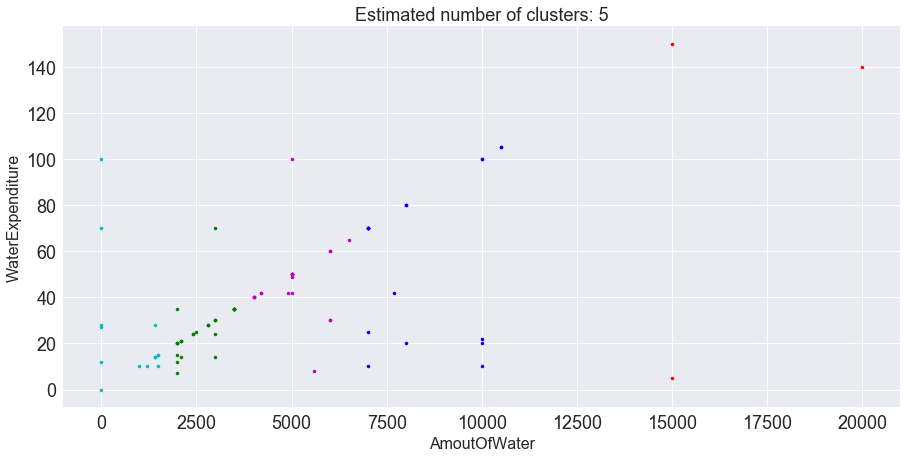

In [27]:
x_array1_urban, labels1_urban, cluster_centers1_urban = find_clusters_urban(df12_urban)
draw_clusters_plot_urban(x_array1_urban, labels1_urban, cluster_centers1_urban)

In [28]:
df_cluster1_urban = df10_urban.copy()
df_cluster1_urban['Count'] = 1
df_cluster1_urban['ClusterClass'] = pd.Series(labels1_urban, index=df_cluster1_urban.index)
df_cluster1_urban['Group'] = df_cluster1_urban.ClusterClass.apply(lambda a: pos_to_char(a))
df_cluster1_urban['AgeGroup'] = df_cluster1_urban.Age.apply(lambda a: get_age_group(a))


In [29]:
df_cluster1_urban.loc[df_cluster1_urban['Group'] == 'A', 'Group'] = 'AA'
df_cluster1_urban.loc[df_cluster1_urban['Group'] == 'D', 'Group'] = 'DD'
df_cluster1_urban.loc[df_cluster1_urban['Group'] == 'C', 'Group'] = 'CC'
df_cluster1_urban.loc[df_cluster1_urban['Group'] == 'E', 'Group'] = 'EE'
df_cluster1_urban.loc[df_cluster1_urban['Group'] == 'AA', 'Group'] = 'D'
df_cluster1_urban.loc[df_cluster1_urban['Group'] == 'CC', 'Group'] = 'E'
df_cluster1_urban.loc[df_cluster1_urban['Group'] == 'DD', 'Group'] = 'A'
df_cluster1_urban.loc[df_cluster1_urban['Group'] == 'EE', 'Group'] = 'C'


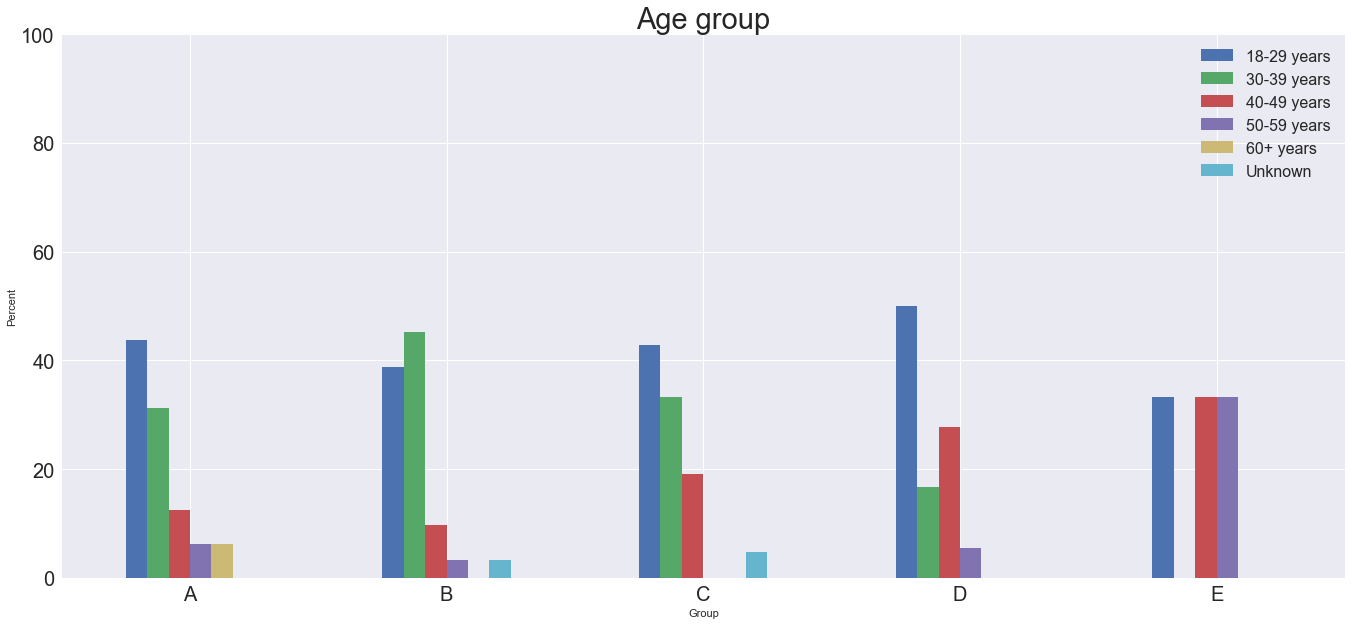

In [30]:
show_diff_for(df_cluster1_urban, 'AgeGroup', 'Age group', [], (1, 1.0))


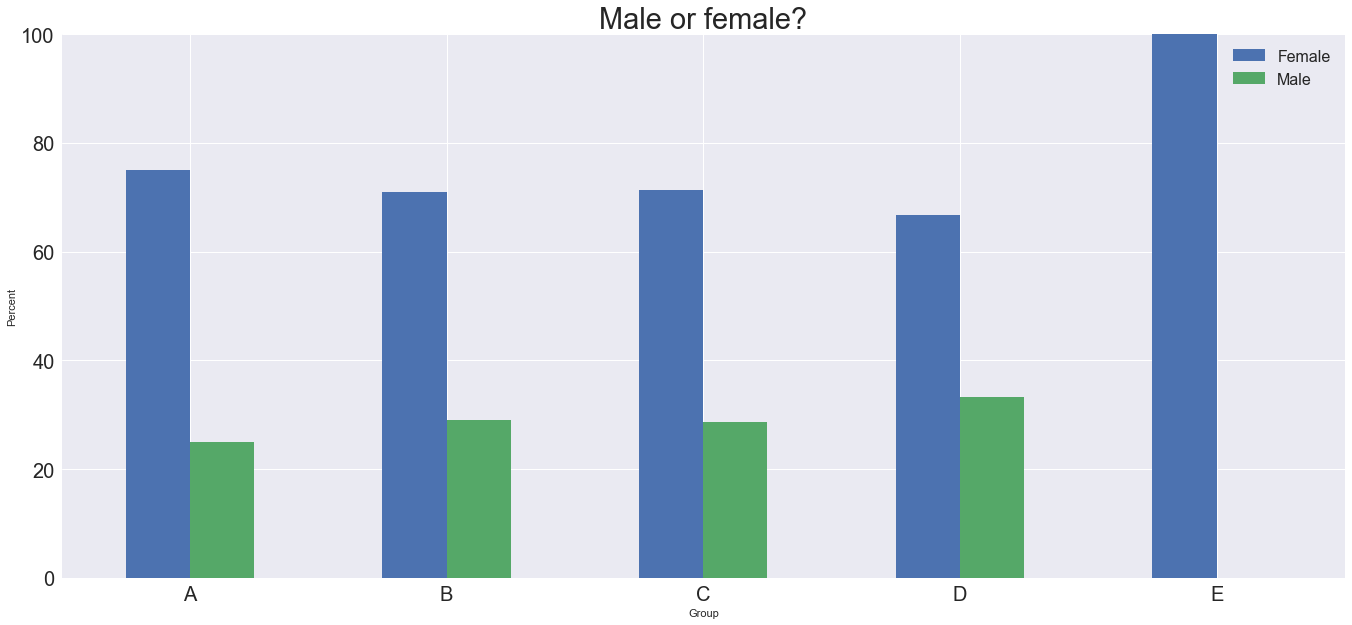

In [31]:
show_diff_for(df_cluster1_urban, 'Gender', 'Male or female?', ['Female', 'Male'], (1, 1.0))


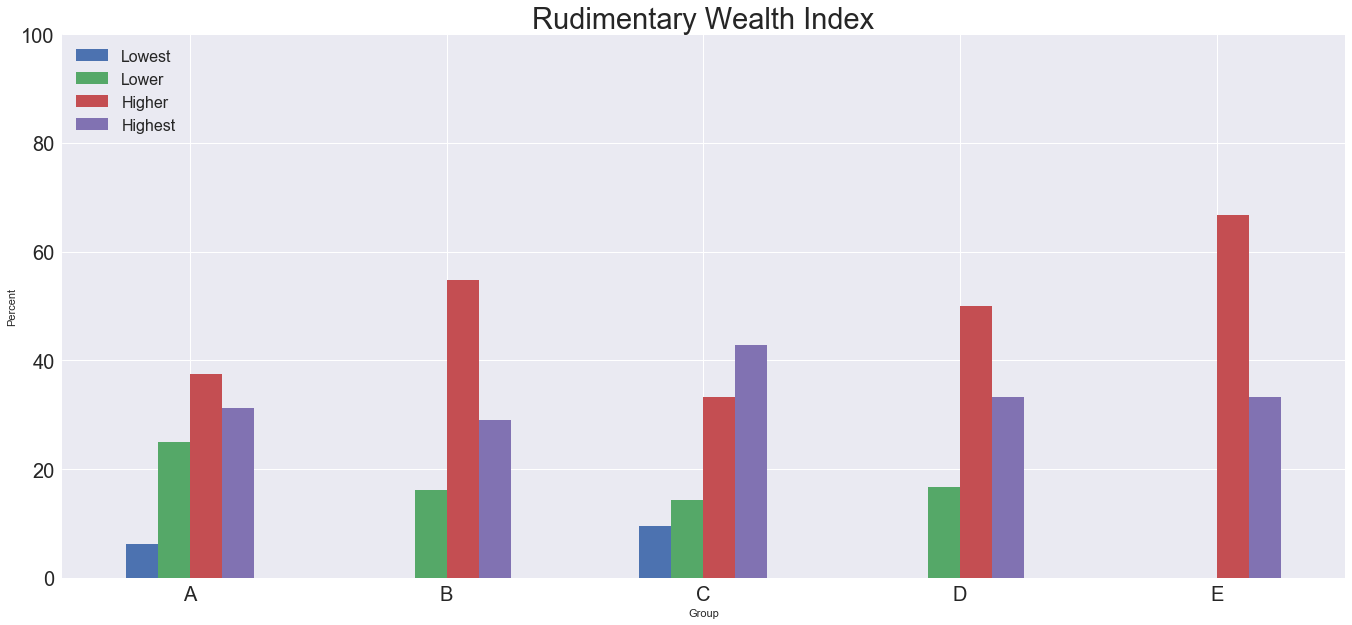

In [32]:
show_diff_for(df_cluster1_urban, 'RudWI', 'Rudimentary Wealth Index', ['Lowest', 'Lower', 'Higher', 'Highest'], (0.1, 1.0))


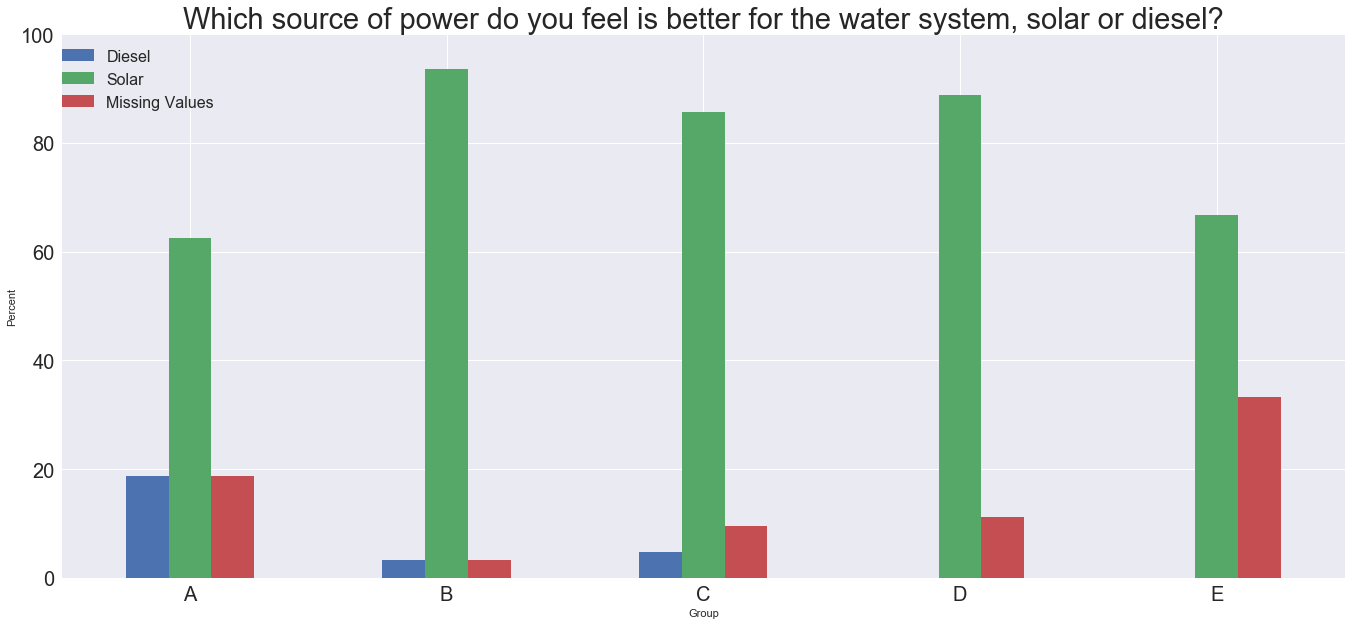

In [33]:
show_diff_for(df_cluster1_urban, 'PowerSource', 'Which source of power do you feel is better for the water system, solar or diesel?', ['Diesel', 'Solar','Missing Values'], (0.13, 1.0))


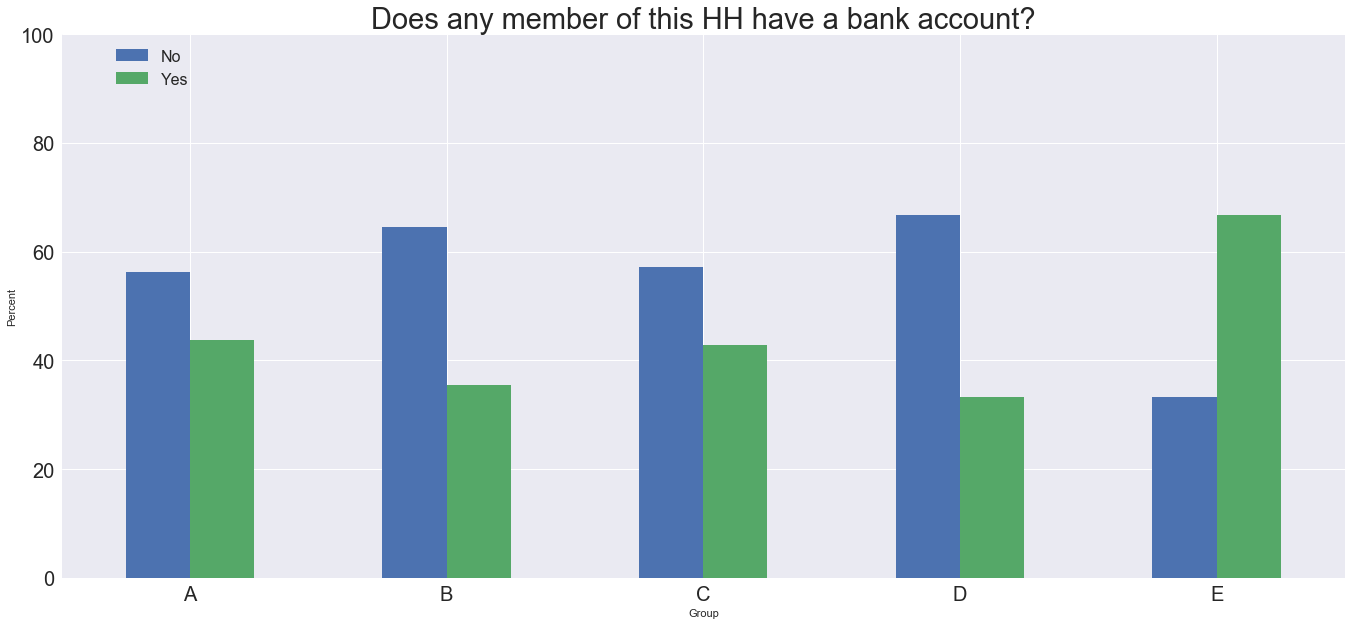

In [34]:
show_diff_for(df_cluster1_urban, 'BankAccount', 'Does any member of this HH have a bank account?', ['No', 'Yes'], (0.11, 1.0))


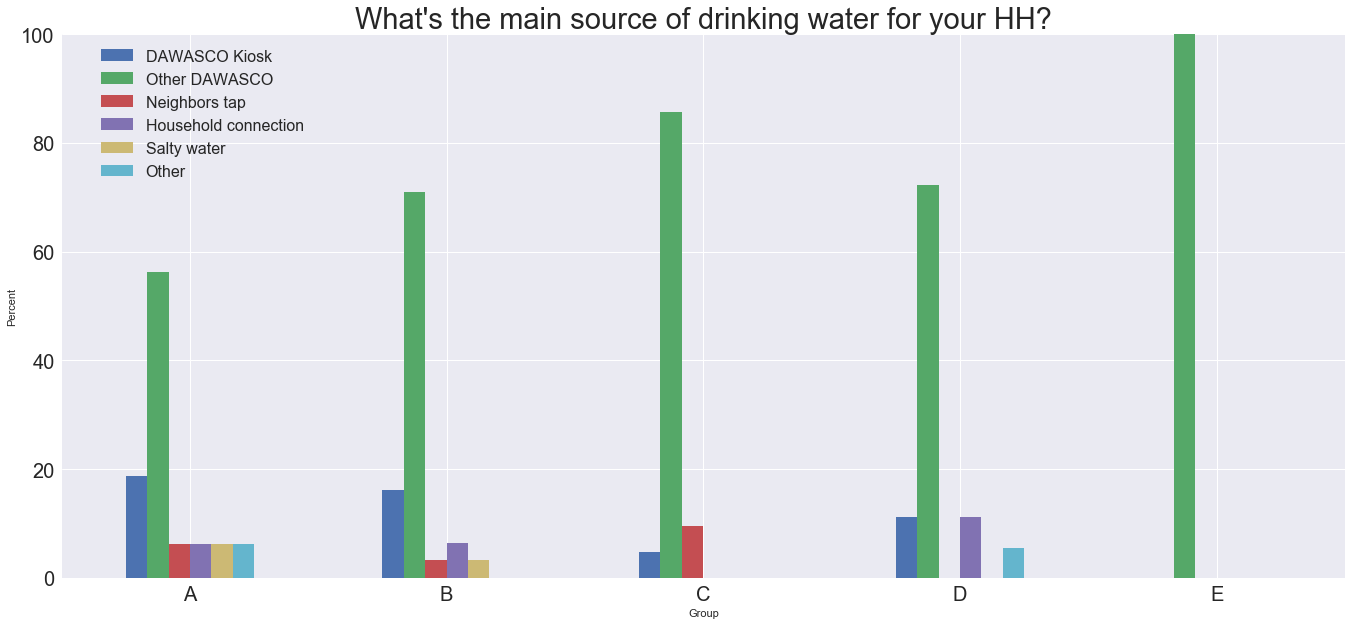

In [35]:
source_of_water2 = ['DAWASCO Kiosk', 'Other DAWASCO', 'Neighbors tap', 'Household connection', 'Salty water', 'Other' ]
show_diff_for(df_cluster1_urban, 'PrimarySource', "What's the main source of drinking water for your HH?", source_of_water2, (0.2, 1.0))


C:\Program Files\Anaconda3\lib\site-packages\pandas\core\groupby.py:3961: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


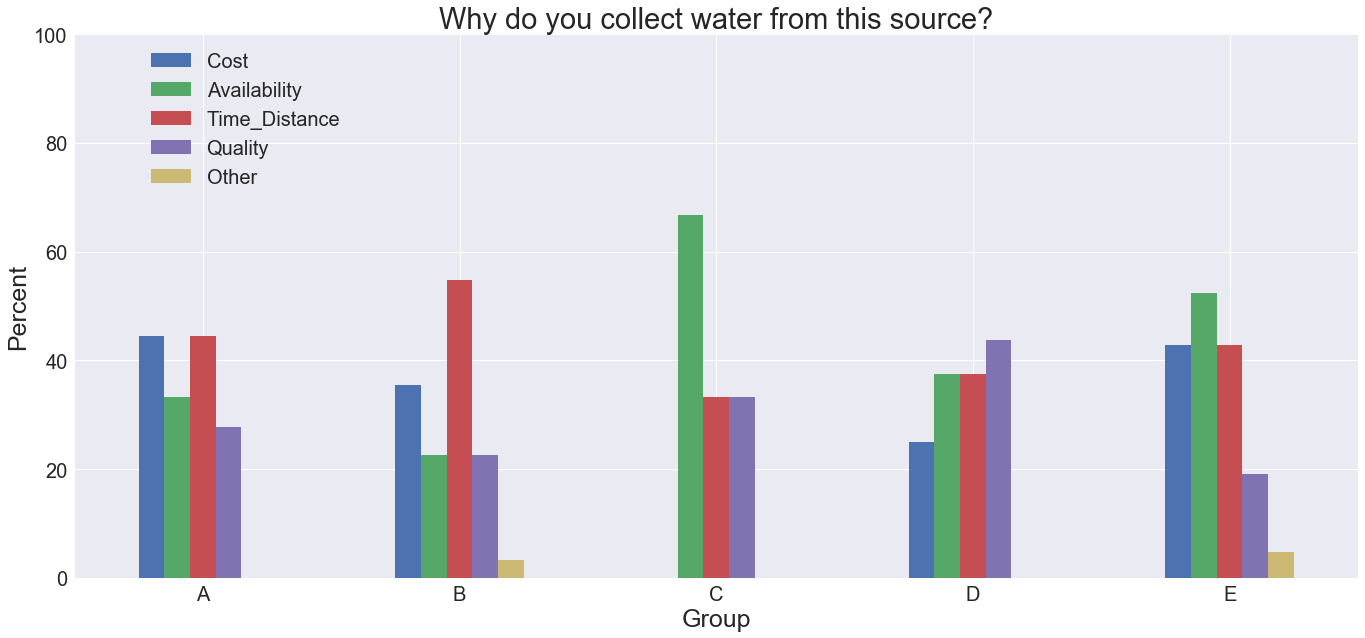

In [36]:
show_reasons_diff(df_cluster1_urban, ['Cost', 'Availability', 'Time_Distance', 'Quality', 'Other'], (0.221, 1.0))


<a id='bl_Mikoroshini'></a>
# Mikoroshini

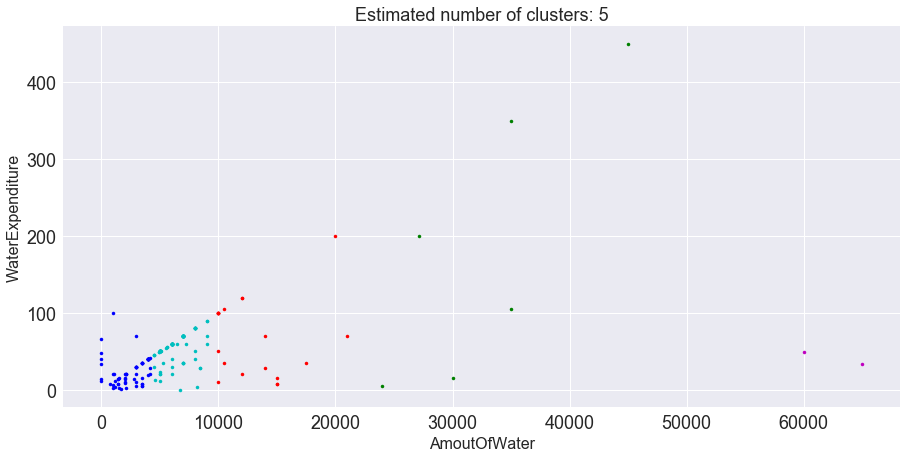

In [37]:
df_Mikoroshini = df_survey_urban[df_survey_urban.CommName == 'Mikoroshini'] 
df10_urban = df_Mikoroshini.copy()
df11_urban = changeDF(df10_urban)
df12_urban = df11_urban.fillna(0)
x_array2_urban, labels2_urban, cluster_centers2_urban = find_clusters_urban(df12_urban)
draw_clusters_plot_urban(x_array2_urban, labels2_urban, cluster_centers2_urban)

In [38]:

df_cluster2_urban = df10_urban.copy()
df_cluster2_urban['Count'] = 1
df_cluster2_urban['ClusterClass'] = pd.Series(labels2_urban, index=df_cluster2_urban.index)
df_cluster2_urban['Group'] = df_cluster2_urban.ClusterClass.apply(lambda a: pos_to_char(a))
df_cluster2_urban['AgeGroup'] = df_cluster2_urban.Age.apply(lambda a: get_age_group(a))


In [39]:
df_cluster2_urban.loc[df_cluster2_urban['Group'] == 'B', 'Group'] = 'BB'
df_cluster2_urban.loc[df_cluster2_urban['Group'] == 'D', 'Group'] = 'DD'
df_cluster2_urban.loc[df_cluster2_urban['Group'] == 'BB', 'Group'] = 'D'
df_cluster2_urban.loc[df_cluster2_urban['Group'] == 'DD', 'Group'] = 'B'

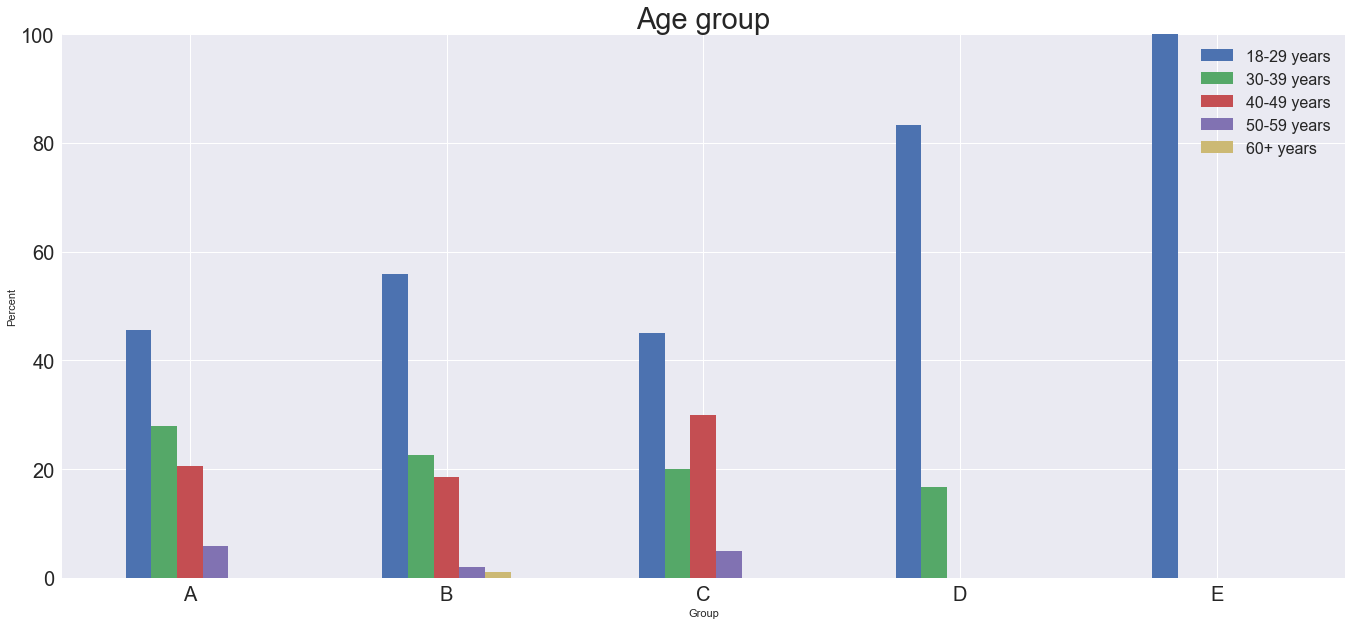

In [40]:
show_diff_for(df_cluster2_urban, 'AgeGroup', 'Age group', [], (1, 1.0))


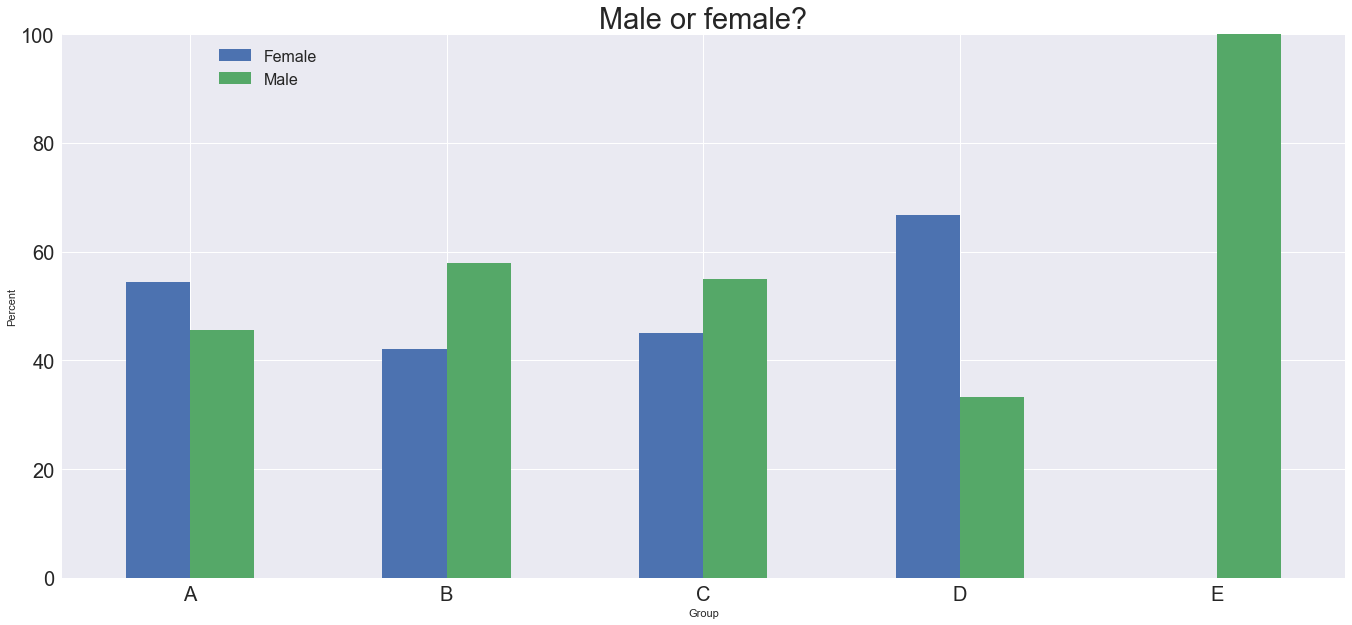

In [41]:
show_diff_for(df_cluster2_urban, 'Gender', 'Male or female?', ['Female', 'Male'], (0.21, 1.0))


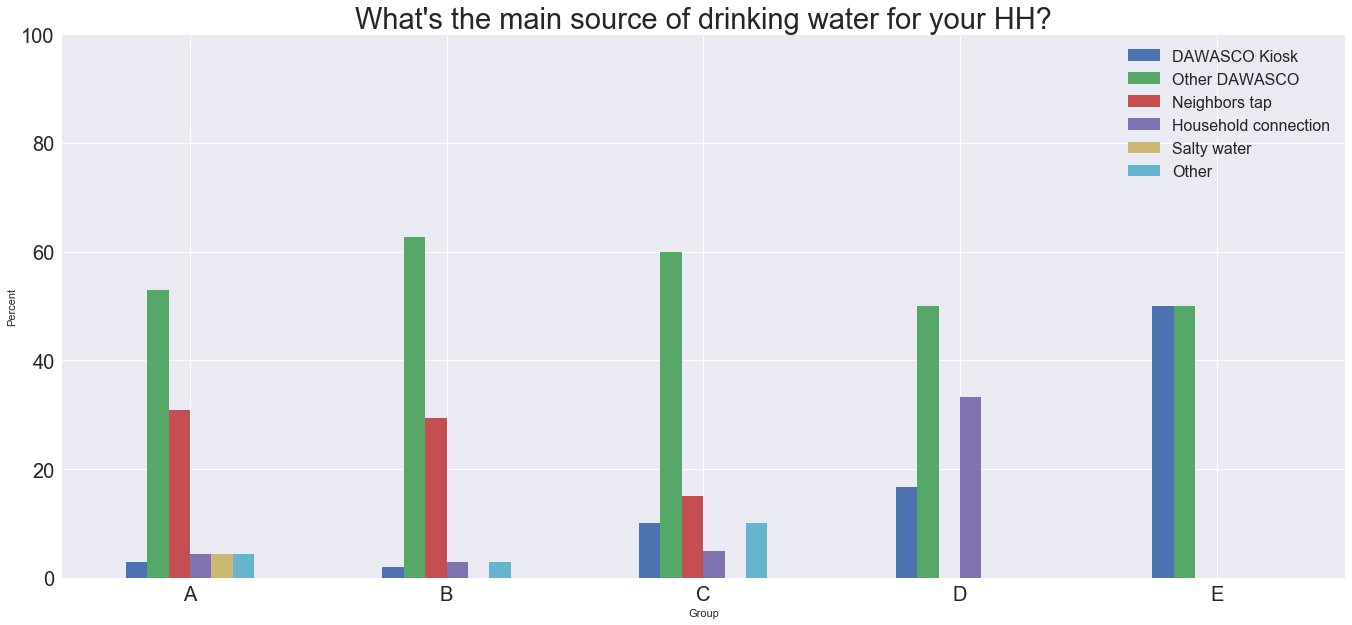

In [42]:
show_diff_for(df_cluster2_urban, 'PrimarySource', "What's the main source of drinking water for your HH?", source_of_water2, (1, 1.0))


C:\Program Files\Anaconda3\lib\site-packages\pandas\core\groupby.py:3961: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


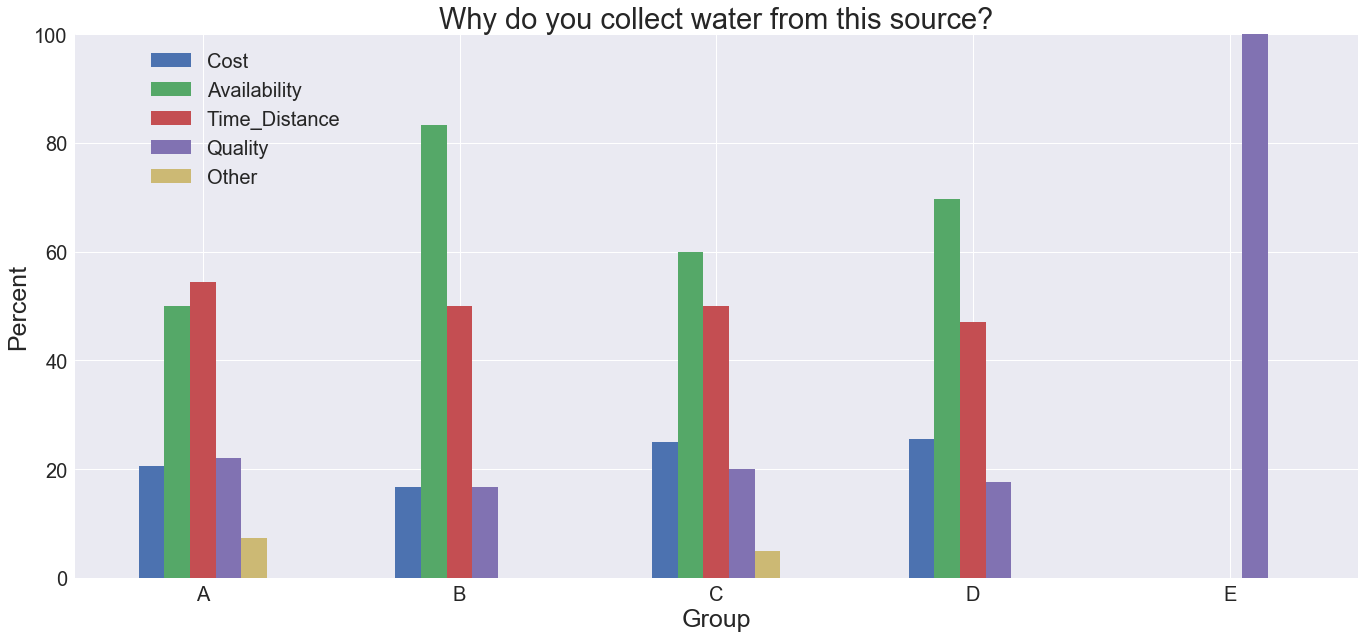

In [43]:
show_reasons_diff(df_cluster2_urban, ['Cost', 'Availability', 'Time_Distance', 'Quality', 'Other'], (0.221, 1.0))


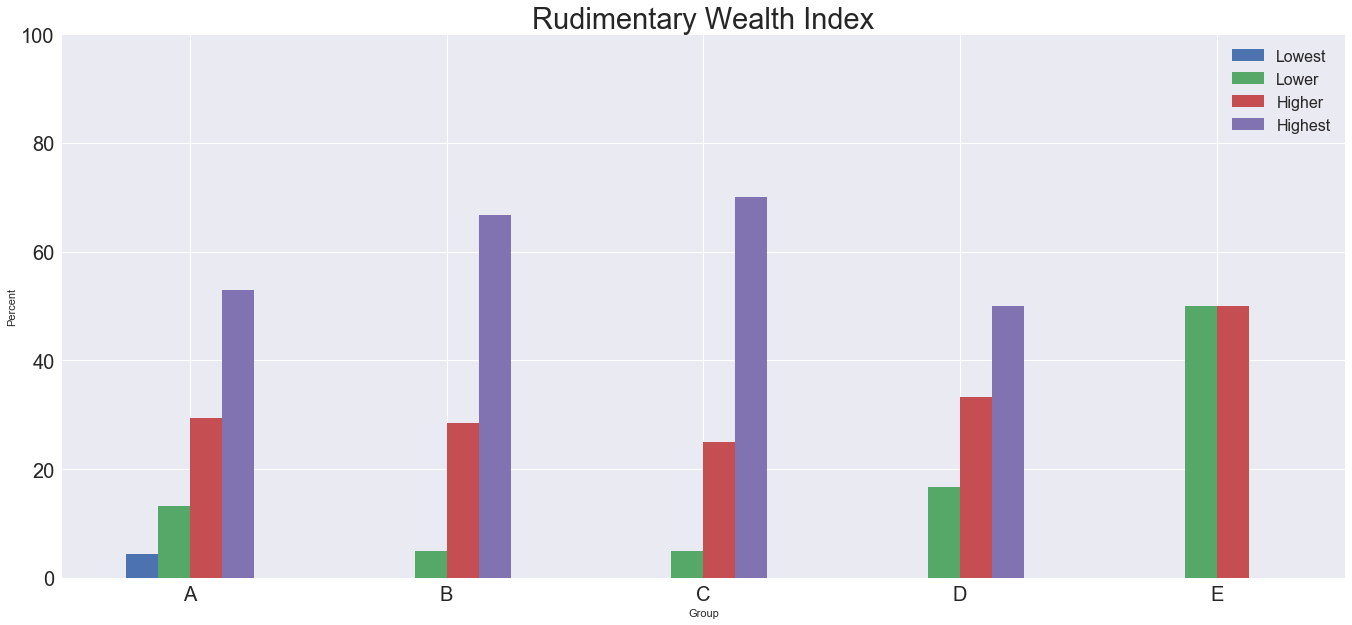

In [44]:
show_diff_for(df_cluster2_urban, 'RudWI', 'Rudimentary Wealth Index', ['Lowest', 'Lower', 'Higher', 'Highest'], (1, 1.0))


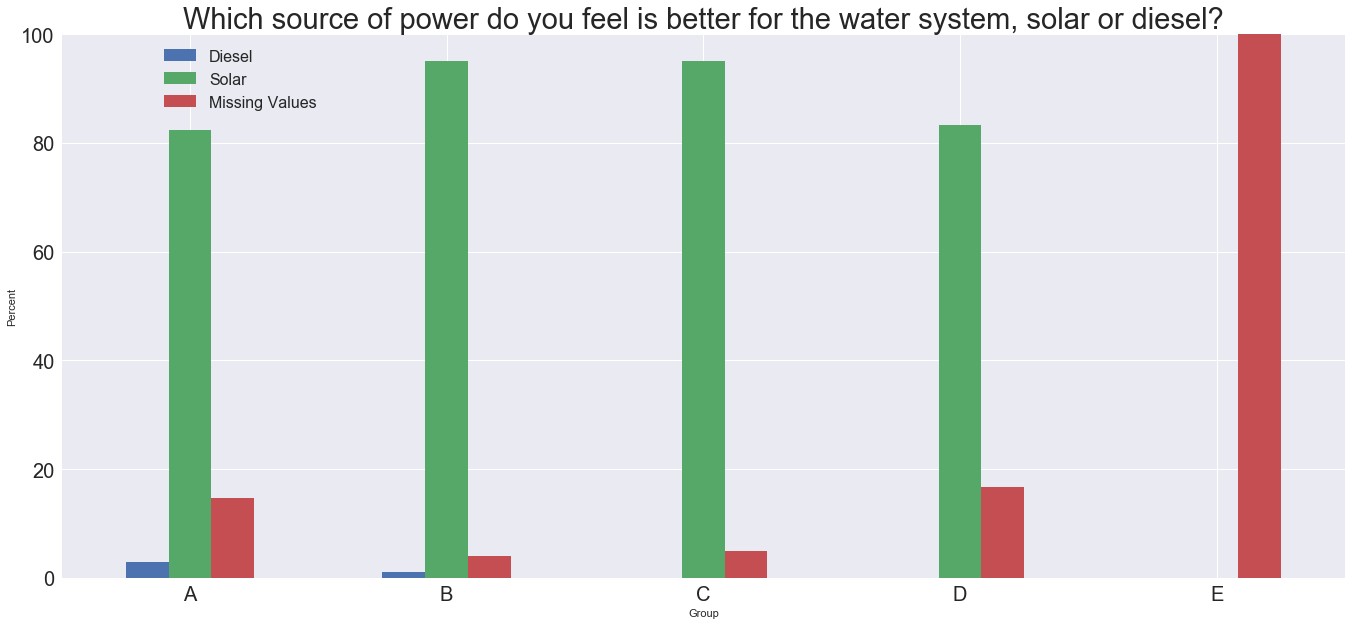

In [45]:
show_diff_for(df_cluster2_urban, 'PowerSource', 'Which source of power do you feel is better for the water system, solar or diesel?', ['Diesel', 'Solar','Missing Values'], (0.21, 1.0))


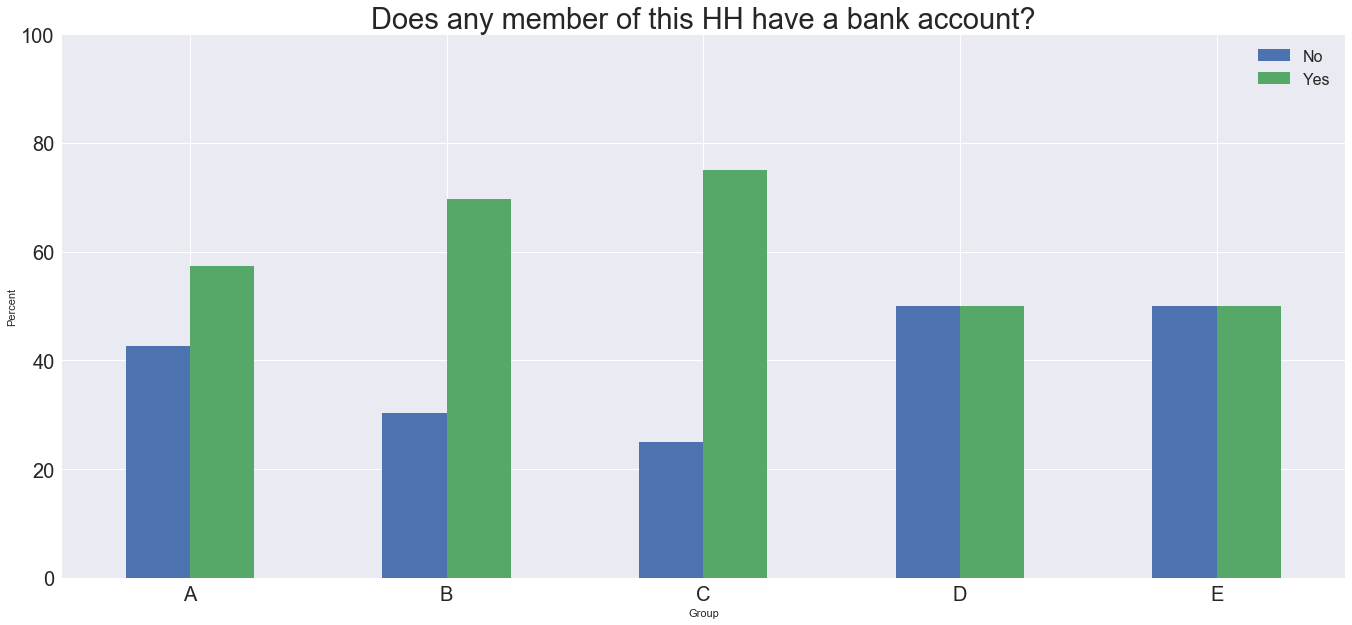

In [46]:
show_diff_for(df_cluster2_urban, 'BankAccount', 'Does any member of this HH have a bank account?', ['No', 'Yes'], (1, 1.0))


<a id='bl_Ndugumbi'></a>
## Ndugumbi

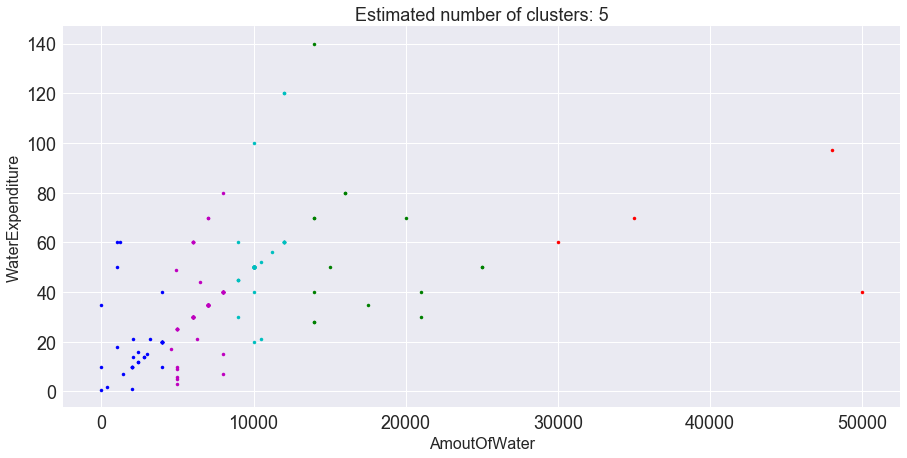

In [47]:
df_Ndugumbi = df_survey_urban[df_survey_urban.CommName == 'Ndugumbi']
df10_urban = df_Ndugumbi.copy()
df11_urban = changeDF(df10_urban)
df12_urban = df11_urban.fillna(0)
x_array3_urban, labels3_urban, cluster_centers3_urban = find_clusters_urban(df12_urban)
draw_clusters_plot_urban(x_array3_urban, labels3_urban, cluster_centers3_urban)

In [48]:
#df_processed1_urban = df12_urban.copy()
#df_cluster3_urban['Group'] = df_cluster3_urban.ClusterClass.apply(lambda a: pos_to_char(a))
#df_cluster3_urban['AgeGroup'] = df_cluster3_urban.Age.apply(lambda a: get_age_group(a))

df_cluster3_urban = df10_urban.copy()
df_cluster3_urban['Count'] = 1
df_cluster3_urban['ClusterClass'] = pd.Series(labels3_urban, index=df_cluster3_urban.index)
df_cluster3_urban['Group'] = df_cluster3_urban.ClusterClass.apply(lambda a: pos_to_char(a))
df_cluster3_urban['AgeGroup'] = df_cluster3_urban.Age.apply(lambda a: get_age_group(a))


In [49]:
df_cluster3_urban.loc[df_cluster3_urban['Group'] == 'B', 'Group'] = 'BB'
df_cluster3_urban.loc[df_cluster3_urban['Group'] == 'C', 'Group'] = 'CC'
df_cluster3_urban.loc[df_cluster3_urban['Group'] == 'D', 'Group'] = 'DD'
df_cluster3_urban.loc[df_cluster3_urban['Group'] == 'E', 'Group'] = 'EE'
df_cluster3_urban.loc[df_cluster3_urban['Group'] == 'BB', 'Group'] = 'D'
df_cluster3_urban.loc[df_cluster3_urban['Group'] == 'EE', 'Group'] = 'B'
df_cluster3_urban.loc[df_cluster3_urban['Group'] == 'CC', 'Group'] = 'E'
df_cluster3_urban.loc[df_cluster3_urban['Group'] == 'DD', 'Group'] = 'C'

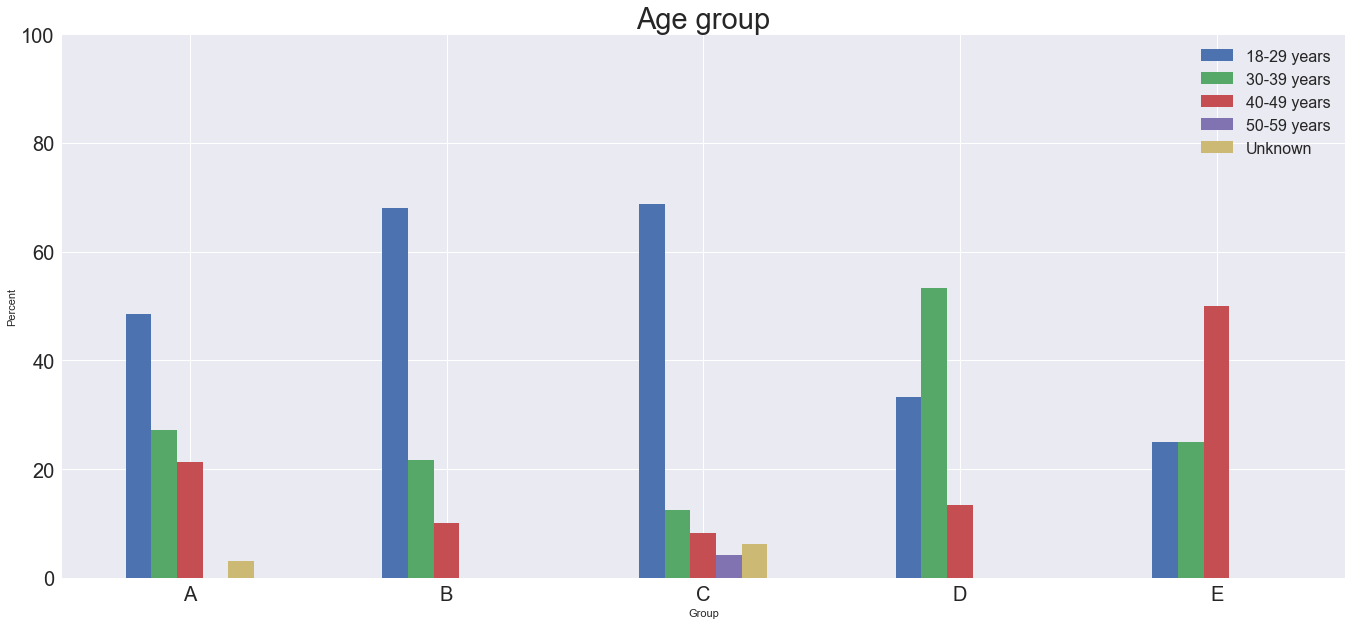

In [50]:
show_diff_for(df_cluster3_urban, 'AgeGroup', 'Age group', [], (1, 1.0))


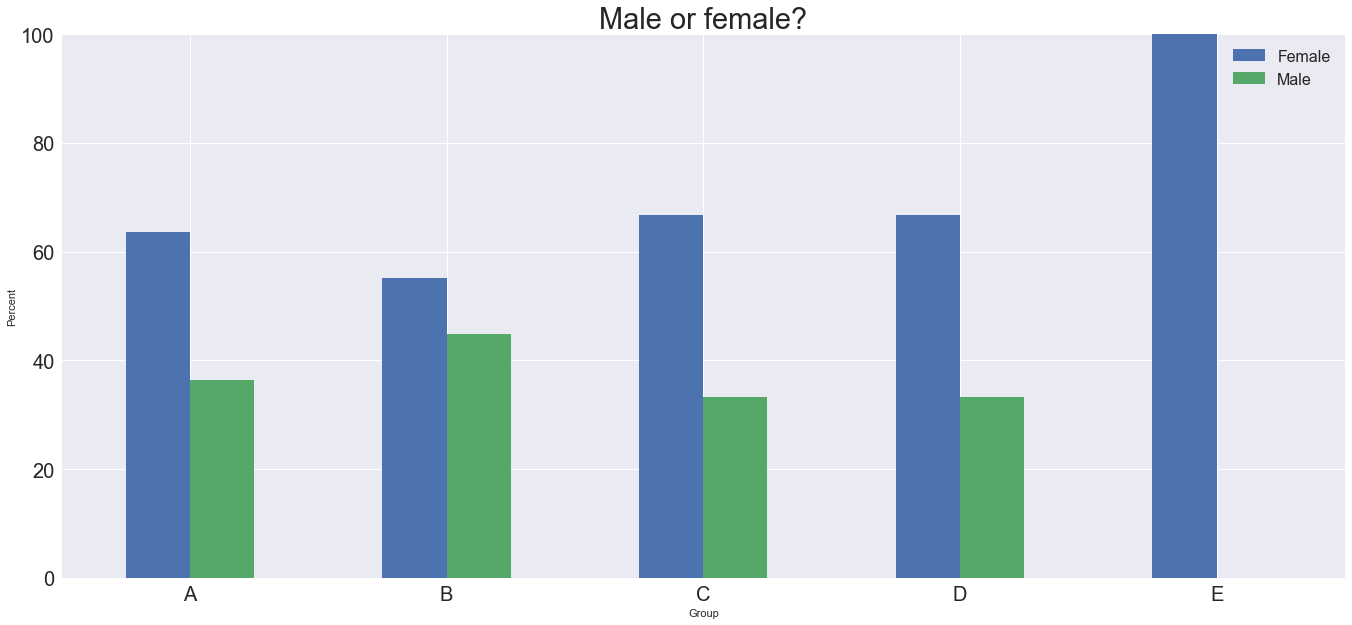

In [51]:
show_diff_for(df_cluster3_urban, 'Gender', 'Male or female?', ['Female', 'Male'], (1, 1.0))


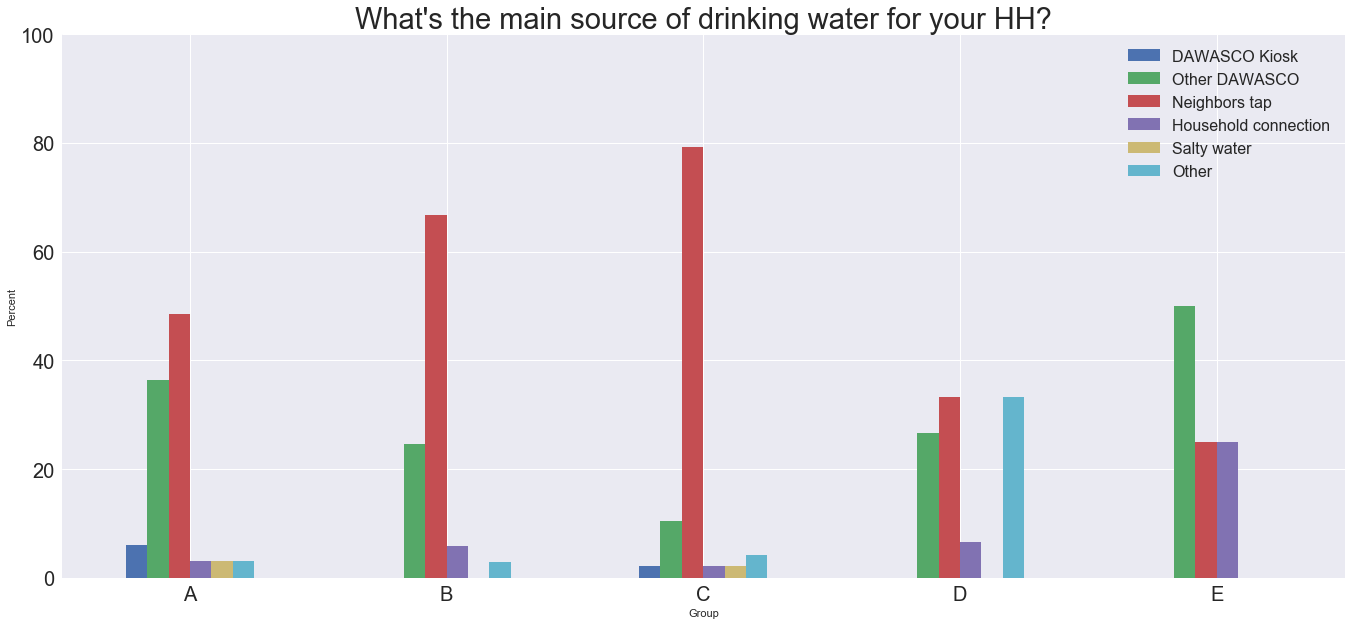

In [52]:
show_diff_for(df_cluster3_urban, 'PrimarySource', "What's the main source of drinking water for your HH?", source_of_water2, (1, 1.0))


C:\Program Files\Anaconda3\lib\site-packages\pandas\core\groupby.py:3961: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


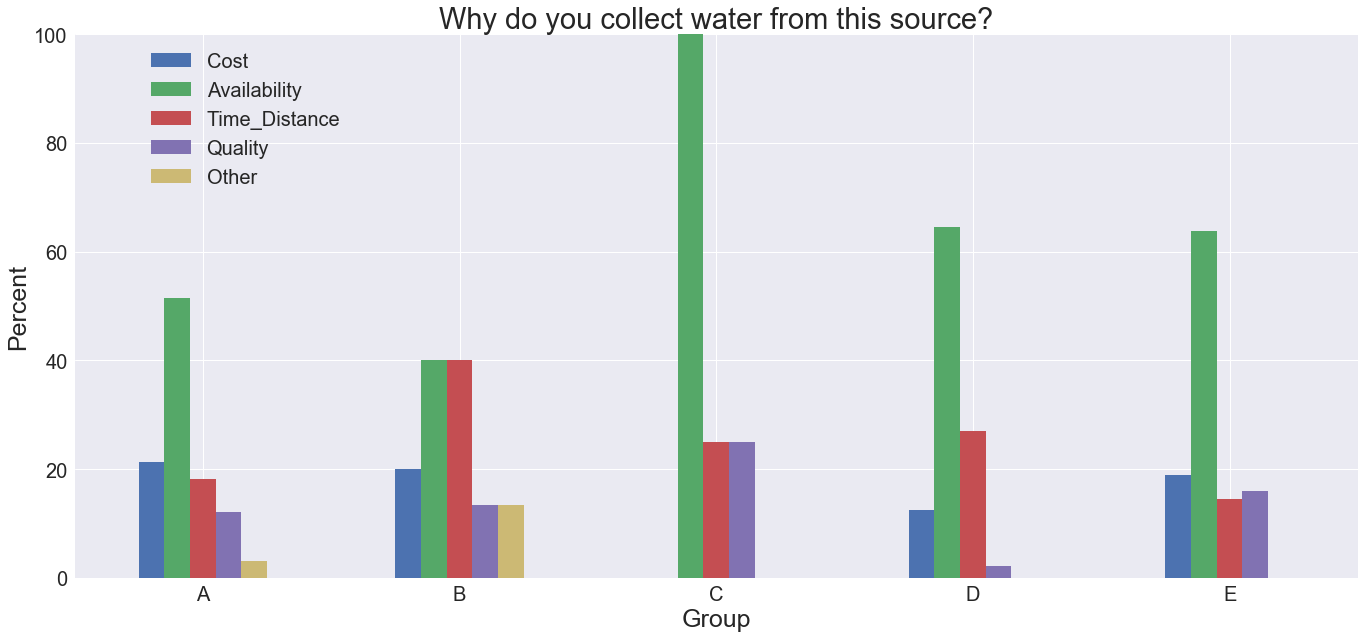

In [53]:
show_reasons_diff(df_cluster3_urban, ['Cost', 'Availability', 'Time_Distance', 'Quality', 'Other'], (0.221, 1.0))


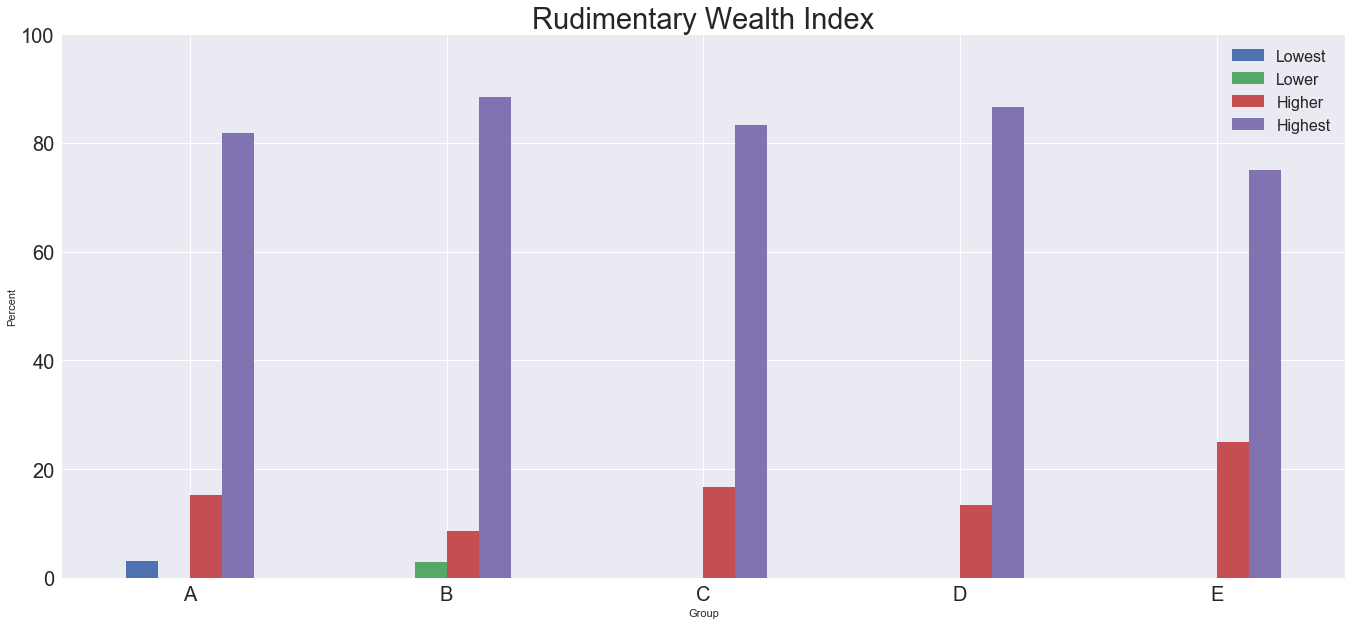

In [54]:
show_diff_for(df_cluster3_urban, 'RudWI', 'Rudimentary Wealth Index', ['Lowest', 'Lower', 'Higher', 'Highest'], (1, 1.0))


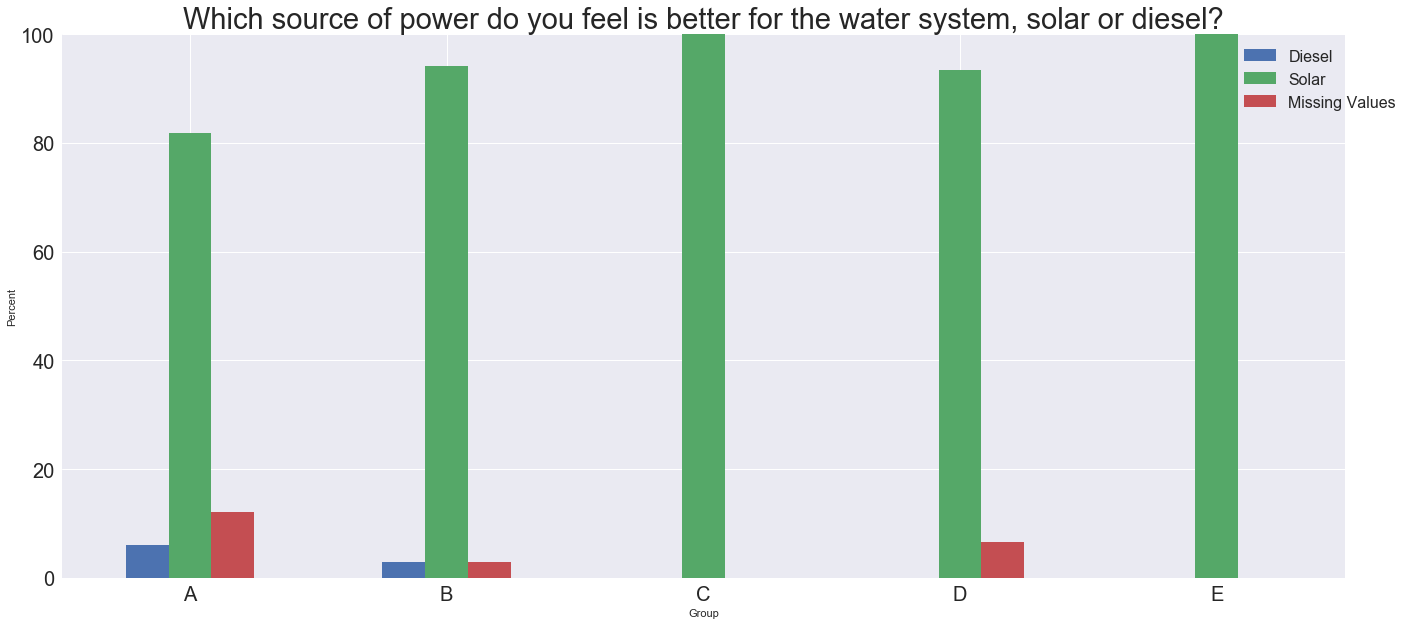

In [55]:
show_diff_for(df_cluster3_urban, 'PowerSource', 'Which source of power do you feel is better for the water system, solar or diesel?', ['Diesel', 'Solar','Missing Values'], (1.051, 1.0))


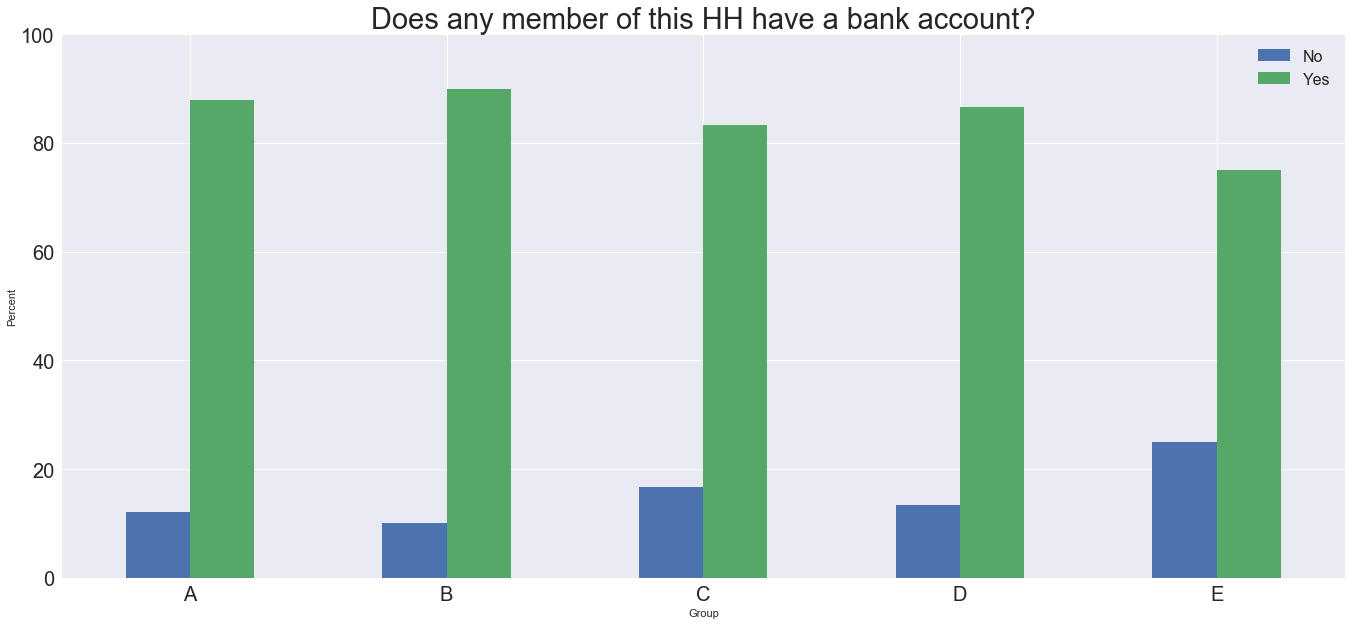

In [56]:
show_diff_for(df_cluster3_urban, 'BankAccount', 'Does any member of this HH have a bank account?', ['No', 'Yes'], (1, 1.0))


<a id='bl_urb_measurements'></a>
## Measurements of groups

In [57]:
get_group_measurements(df_cluster1_urban)

C:\Program Files\Anaconda3\lib\site-packages\pandas\core\groupby.py:3961: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


Count WaterExpenditure AmountOfWater        hh_mem           Age  \
      Responders    Average value Average value Average value Average value   
Group                                                                         
A             16           856.29         23.81          4.94         33.25   
B             31          2664.52         26.65          5.23         31.67   
C             21          5019.05         46.67          5.24         33.60   
D             18          8427.78         59.39          5.83         32.50   
E              3         16666.67         98.33          5.33         39.33   

        Men  Women   BankAccount         RudWI  
                   Average value Average value  
Group                                           
A      25.0   75.0          44.0          1.94  
B      29.0   71.0          35.0          2.13  
C      29.0   71.0          43.0          2.10  
D      33.0   67.0          33.0          2.17  
E       0.0  100.0          67.0          2.33

In [58]:
get_group_measurements(df_cluster2_urban)

C:\Program Files\Anaconda3\lib\site-packages\pandas\core\groupby.py:3961: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


Count WaterExpenditure AmountOfWater        hh_mem           Age  \
      Responders    Average value Average value Average value Average value   
Group                                                                         
A             68          2540.65         25.29          4.57         33.06   
B            102          6301.96         55.02          4.92         32.25   
C             20         12925.00         69.70          5.55         35.40   
D              6         32683.33        187.50          4.67         26.83   
E              2         62500.00         41.50          1.50         23.50   

         Men Women   BankAccount         RudWI  
                   Average value Average value  
Group                                           
A       46.0  54.0          57.0          2.31  
B       58.0  42.0          70.0          2.62  
C       55.0  45.0          75.0          2.65  
D       33.0  67.0          50.0          2.33  
E      100.0   0.0          50.0          1.50

In [59]:
get_group_measurements(df_cluster3_urban)

C:\Program Files\Anaconda3\lib\site-packages\pandas\core\groupby.py:3961: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


Count WaterExpenditure AmountOfWater        hh_mem           Age  \
      Responders    Average value Average value Average value Average value   
Group                                                                         
A             33          2400.00         19.18          5.09         32.62   
B             69          6540.58         34.58          5.57         29.19   
C             48         10275.00         53.42          5.90         30.11   
D             15         17366.67         57.40          5.73         32.87   
E              4         40750.00         66.75          2.75         36.00   

        Men  Women   BankAccount         RudWI  
                   Average value Average value  
Group                                           
A      36.0   64.0          88.0          2.76  
B      45.0   55.0          90.0          2.86  
C      33.0   67.0          83.0          2.83  
D      33.0   67.0          87.0          2.87  
E       0.0  100.0          75.0          2.75

<a id='bl_rural'></a>
# Rural communities analysis

<a id='bl_Lulembela'></a>
## Lulembela

In [60]:
df_Lulembela = df_survey[df_survey.CommName == 'Lulembela']
df_Lulembela.shape

(279, 36)

In [61]:
df10 = df_Lulembela.copy()
df11 = df10[['Phone_Number', 'AmountOfWater', 'WaterExpenditure', 'Gender', 'Farming', 'AnimalRaising', 'PrimarySource', 'WaterAvailability', 'PowerSource', 'BankAccount', 'FloorMaterial', 'RudWI']]
df12 = df11.dropna()
df12.shape

(275, 12)

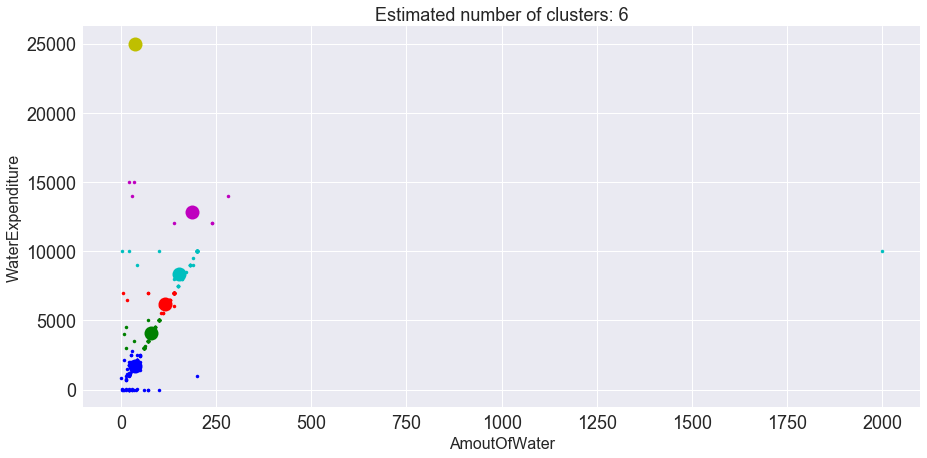

In [62]:
x_array1, labels1, cluster_centers1 = find_clusters(df12)
draw_clusters_plot(x_array1, labels1, cluster_centers1)

In [63]:
df_processed1 = df12.copy()
df_processed1['ClusterClass'] = pd.Series(labels1, index=df_processed1.index)
df_cc1 = df_processed1[['Phone_Number','ClusterClass']]
df_cluster1 = df10.merge(df_cc1, left_index=True, right_index=True, how = 'left')
df_cluster1 = df_cluster1[~np.isnan(df_cluster1.ClusterClass)]
df_cluster1 = df_cluster1[df_cluster1.ClusterClass != 5]
df_cluster1['Group'] = df_cluster1.ClusterClass.apply(lambda a: pos_to_char(a))
df_cluster1['AgeGroup'] = df_cluster1.Age.apply(lambda a: get_age_group(a))
df_cluster1.shape

(274, 40)

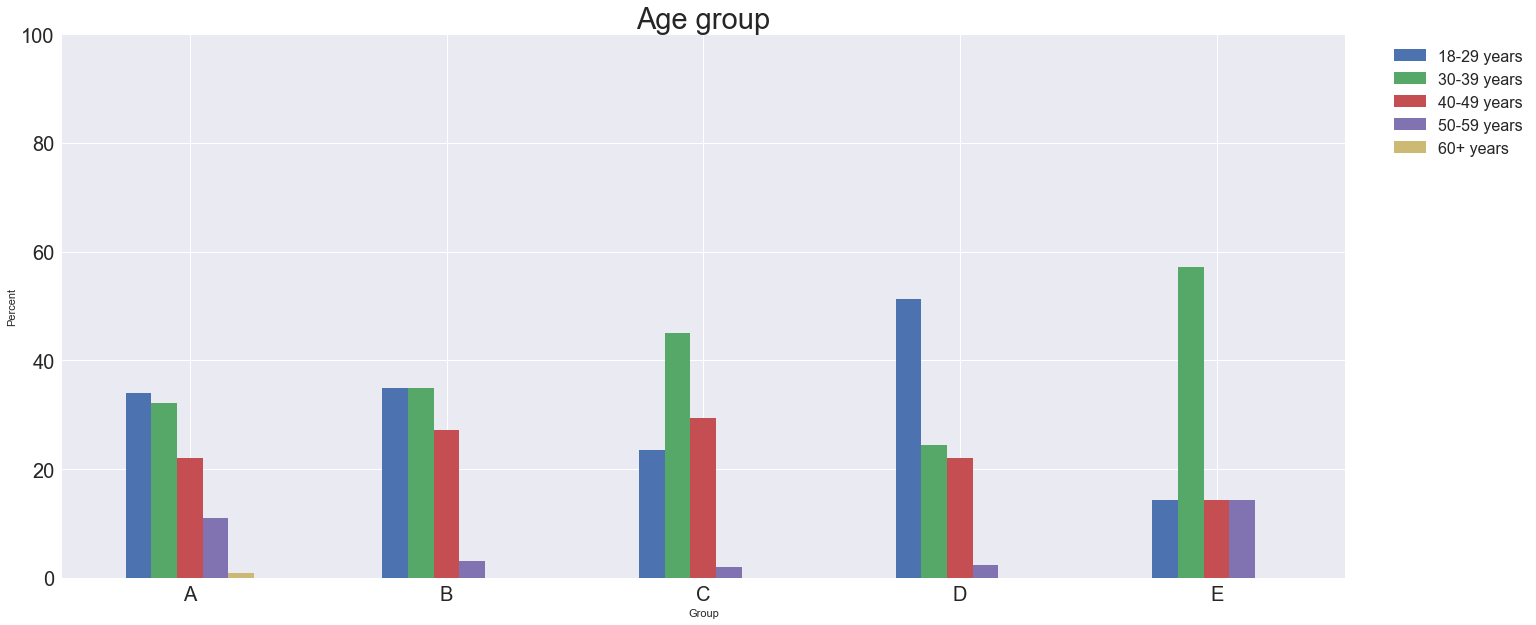

In [64]:
show_diff_for(df_cluster1, 'AgeGroup', 'Age group', [], (1.15, 1.0))

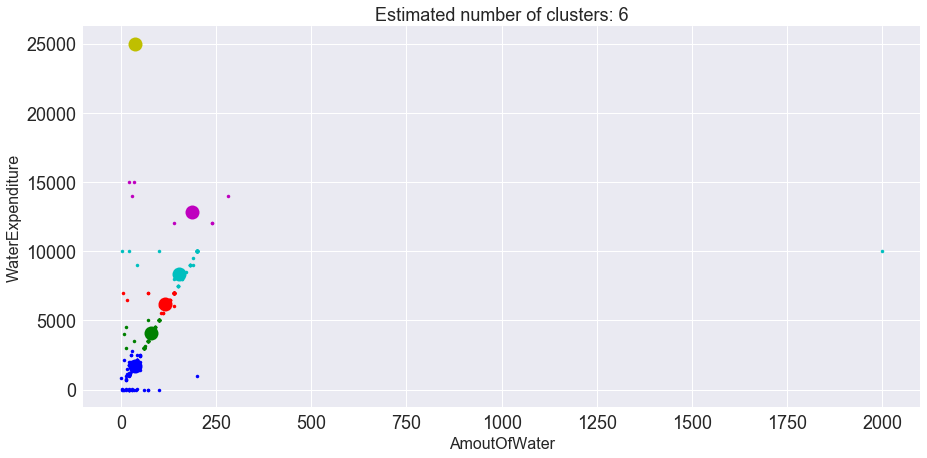

In [65]:
x_array1, labels1, cluster_centers1 = find_clusters(df12)
draw_clusters_plot(x_array1, labels1, cluster_centers1)

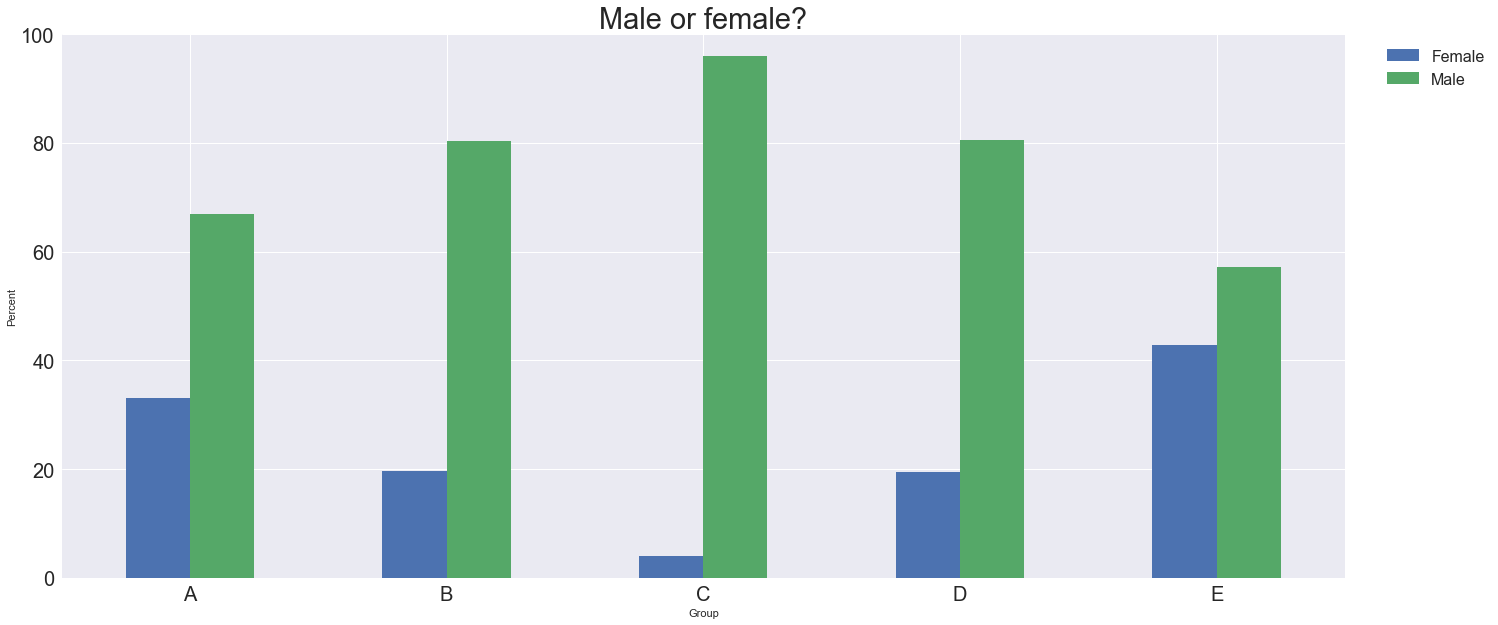

In [66]:
show_diff_for(df_cluster1, 'Gender', 'Male or female?', ['Female', 'Male'], (1.12, 1.0))

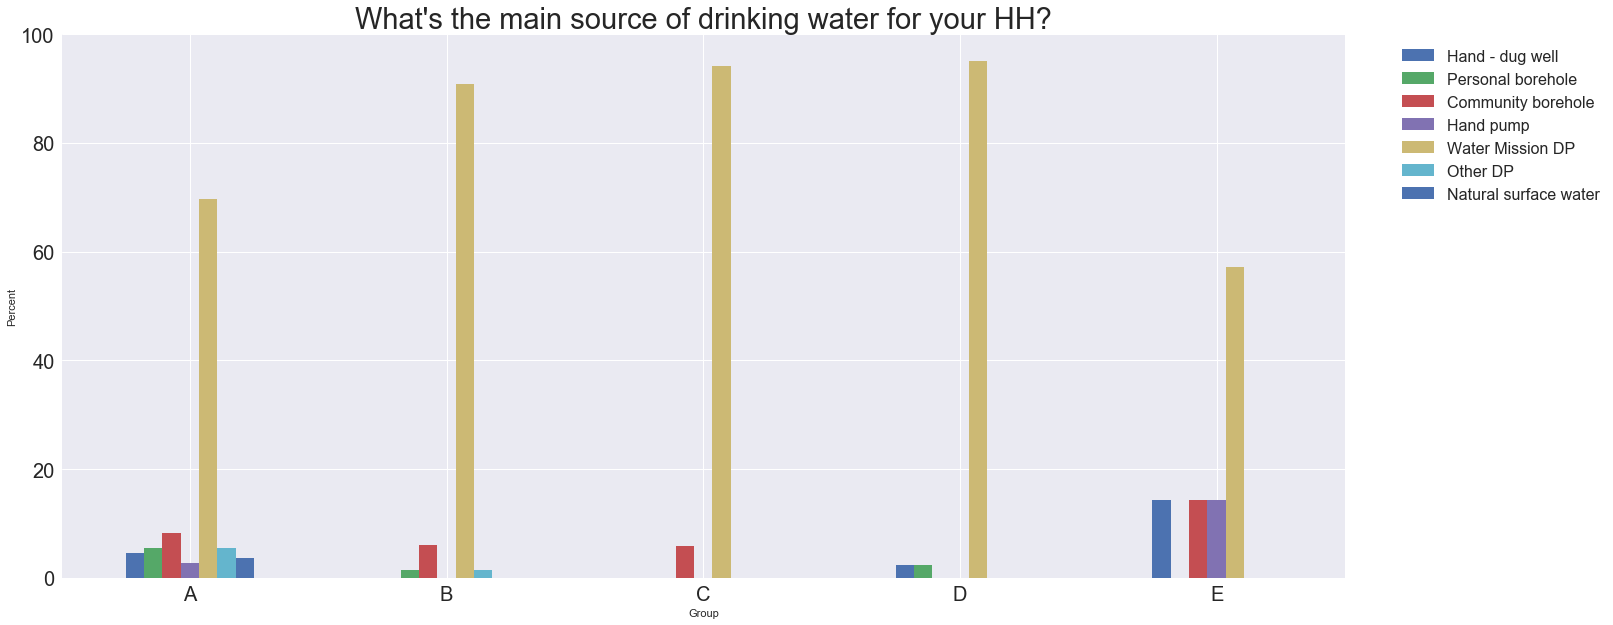

In [67]:
source_of_water =['Hand - dug well', 'Personal borehole', 'Community borehole', 'Hand pump', 'Water Mission DP', 'Other DP', 'Natural surface water' ]
show_diff_for(df_cluster1, 'PrimarySource', "What's the main source of drinking water for your HH?", source_of_water, (1.21, 1.0))

C:\Program Files\Anaconda3\lib\site-packages\pandas\core\groupby.py:3961: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


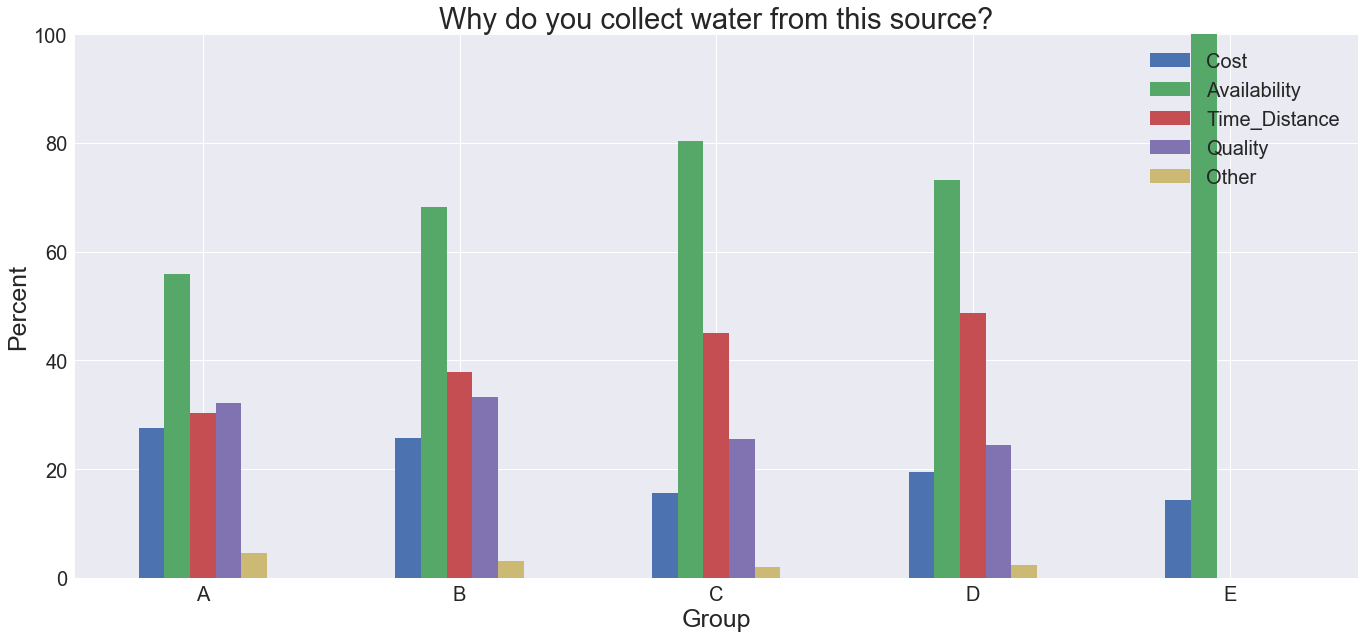

In [68]:
show_reasons_diff(df_cluster1, ['Cost', 'Availability', 'Time_Distance', 'Quality', 'Other'], (1, 1))

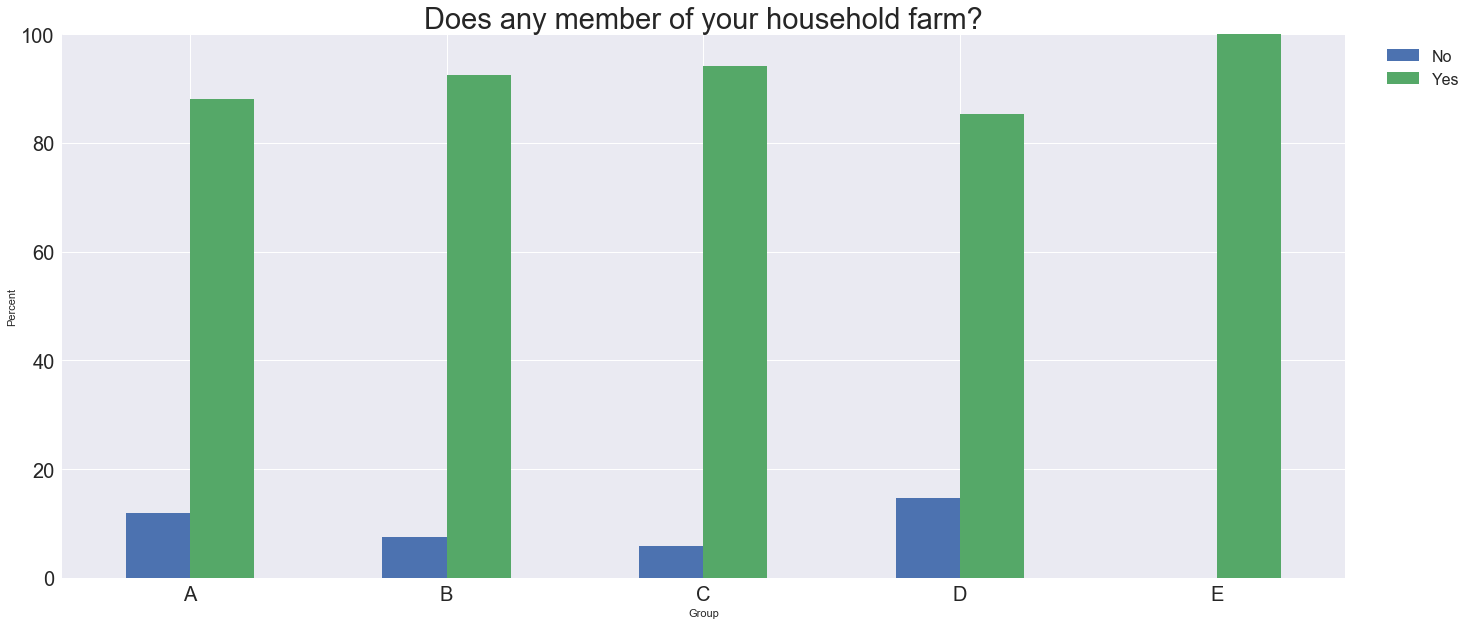

In [69]:
show_diff_for(df_cluster1, 'Farming', 'Does any member of your household farm?', ['No', 'Yes'], (1.1, 1.0))

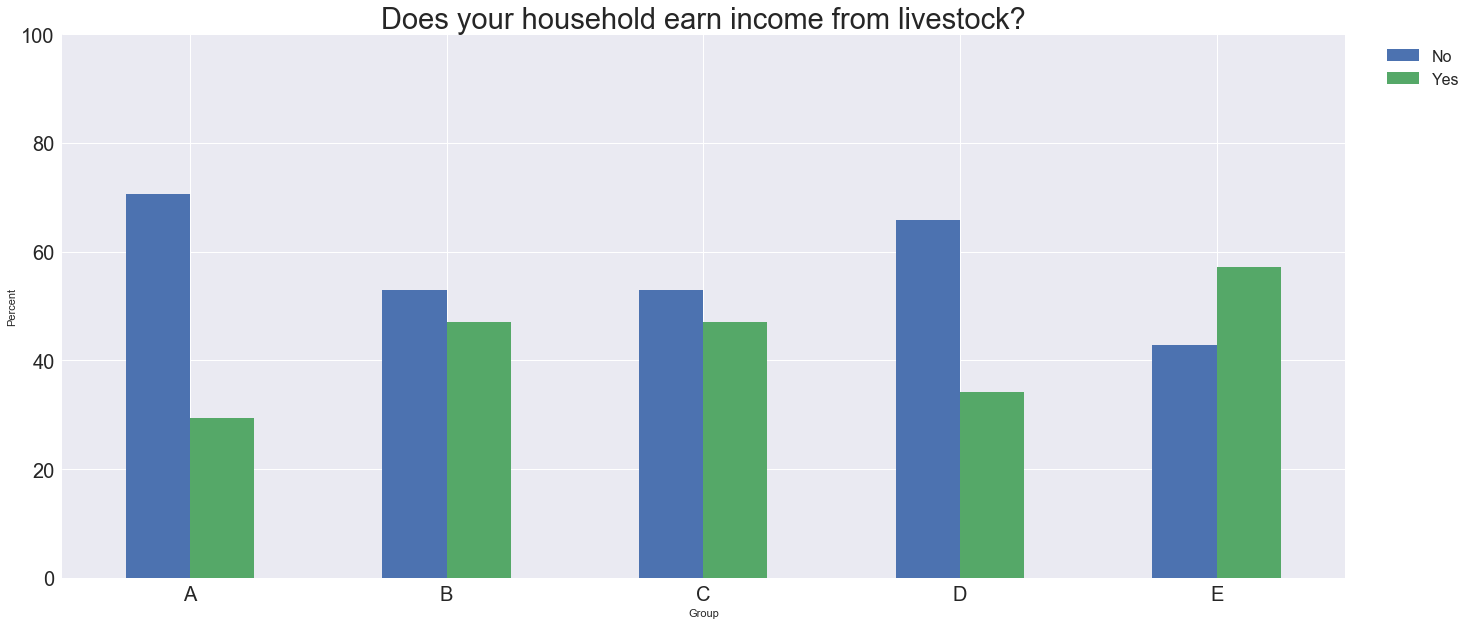

In [70]:
show_diff_for(df_cluster1, 'AnimalRaising', 'Does your household earn income from livestock?', ['No', 'Yes'], (1.1, 1.0))

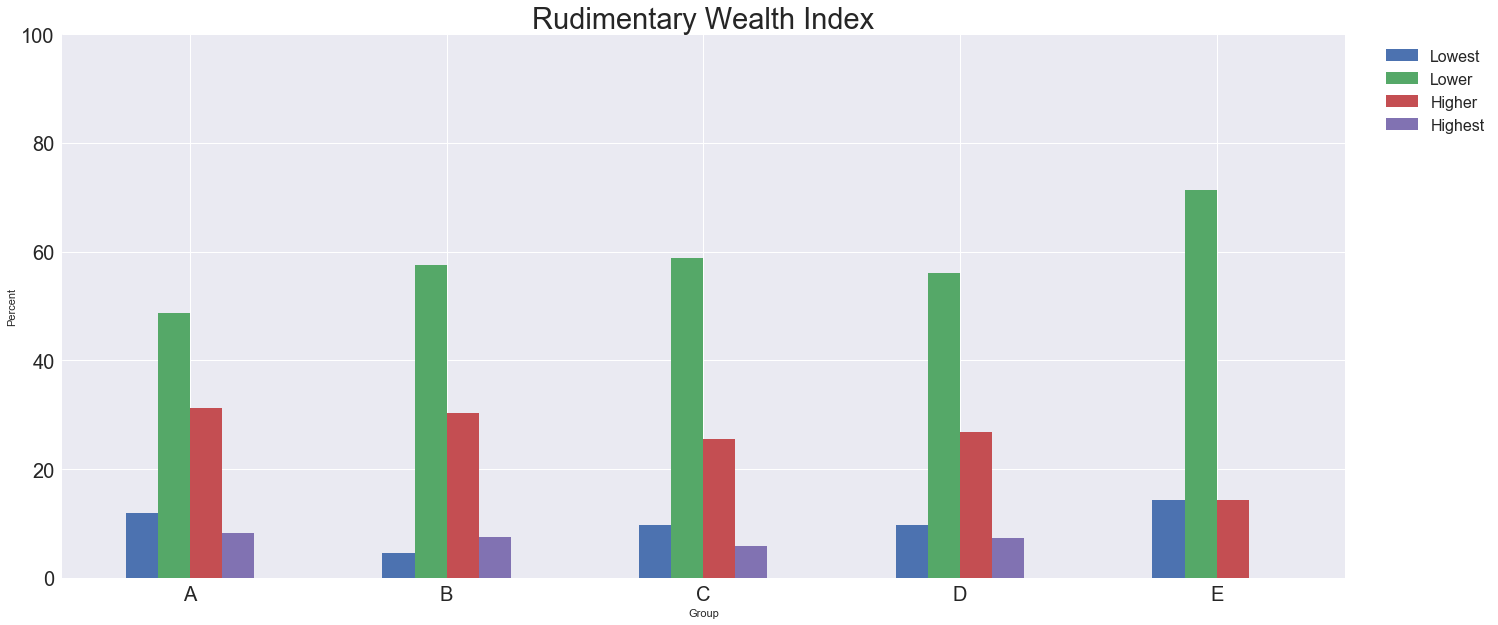

In [71]:
show_diff_for(df_cluster1, 'RudWI', 'Rudimentary Wealth Index', ['Lowest', 'Lower', 'Higher', 'Highest'], (1.12, 1.0))

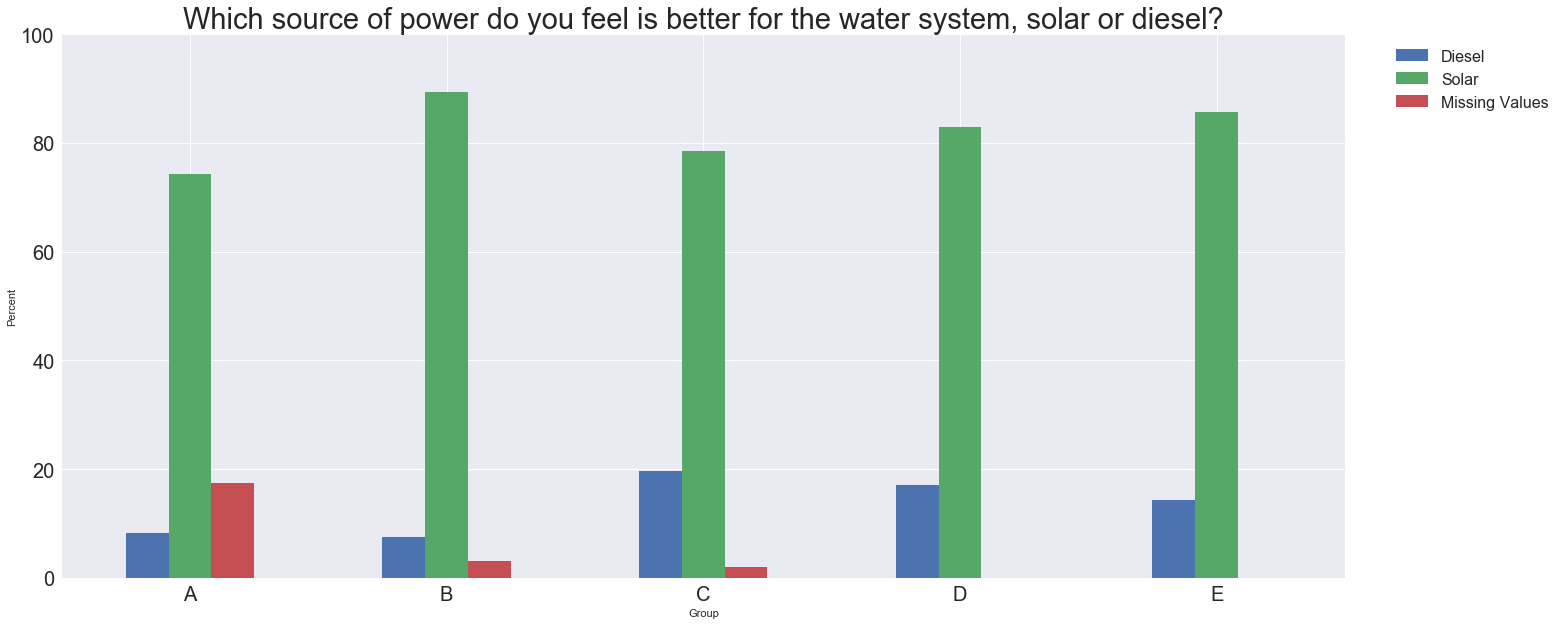

In [72]:
show_diff_for(df_cluster1, 'PowerSource', 'Which source of power do you feel is better for the water system, solar or diesel?', ['Diesel', 'Solar','Missing Values'], (1.17, 1.0))

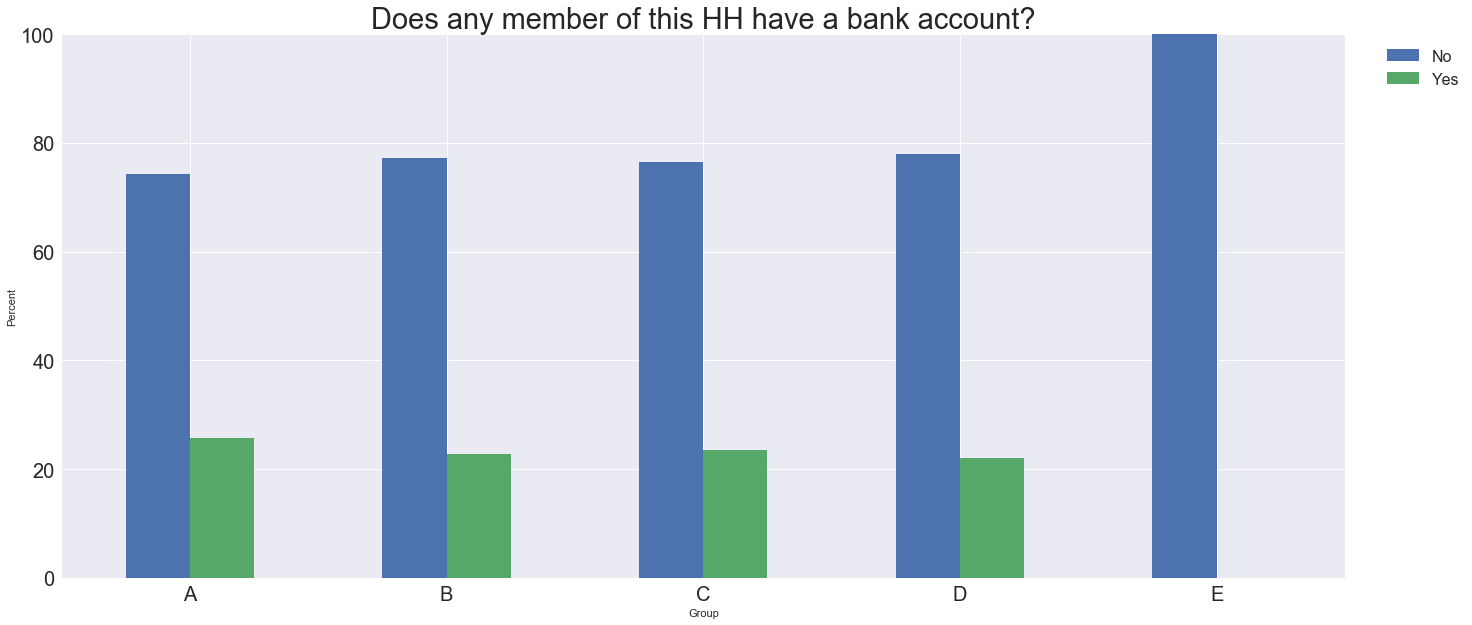

In [73]:
show_diff_for(df_cluster1, 'BankAccount', 'Does any member of this HH have a bank account?', ['No', 'Yes'], (1.1, 1.0))

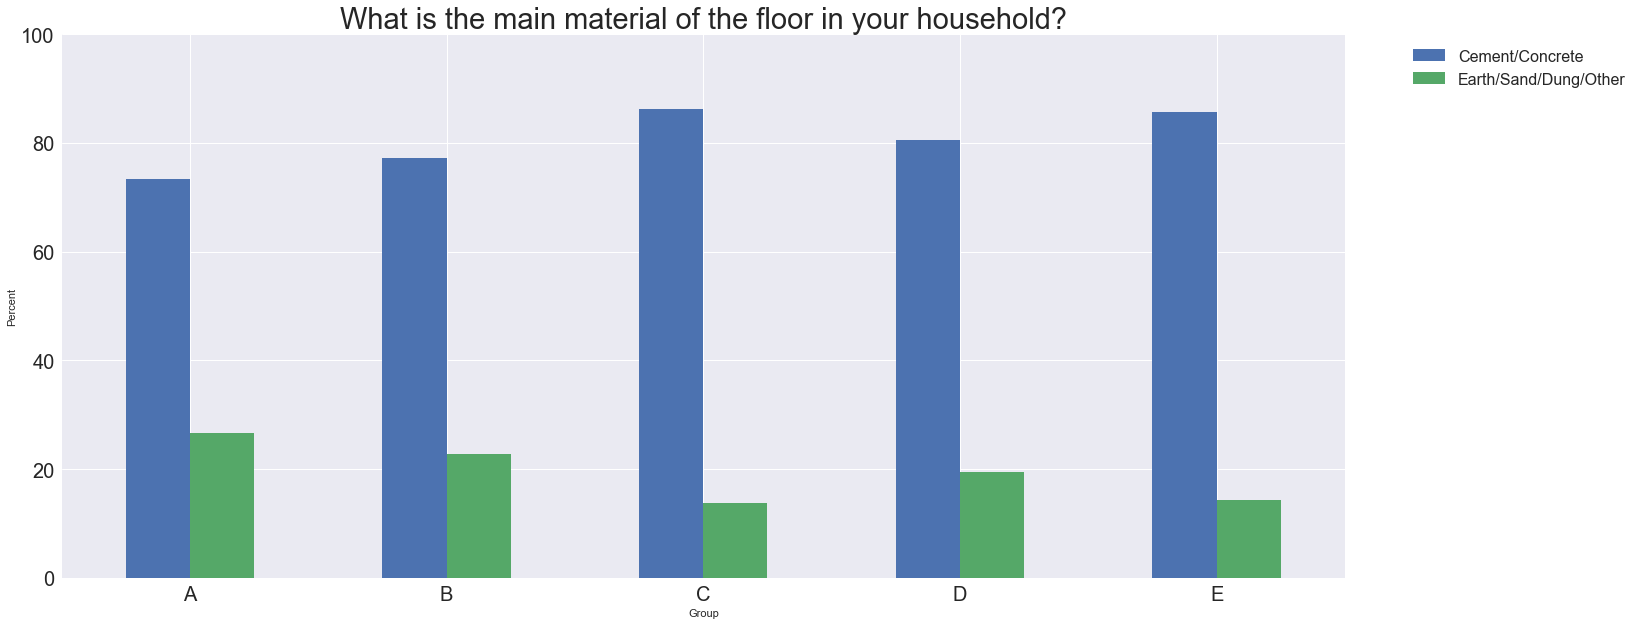

In [74]:
show_diff_for(df_cluster1, 'FloorMaterial', 'What is the main material of the floor in your household?', ['Cement/Concrete', 'Earth/Sand/Dung/Other'], (1.23, 1.0))

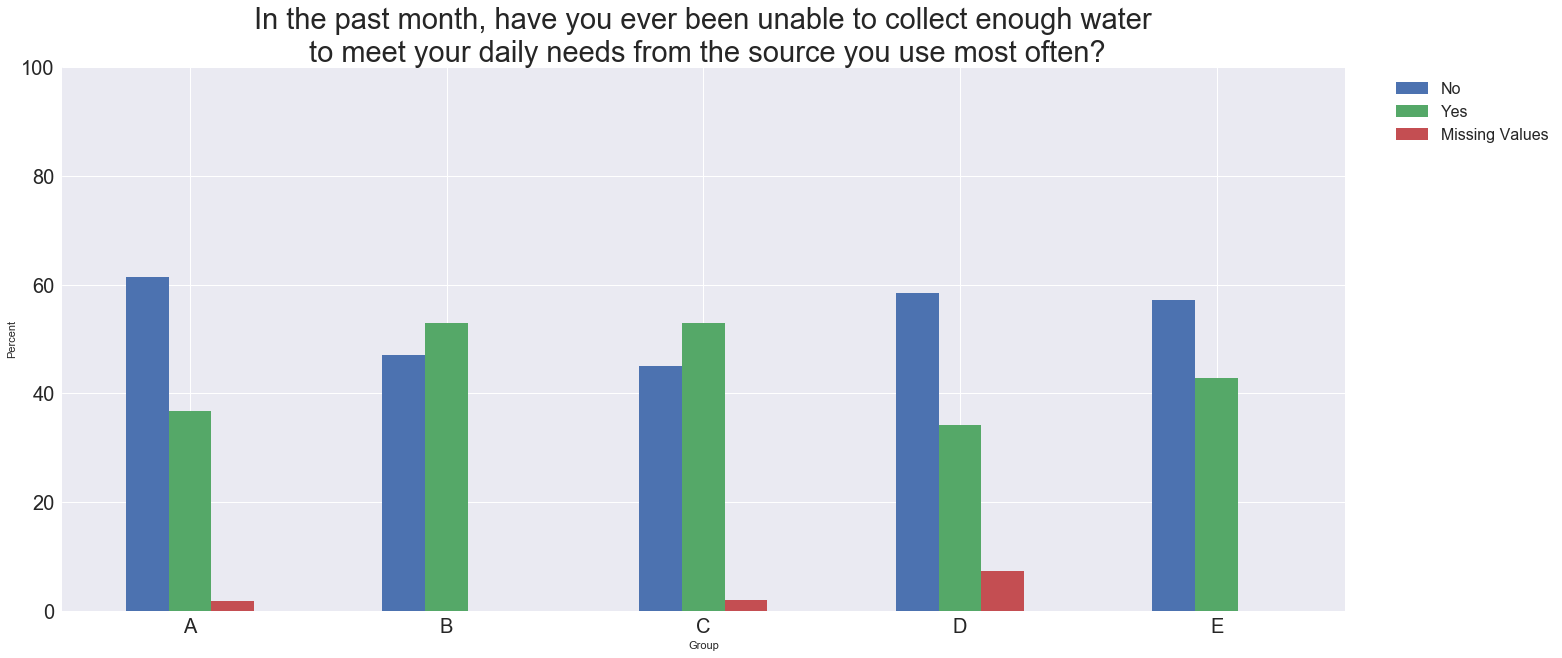

In [75]:
show_diff_for(df_cluster1, 'WaterAvailability', 'In the past month, have you ever been unable to collect enough water\n to meet your daily needs from the source you use most often?', ['No', 'Yes','Missing Values'], (1.17, 1.0))

C:\Program Files\Anaconda3\lib\site-packages\pandas\core\groupby.py:3961: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


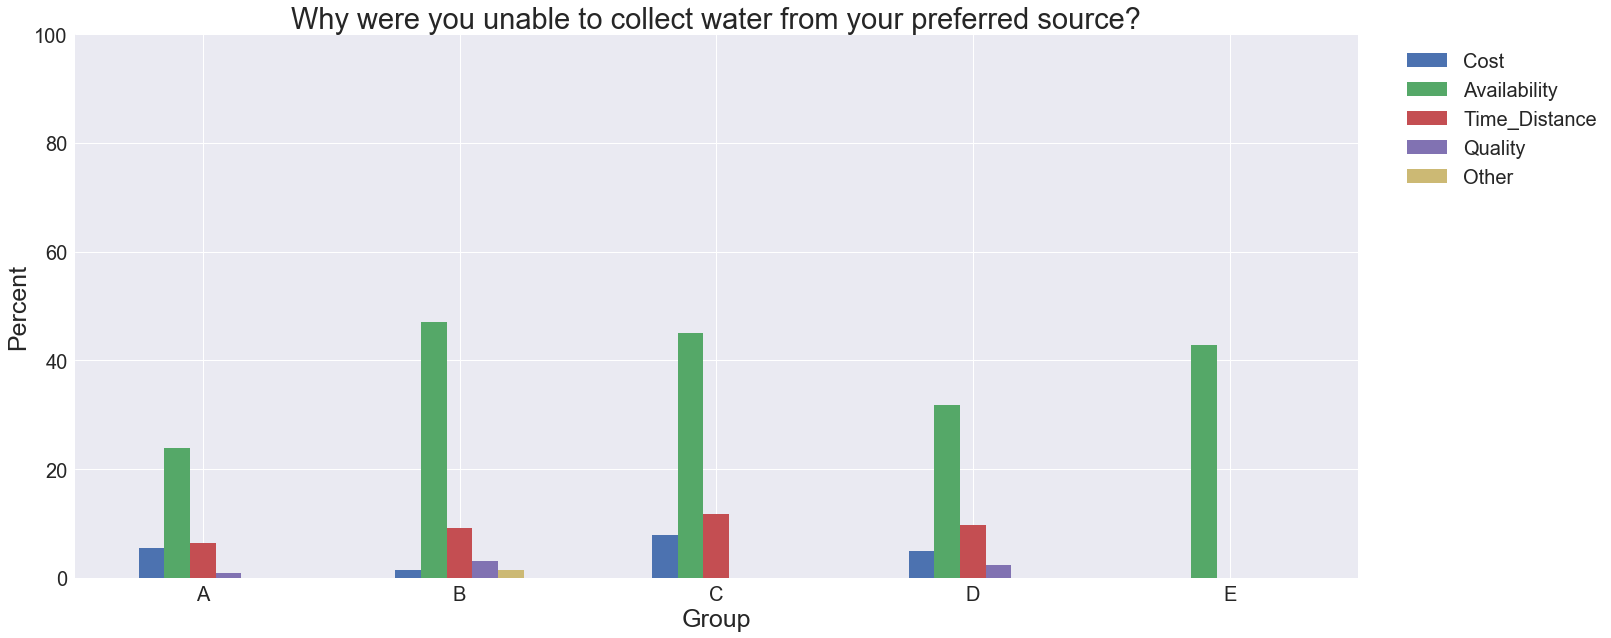

In [76]:
show_water_availability_reasons_diff(df_cluster1, ar, arl)

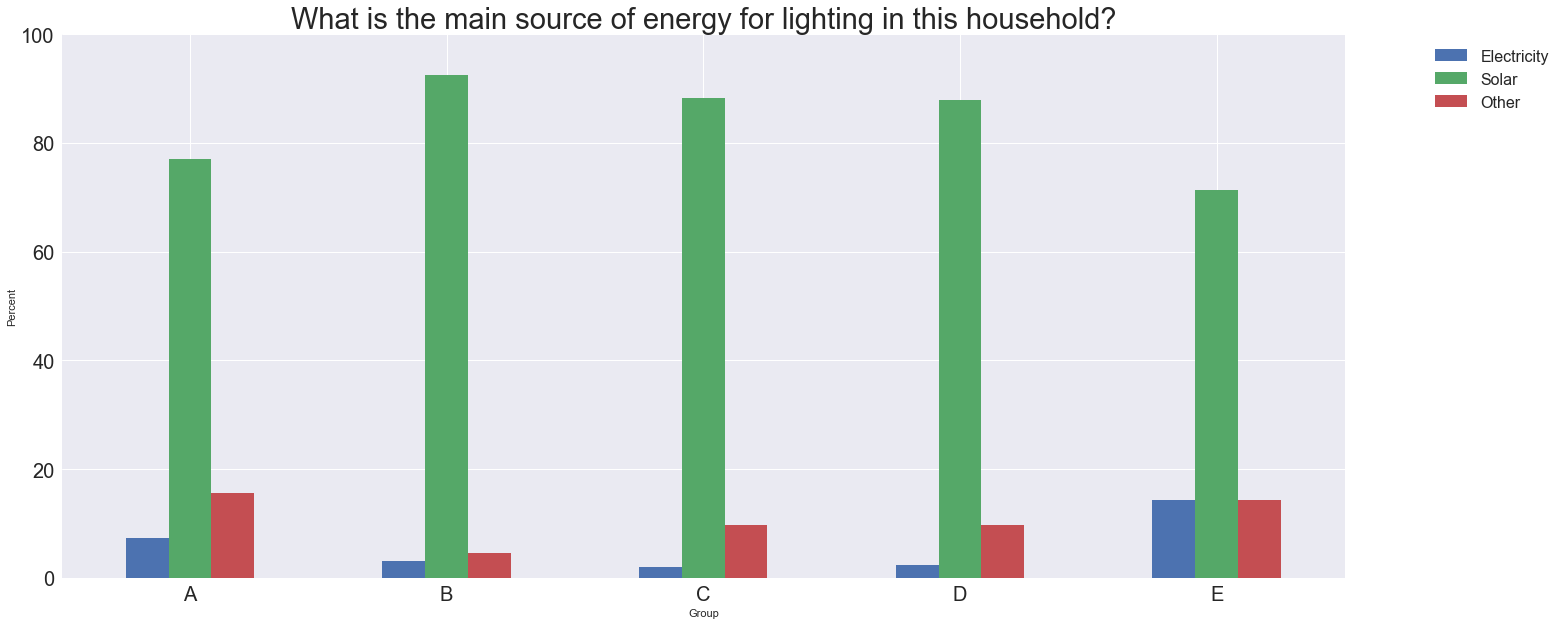

In [77]:
show_diff_for(df_cluster1, 'SourceOfLighting', 'What is the main source of energy for lighting in this household?', ['Electricity', 'Solar','Other'], (1.17, 1.0))

<a id='bl_Chanhomba'></a>
## Chanhomba

In [78]:
df_Chanhomba = df_survey[df_survey.CommName == 'Chanhomba']
df_Chanhomba.shape

(205, 36)

In [79]:
df20 = df_Chanhomba.copy()
df21 = df20[['Phone_Number', 'AmountOfWater', 'WaterExpenditure', 'Gender', 'Farming', 'AnimalRaising', 'PrimarySource', 'WaterAvailability', 'PowerSource', 'BankAccount', 'FloorMaterial', 'RudWI']]
df22 = df21.dropna()
df22.shape

(204, 12)

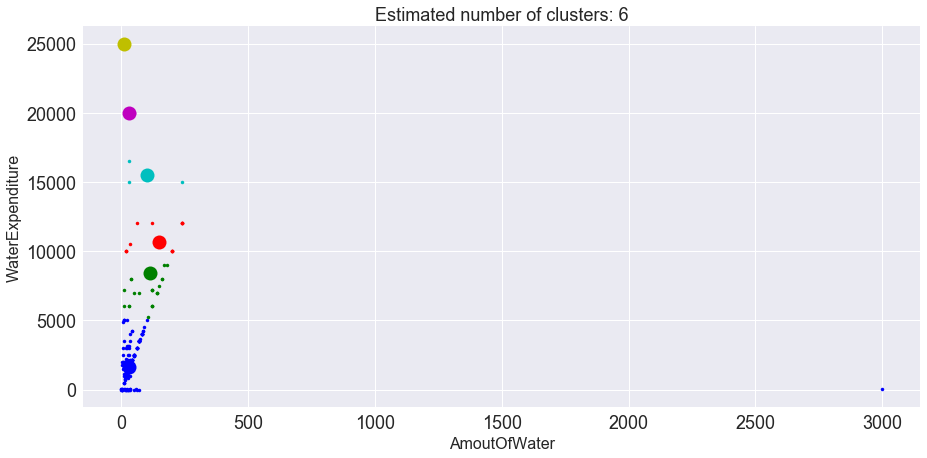

In [80]:
x_array2, labels2, cluster_centers2 = find_clusters(df22)
draw_clusters_plot(x_array2, labels2, cluster_centers2)

In [81]:
df_processed2 = df22.copy()
df_processed2['ClusterClass'] = pd.Series(labels2, index=df_processed2.index)
df_cc2 = df_processed2[['Phone_Number','ClusterClass']]
df_cluster2 = df20.merge(df_cc2, left_index=True, right_index=True, how = 'left')
df_cluster2 = df_cluster2[~np.isnan(df_cluster2.ClusterClass)]
df_cluster2 = df_cluster2[df_cluster2.ClusterClass != 5]
df_cluster2['Group'] = df_cluster2.ClusterClass.apply(lambda a: pos_to_char(a))
df_cluster2['AgeGroup'] = df_cluster2.Age.apply(lambda a: get_age_group(a))
df_cluster2.shape

(203, 40)

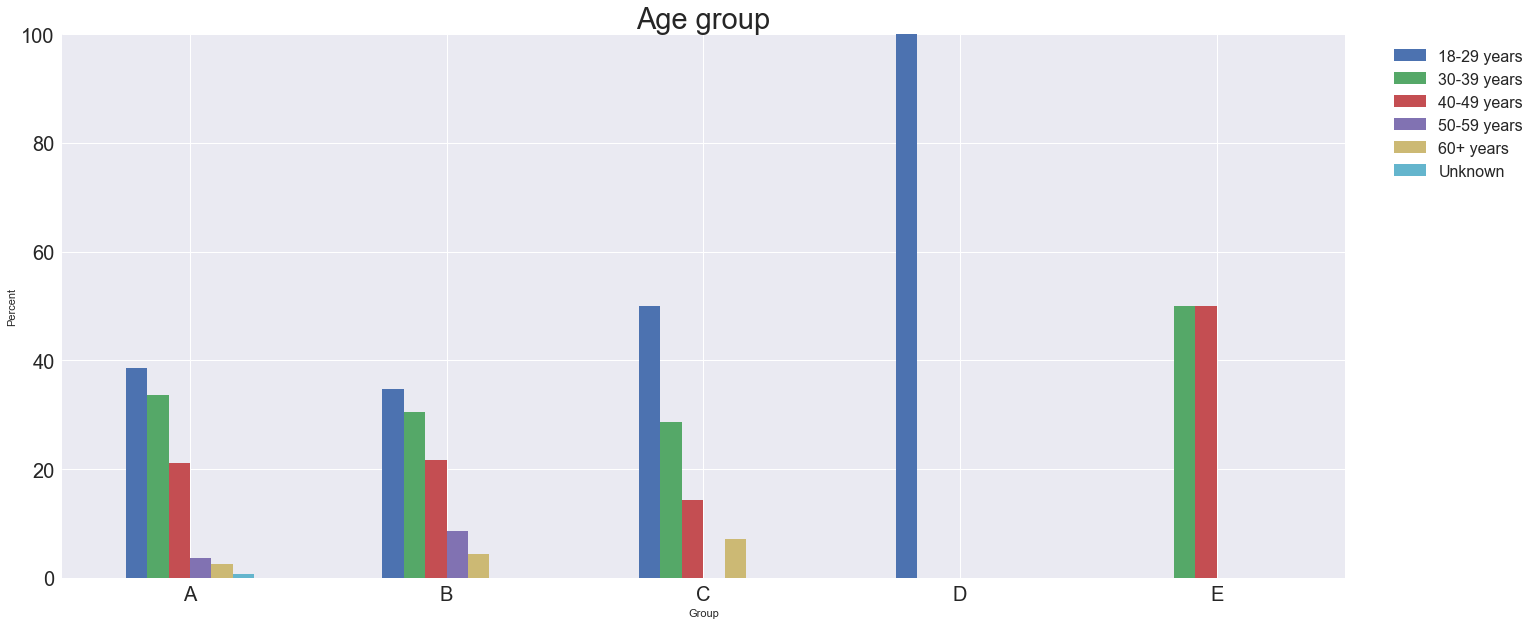

In [82]:
show_diff_for(df_cluster2, 'AgeGroup', 'Age group', [], (1.15, 1.0))

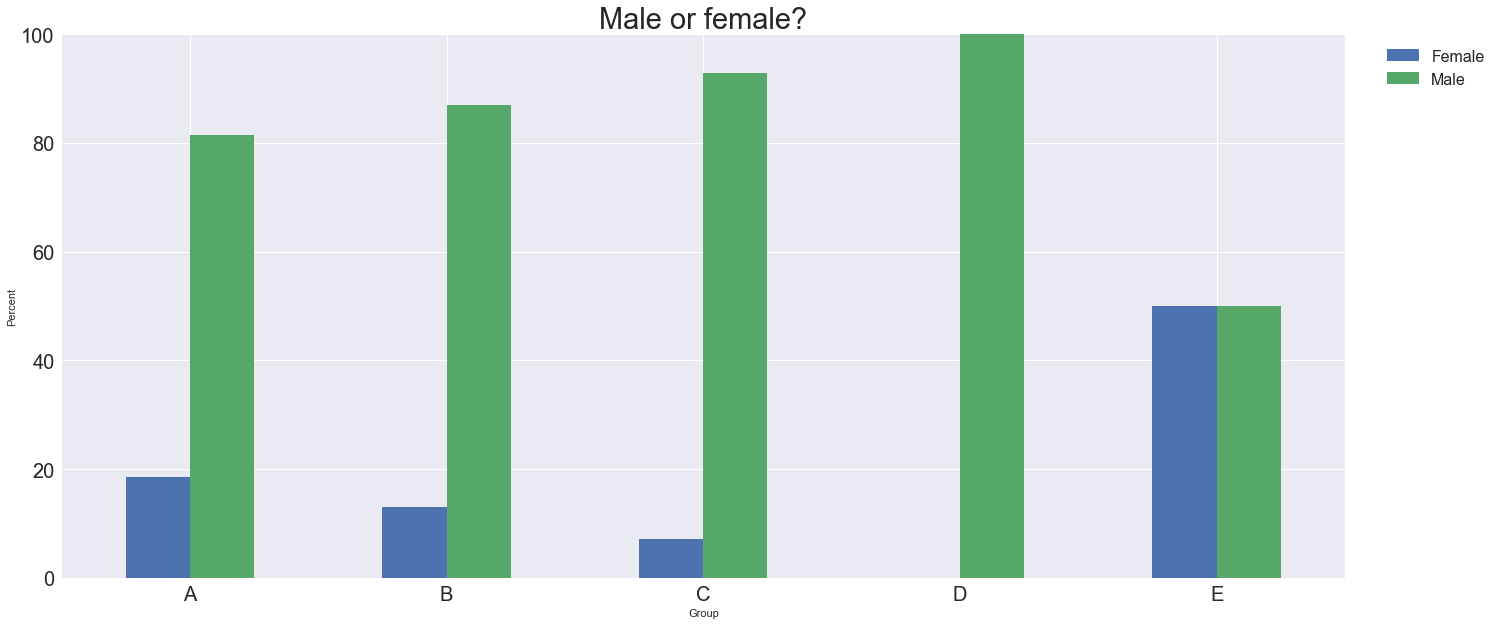

In [83]:
show_diff_for(df_cluster2, 'Gender', 'Male or female?', ['Female', 'Male'], (1.12, 1.0))

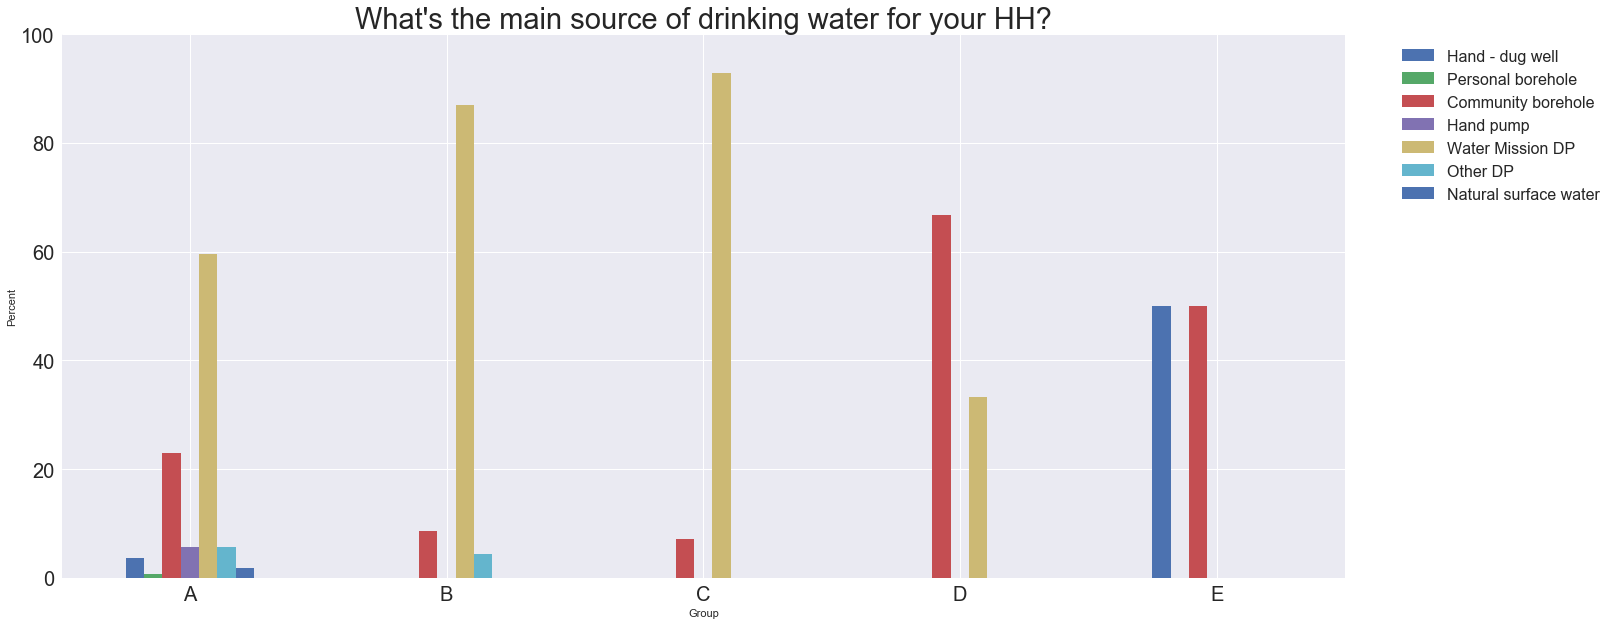

In [84]:
source_of_water =['Hand - dug well', 'Personal borehole', 'Community borehole', 'Hand pump', 'Water Mission DP', 'Other DP', 'Natural surface water' ]
show_diff_for(df_cluster2, 'PrimarySource', "What's the main source of drinking water for your HH?", source_of_water, (1.21, 1.0))

C:\Program Files\Anaconda3\lib\site-packages\pandas\core\groupby.py:3961: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


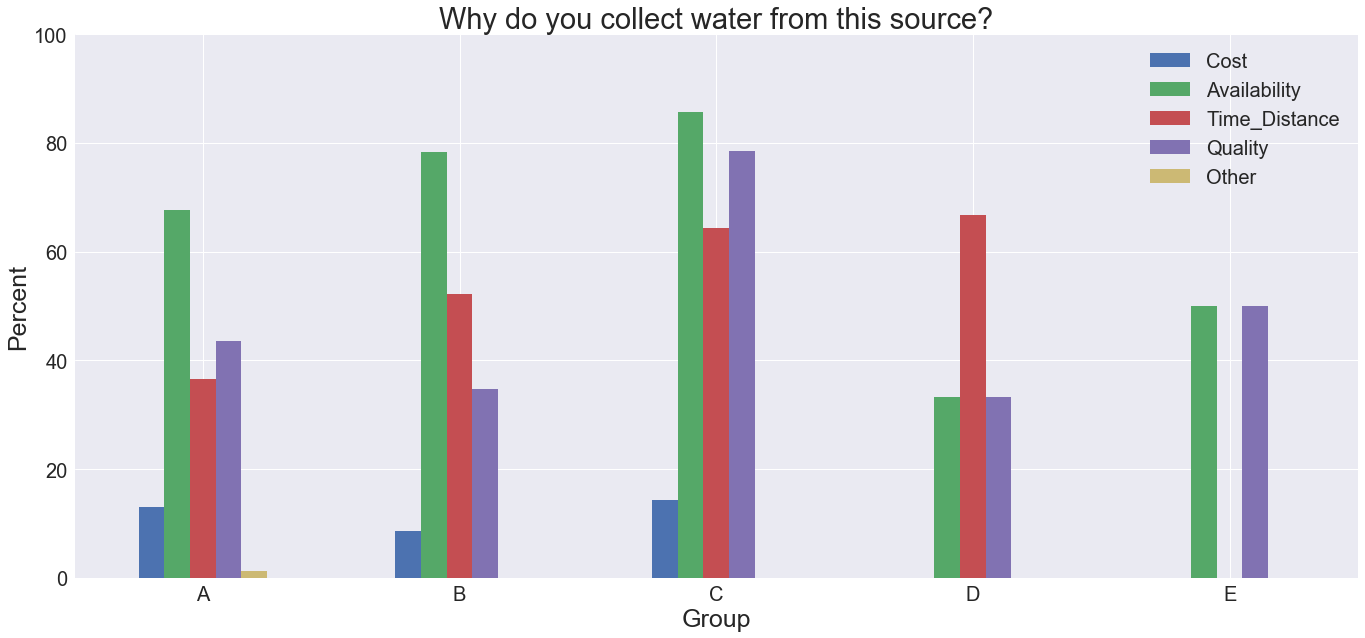

In [85]:
show_reasons_diff(df_cluster2, ['Cost', 'Availability', 'Time_Distance', 'Quality', 'Other'], (1, 1))

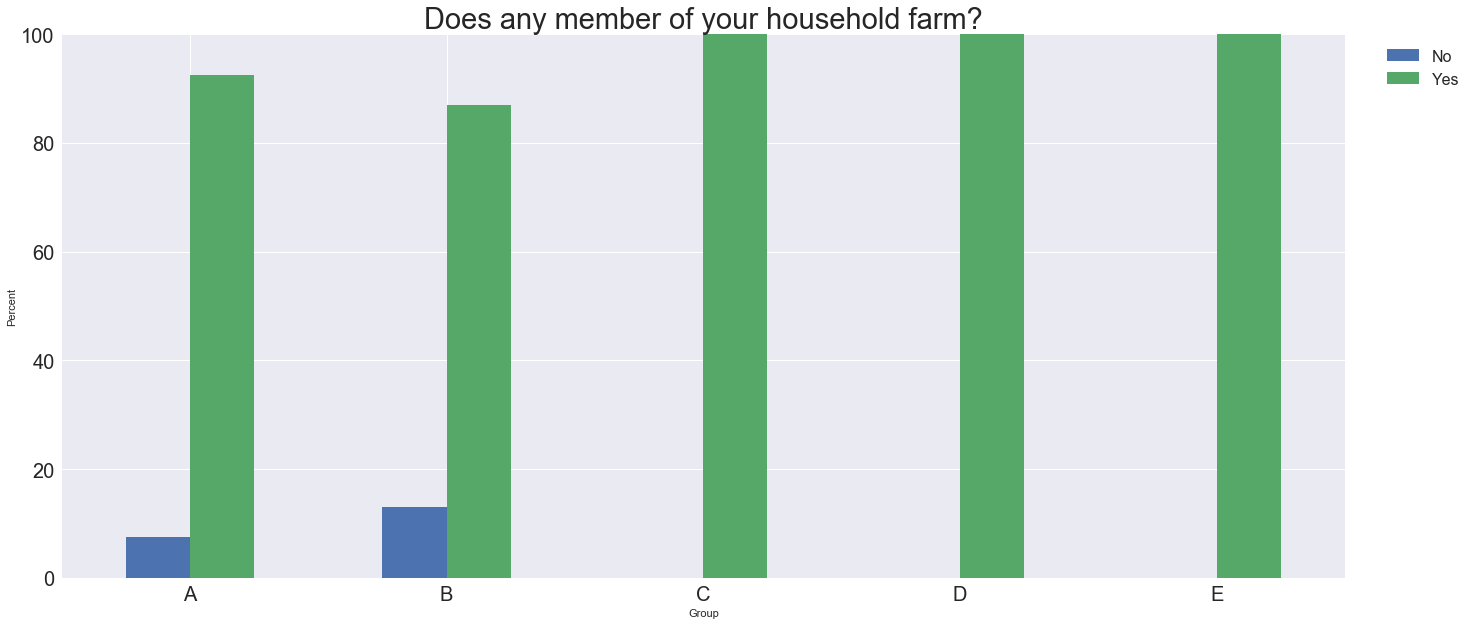

In [86]:
show_diff_for(df_cluster2, 'Farming', 'Does any member of your household farm?', ['No', 'Yes'], (1.1, 1.0))

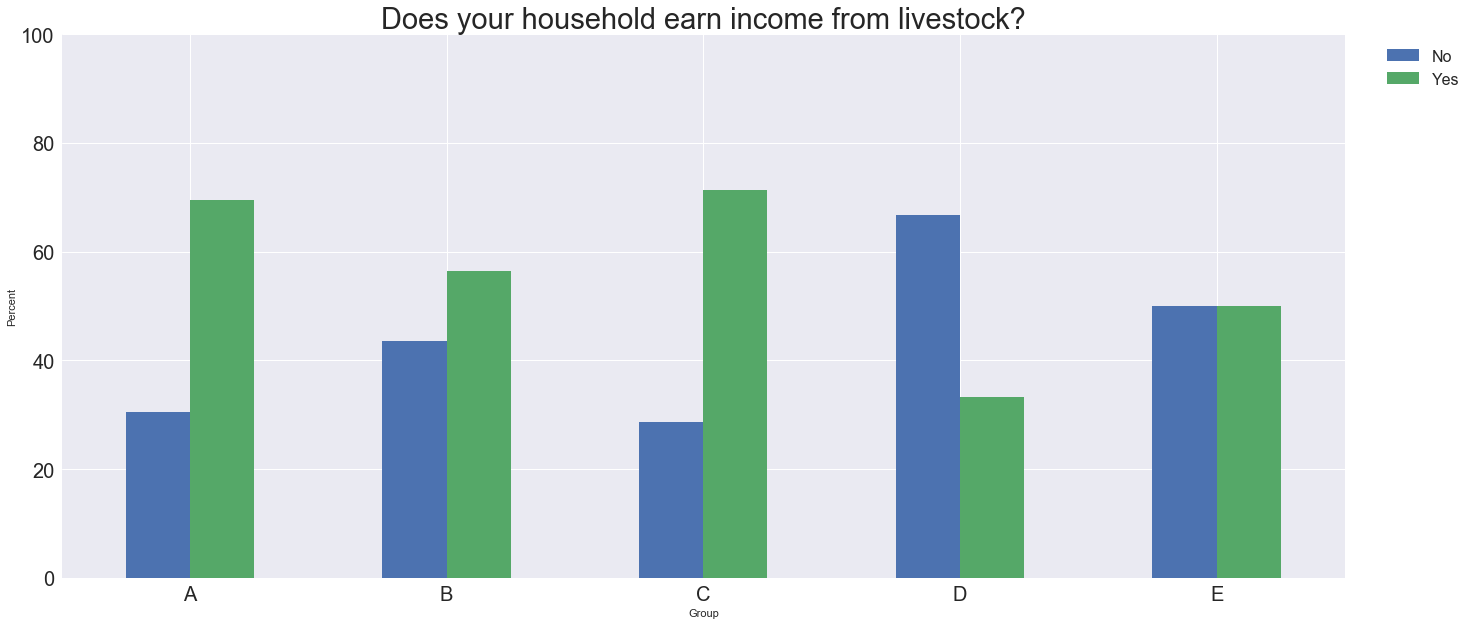

In [87]:
show_diff_for(df_cluster2, 'AnimalRaising', 'Does your household earn income from livestock?', ['No', 'Yes'], (1.1, 1.0))

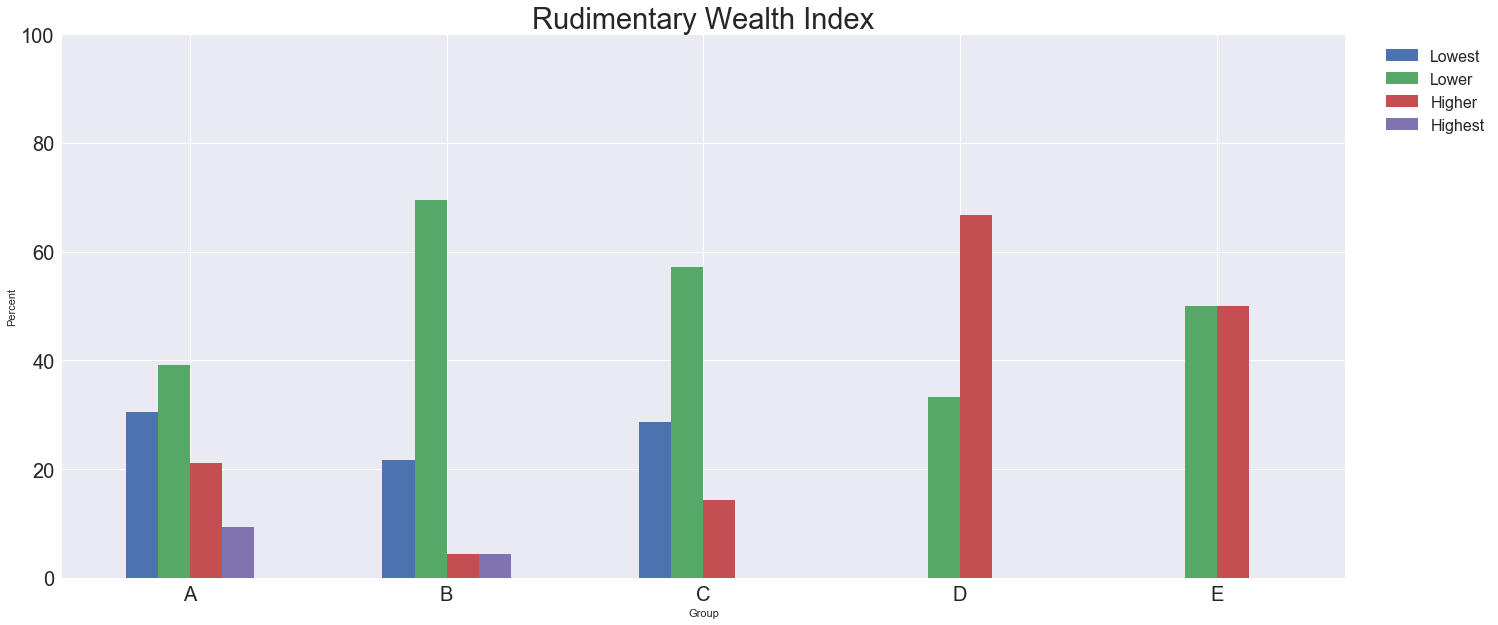

In [88]:
show_diff_for(df_cluster2, 'RudWI', 'Rudimentary Wealth Index', ['Lowest', 'Lower', 'Higher', 'Highest'], (1.12, 1.0))

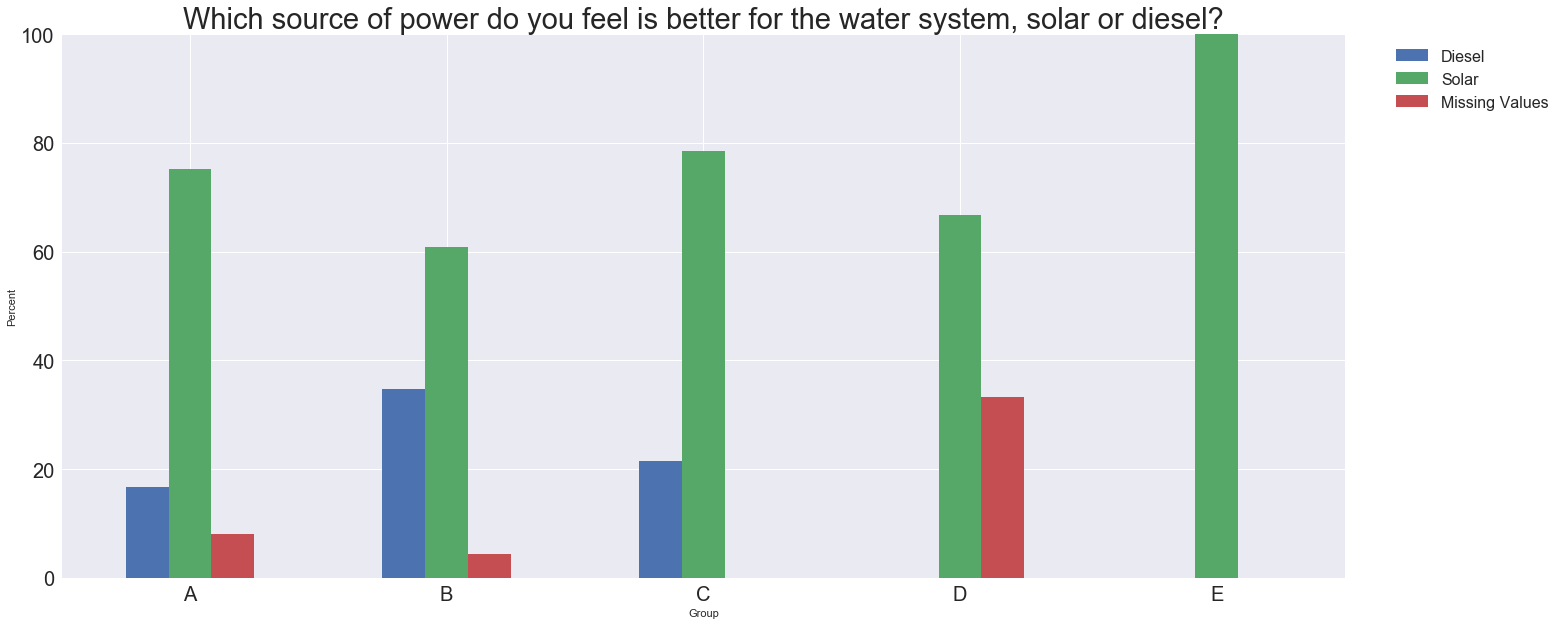

In [89]:
show_diff_for(df_cluster2, 'PowerSource', 'Which source of power do you feel is better for the water system, solar or diesel?', ['Diesel', 'Solar','Missing Values'], (1.17, 1.0))

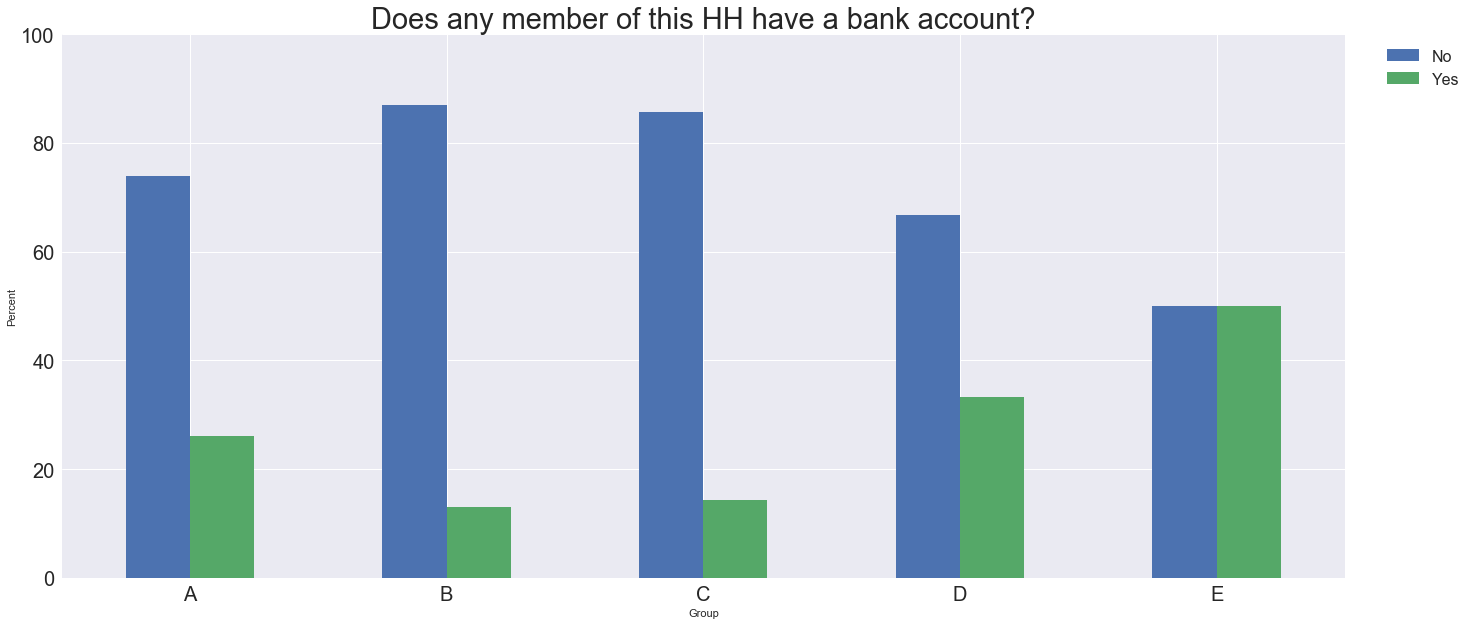

In [90]:
show_diff_for(df_cluster2, 'BankAccount', 'Does any member of this HH have a bank account?', ['No', 'Yes'], (1.1, 1.0))

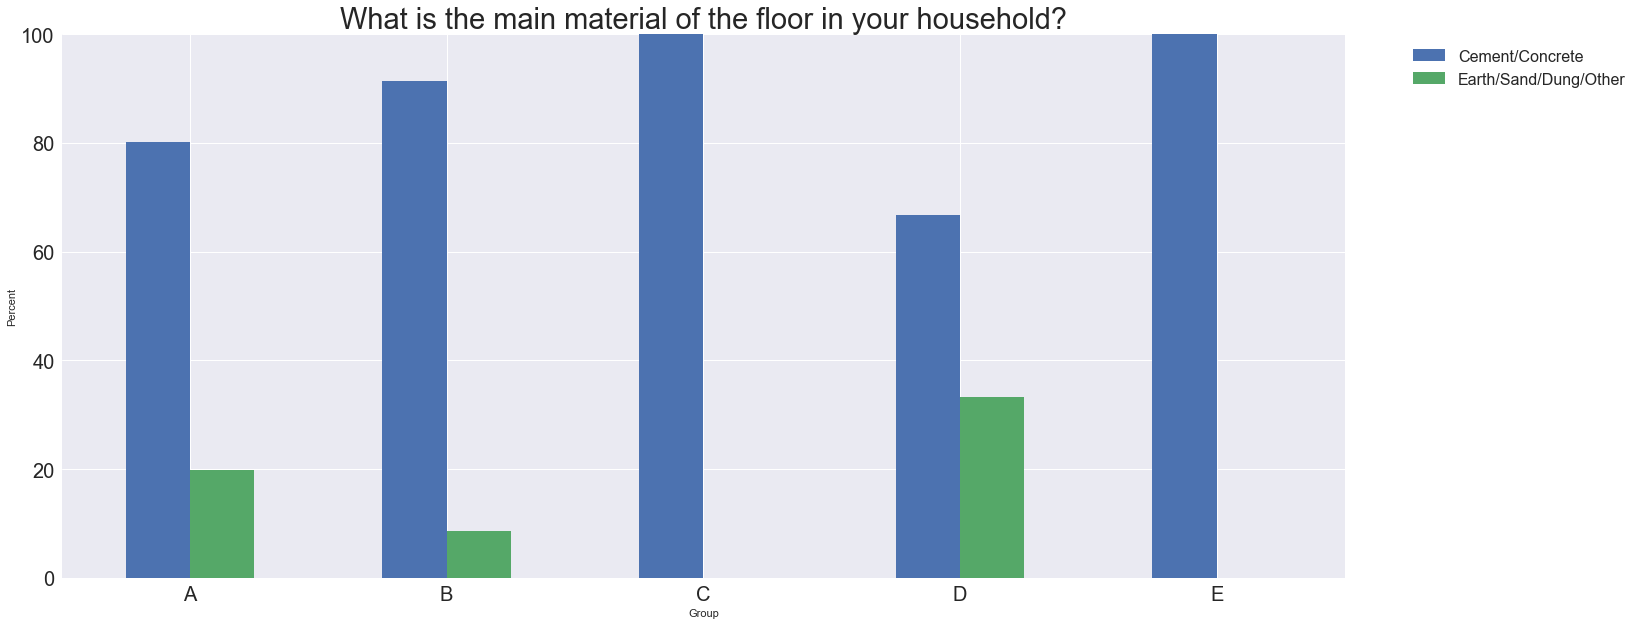

In [91]:
show_diff_for(df_cluster2, 'FloorMaterial', 'What is the main material of the floor in your household?', ['Cement/Concrete', 'Earth/Sand/Dung/Other'], (1.23, 1.0))

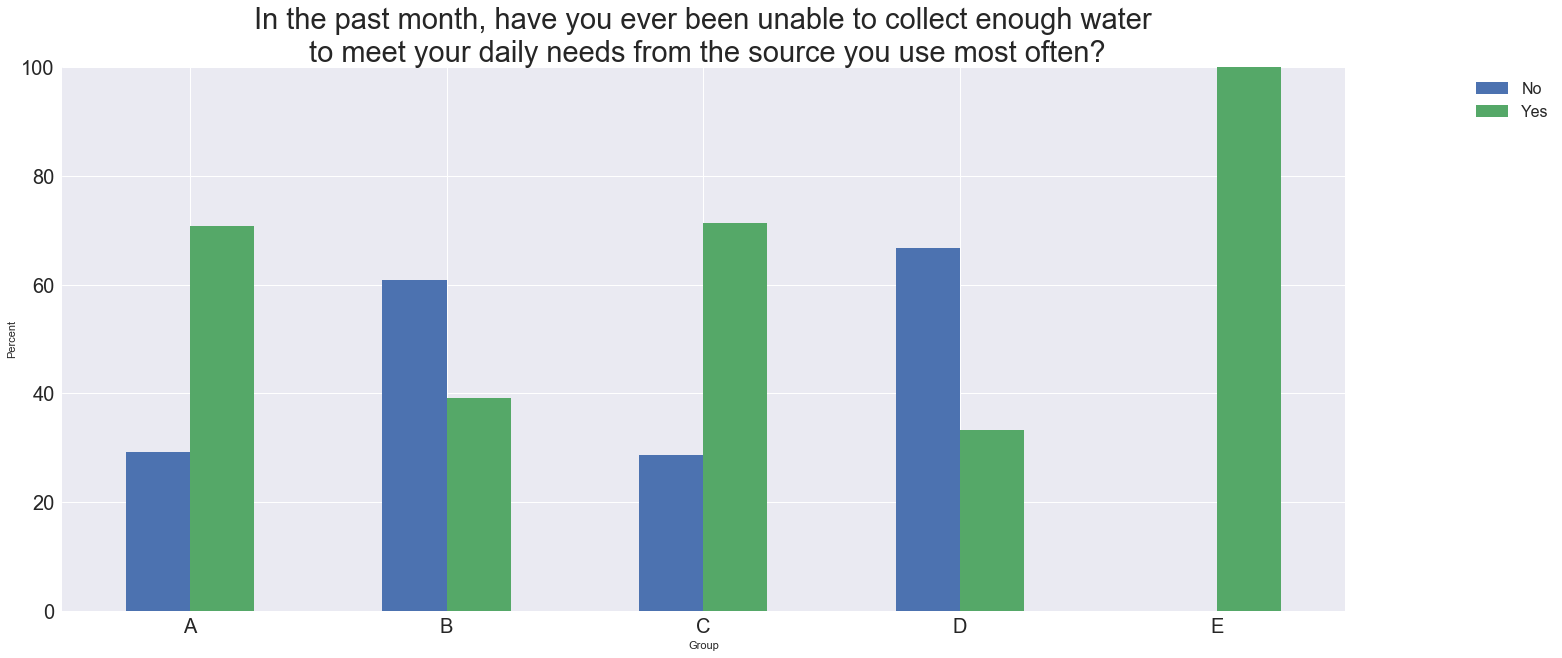

In [92]:
show_diff_for(df_cluster2, 'WaterAvailability', 'In the past month, have you ever been unable to collect enough water\n to meet your daily needs from the source you use most often?', ['No', 'Yes'], (1.17, 1.0))

C:\Program Files\Anaconda3\lib\site-packages\pandas\core\groupby.py:3961: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


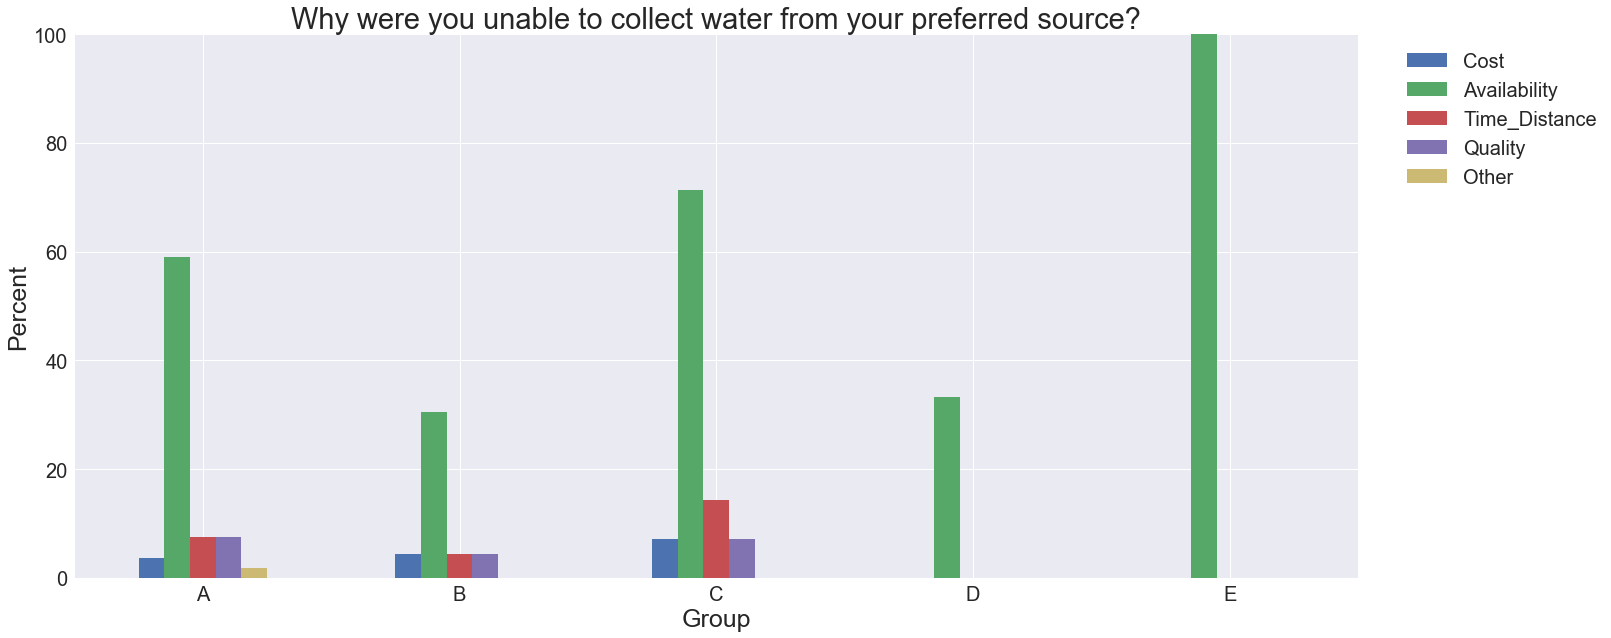

In [93]:
show_water_availability_reasons_diff(df_cluster2, ar, arl)

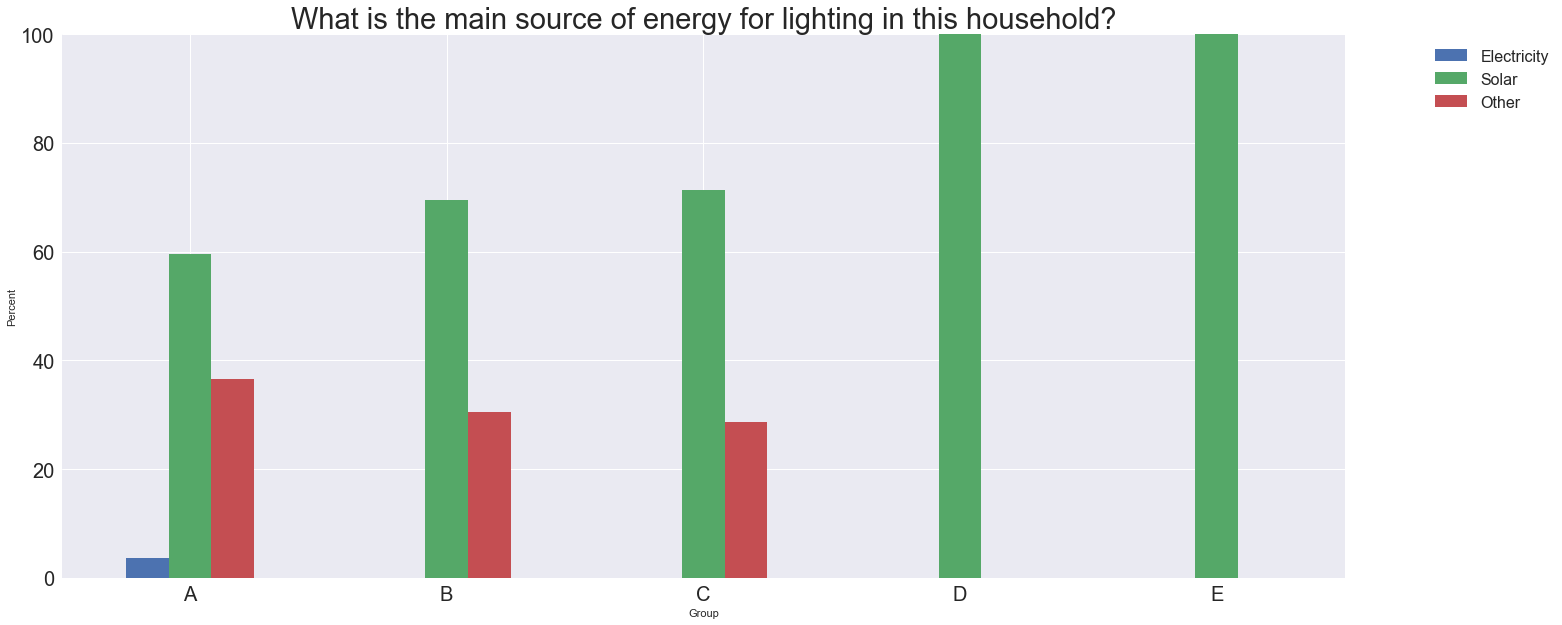

In [94]:
show_diff_for(df_cluster2, 'SourceOfLighting', 'What is the main source of energy for lighting in this household?', ['Electricity', 'Solar','Other'], (1.17, 1.0))

<a id='bl_Gidewari'></a>
## Gidewari

In [95]:
df_Gidewari = df_survey[df_survey.CommName == 'Gidewari']
df_Gidewari.shape

(122, 36)

In [96]:
df30 = df_Gidewari.copy()
df31 = df30[['Phone_Number', 'AmountOfWater', 'WaterExpenditure', 'Gender', 'Farming', 'AnimalRaising', 'PrimarySource', 'WaterAvailability', 'PowerSource', 'BankAccount', 'FloorMaterial', 'RudWI']]
df32 = df31.dropna()
df32.shape

(121, 12)

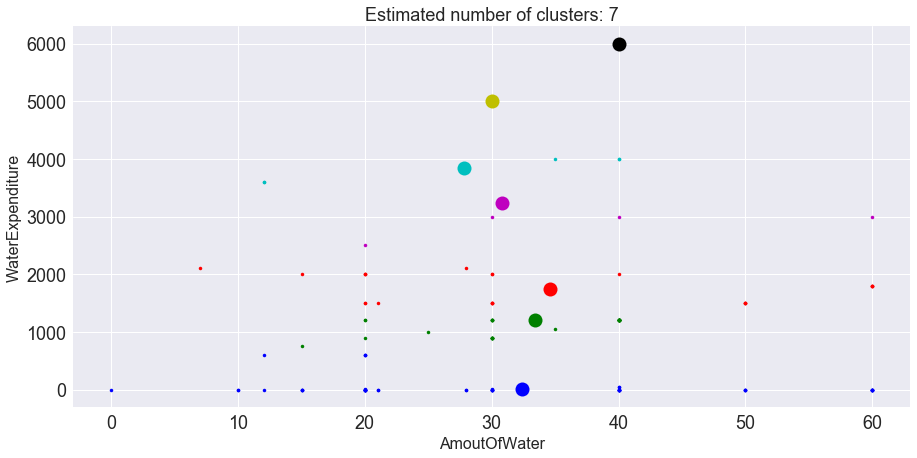

In [97]:
x_array3, labels3, cluster_centers3 = find_clusters(df32)
draw_clusters_plot(x_array3, labels3, cluster_centers3)

In [98]:
df_processed3 = df32.copy()
df_processed3['ClusterClass'] = pd.Series(labels3, index=df_processed3.index)
df_cc3 = df_processed3[['Phone_Number','ClusterClass']]
df_cluster3 = df30.merge(df_cc3, left_index=True, right_index=True, how = 'left')
df_cluster3 = df_cluster3[~np.isnan(df_cluster3.ClusterClass)]
df_cluster3 = df_cluster3[df_cluster3.ClusterClass != 5]
df_cluster3 = df_cluster3[df_cluster3.ClusterClass != 6]
df_cluster3.loc[df_cluster3['ClusterClass'] == 3, 'ClusterClass'] = 33
df_cluster3.loc[df_cluster3['ClusterClass'] == 4, 'ClusterClass'] = 44
df_cluster3.loc[df_cluster3['ClusterClass'] == 44, 'ClusterClass'] = 3
df_cluster3.loc[df_cluster3['ClusterClass'] == 33, 'ClusterClass'] = 4
df_cluster3['Group'] = df_cluster3.ClusterClass.apply(lambda a: pos_to_char(a))
df_cluster3['AgeGroup'] = df_cluster3.Age.apply(lambda a: get_age_group(a))
df_cluster3.shape

(119, 40)

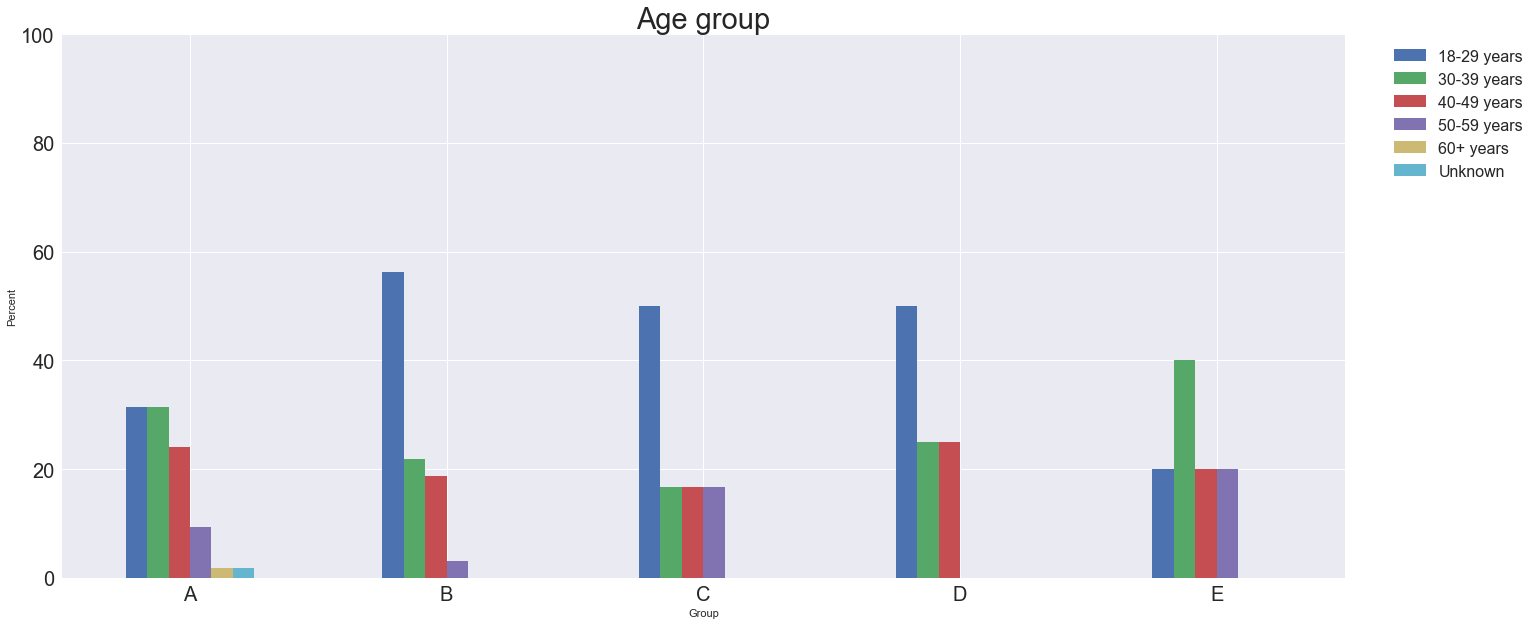

In [99]:
show_diff_for(df_cluster3, 'AgeGroup', 'Age group', [], (1.15, 1.0))

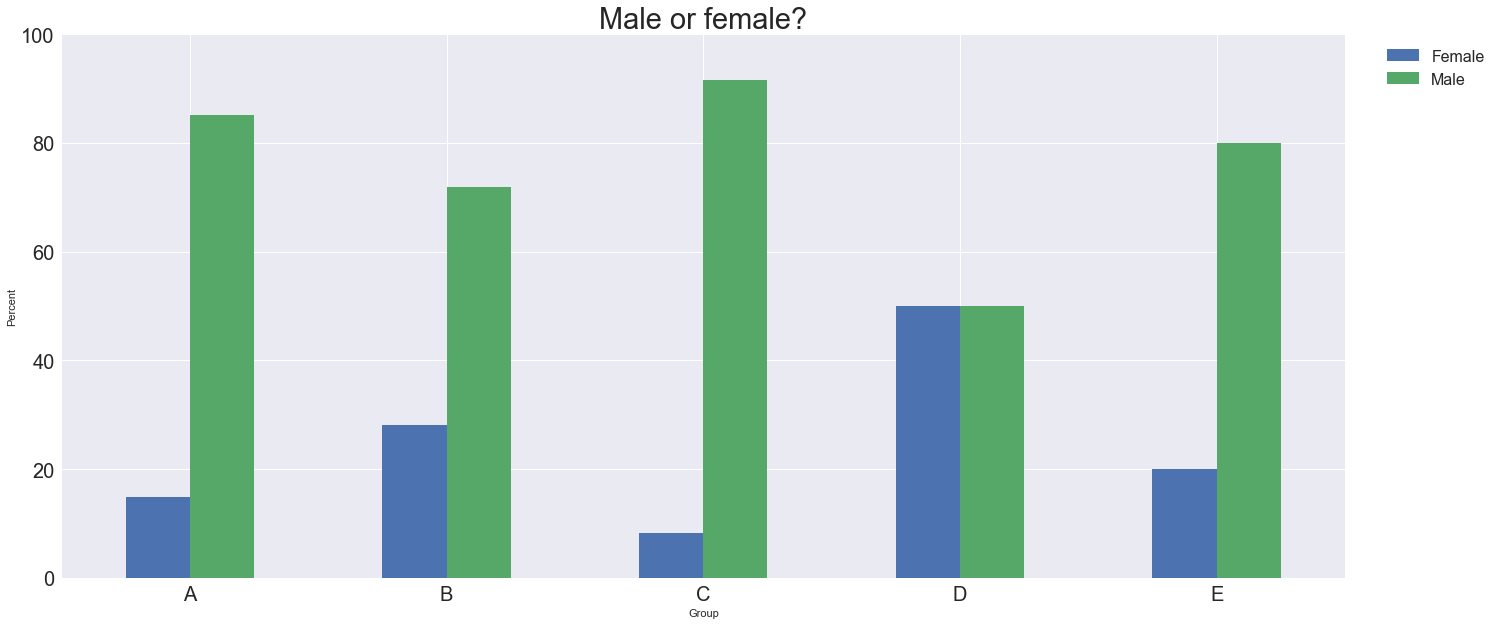

In [100]:
show_diff_for(df_cluster3, 'Gender', 'Male or female?', ['Female', 'Male'], (1.12, 1.0))

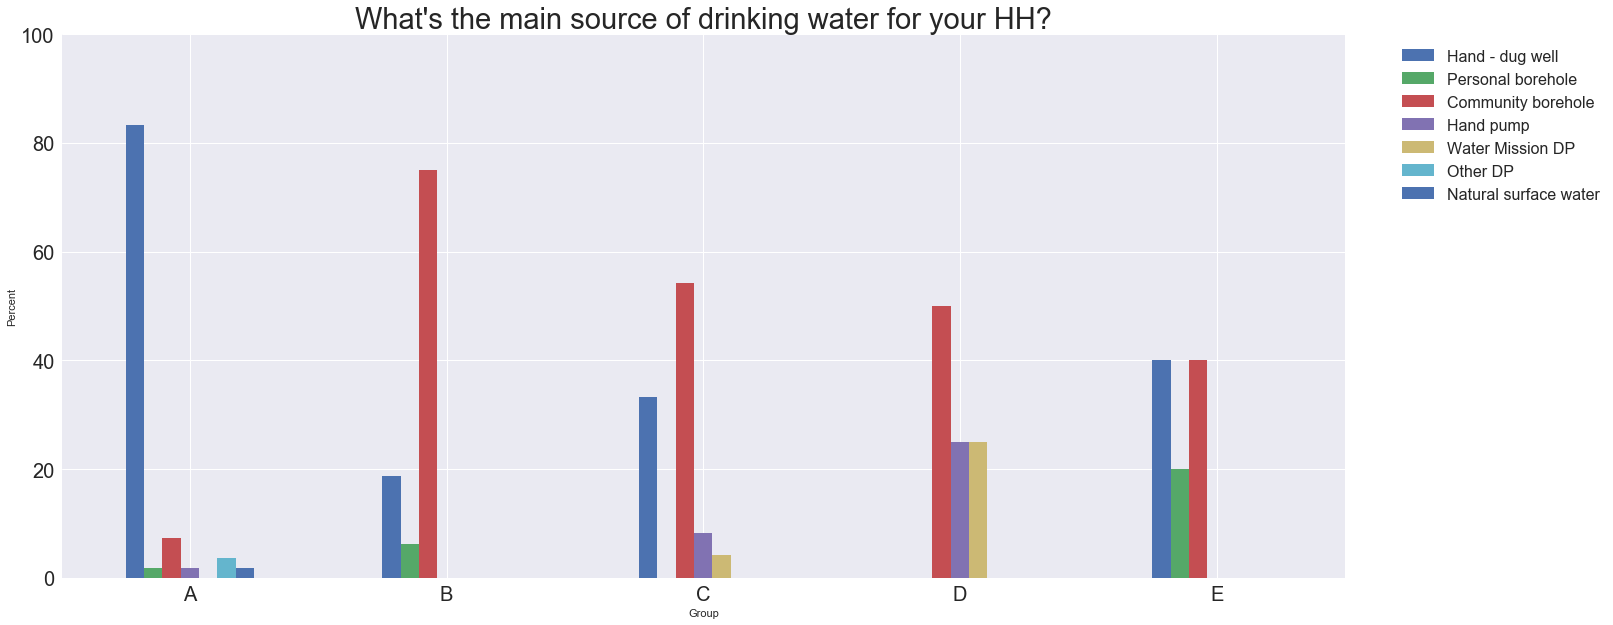

In [101]:
source_of_water =['Hand - dug well', 'Personal borehole', 'Community borehole', 'Hand pump', 'Water Mission DP',
                  'Other DP', 'Natural surface water' ]
show_diff_for(df_cluster3, 'PrimarySource', "What's the main source of drinking water for your HH?", source_of_water, (1.21, 1.0))

C:\Program Files\Anaconda3\lib\site-packages\pandas\core\groupby.py:3961: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


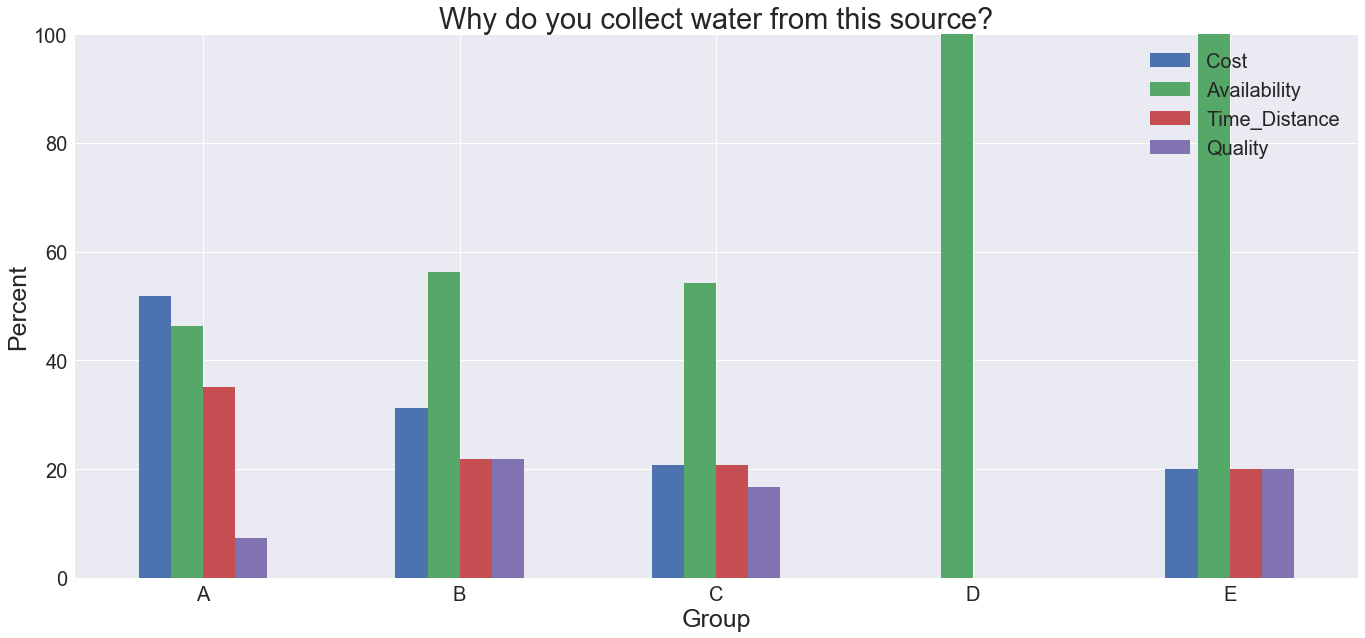

In [102]:
show_reasons_diff(df_cluster3, ['Cost', 'Availability', 'Time_Distance', 'Quality'], (1,1))

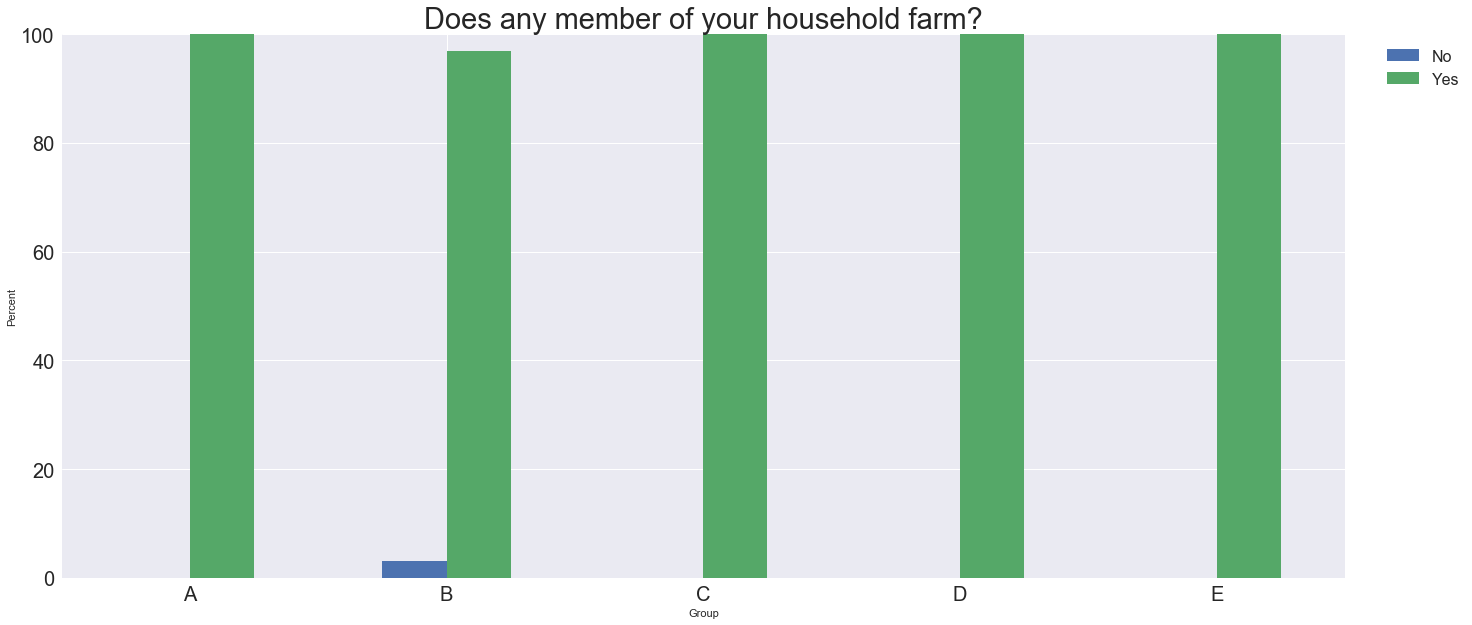

In [103]:
show_diff_for(df_cluster3, 'Farming', 'Does any member of your household farm?', ['No', 'Yes'], (1.1, 1.0))

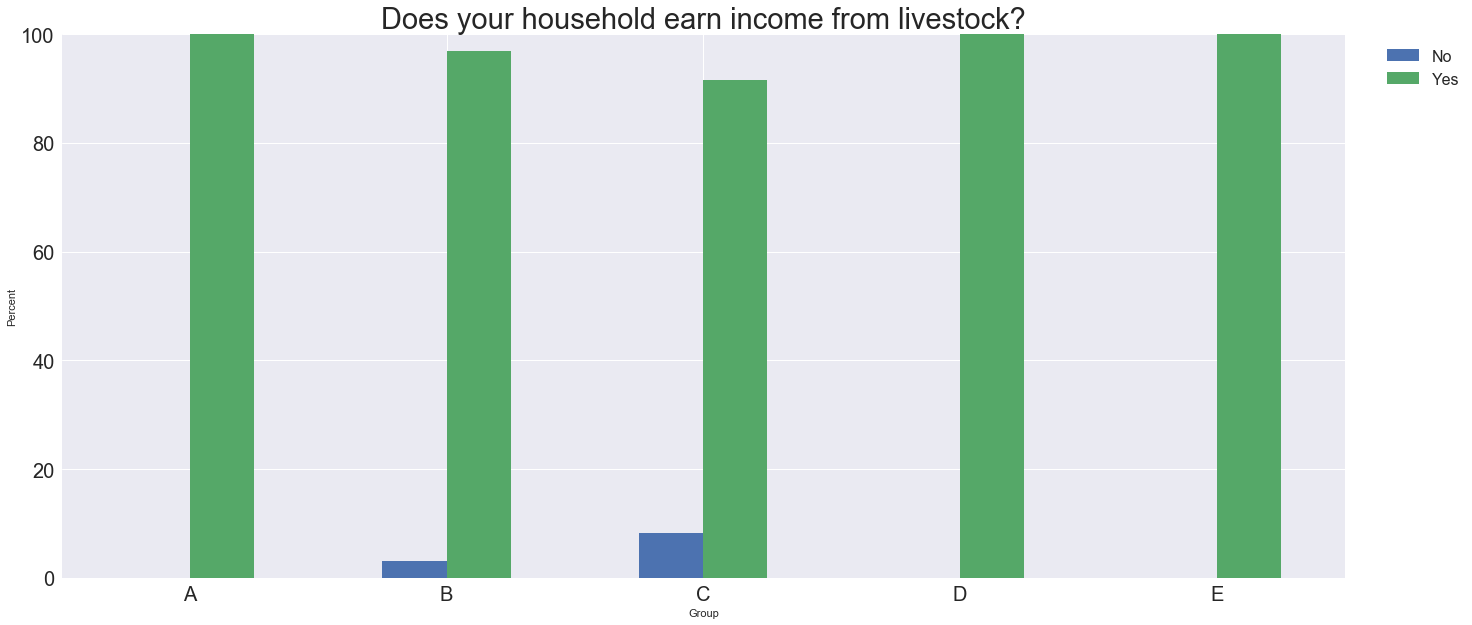

In [104]:
show_diff_for(df_cluster3, 'AnimalRaising', 'Does your household earn income from livestock?', ['No', 'Yes'], (1.1, 1.0))

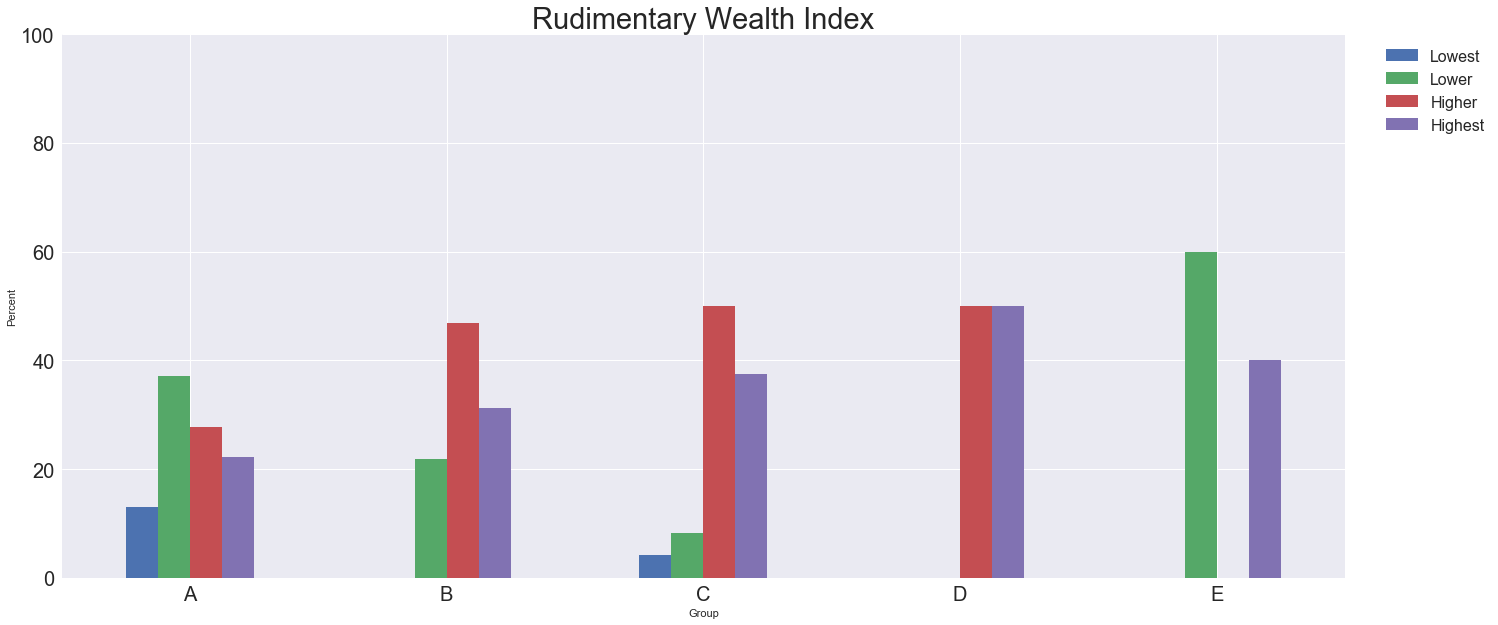

In [105]:
show_diff_for(df_cluster3, 'RudWI', 'Rudimentary Wealth Index', ['Lowest', 'Lower', 'Higher', 'Highest'], (1.12, 1.0))

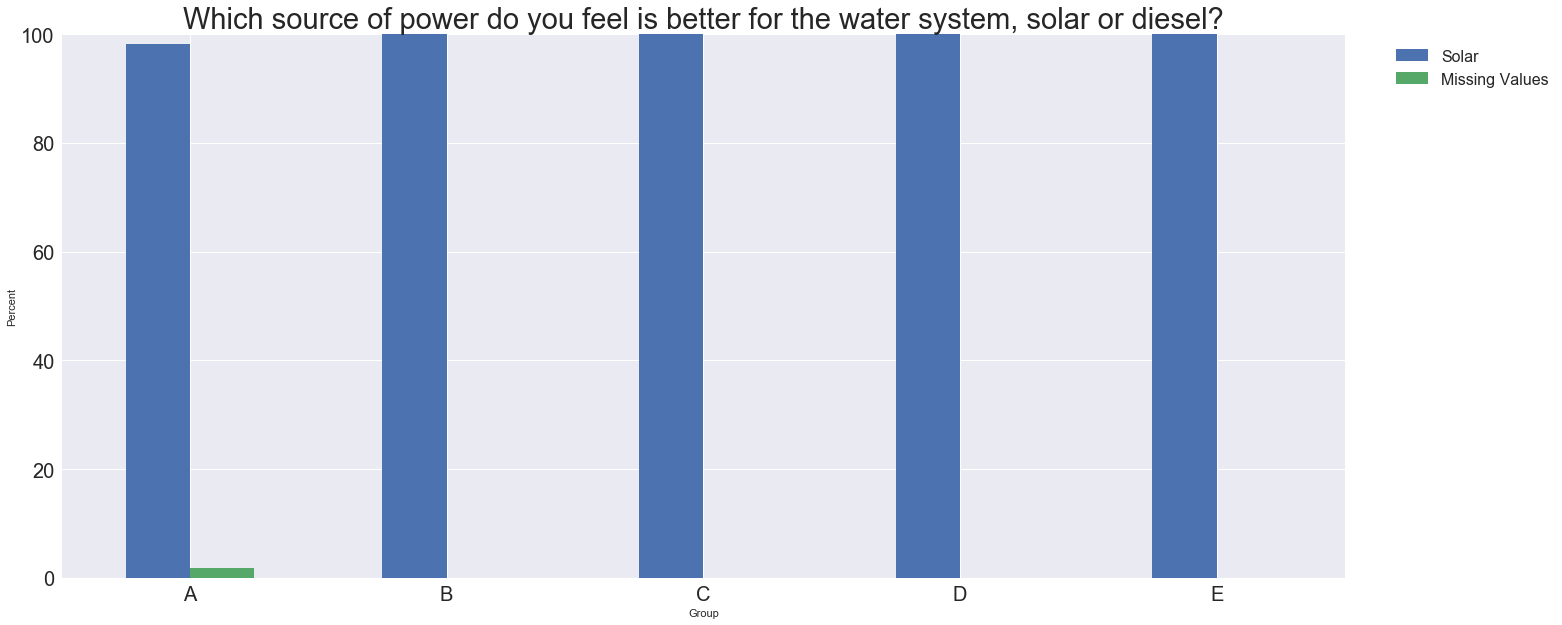

In [106]:
show_diff_for(df_cluster3, 'PowerSource', 'Which source of power do you feel is better for the water system, solar or diesel?', ['Solar','Missing Values'], (1.17, 1.0))

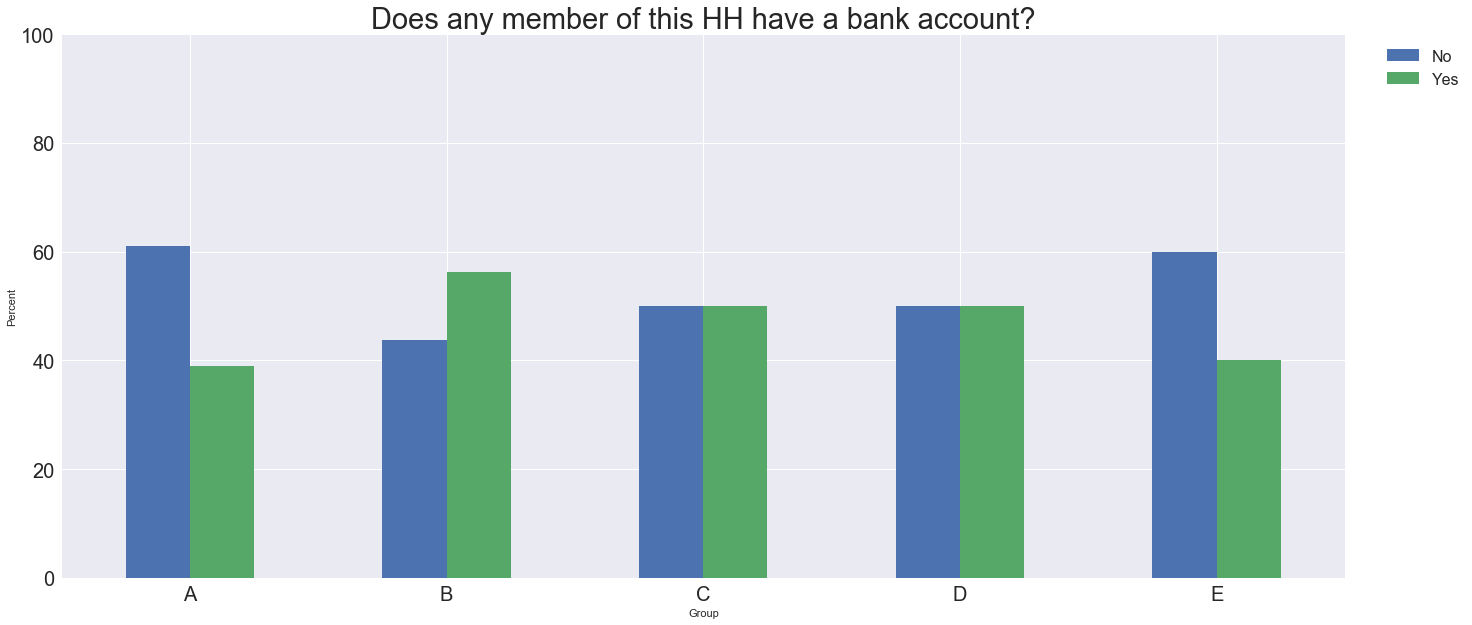

In [107]:
show_diff_for(df_cluster3, 'BankAccount', 'Does any member of this HH have a bank account?', ['No', 'Yes'], (1.1, 1.0))

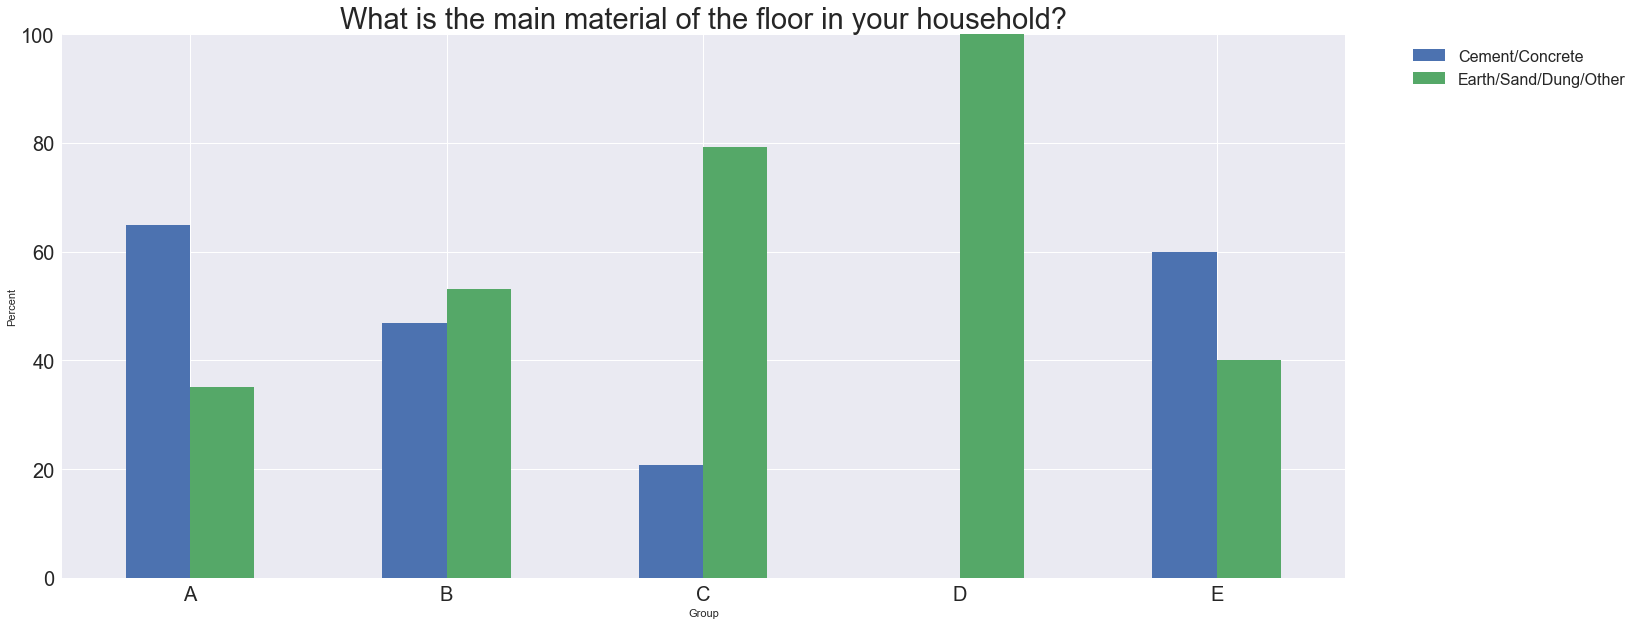

In [108]:
show_diff_for(df_cluster3, 'FloorMaterial', 'What is the main material of the floor in your household?', ['Cement/Concrete', 'Earth/Sand/Dung/Other'], (1.23, 1.0))

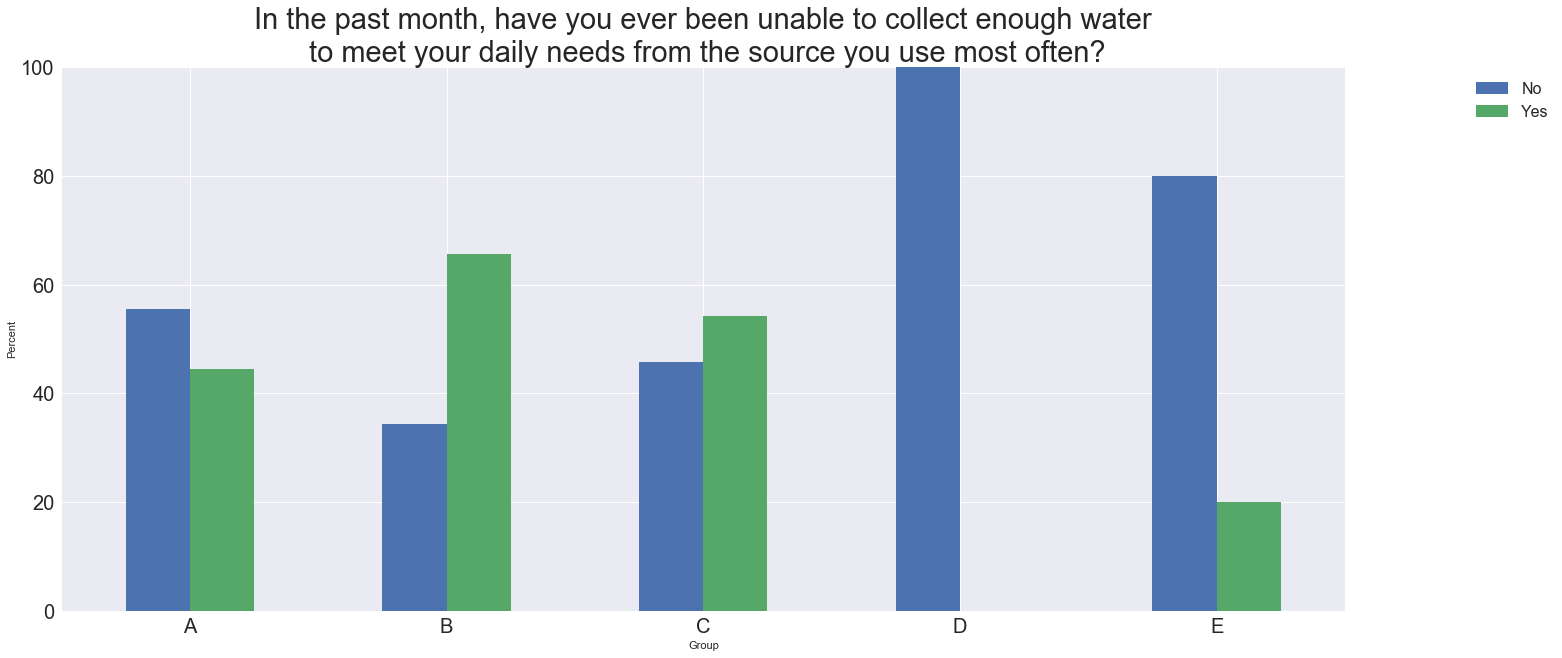

In [109]:
show_diff_for(df_cluster3, 'WaterAvailability', 'In the past month, have you ever been unable to collect enough water\n to meet your daily needs from the source you use most often?', ['No', 'Yes'], (1.17, 1.0))

C:\Program Files\Anaconda3\lib\site-packages\pandas\core\groupby.py:3961: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


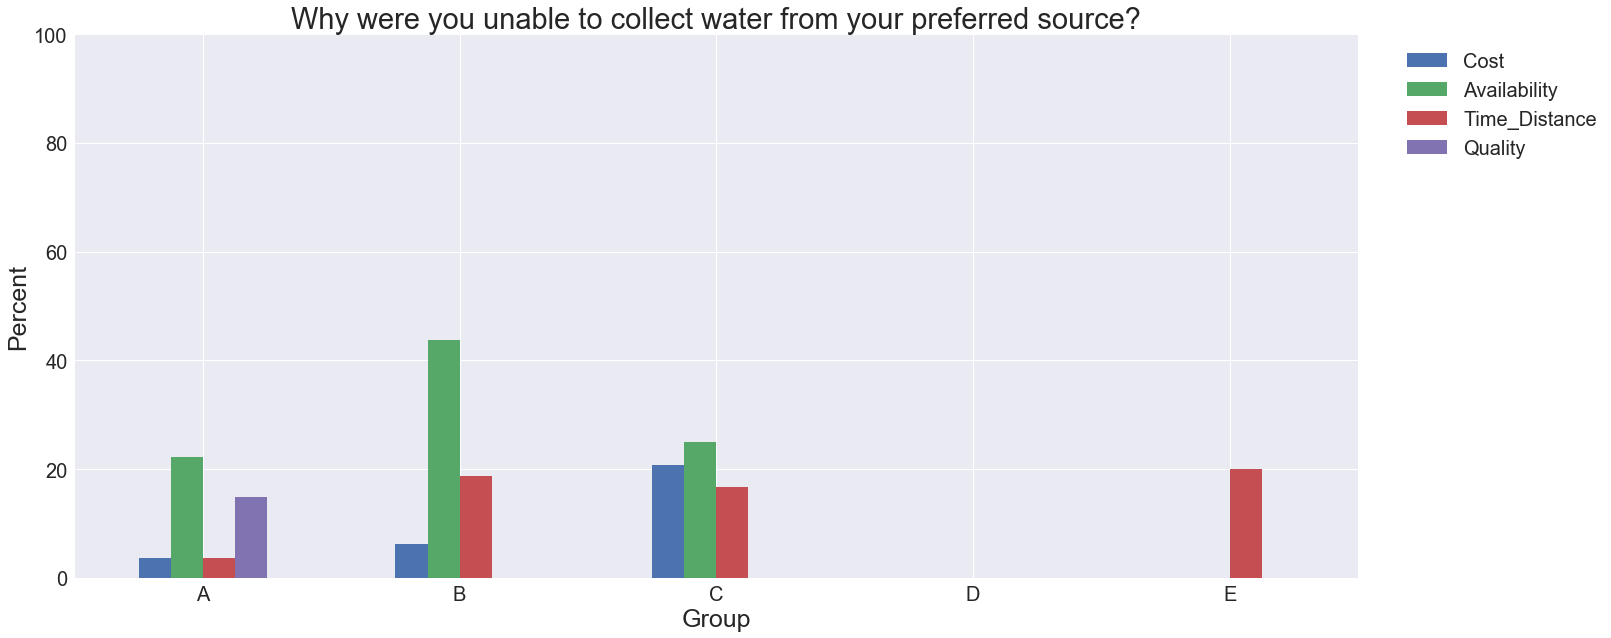

In [110]:
show_water_availability_reasons_diff(df_cluster3, ar[:-1], arl[:-1])

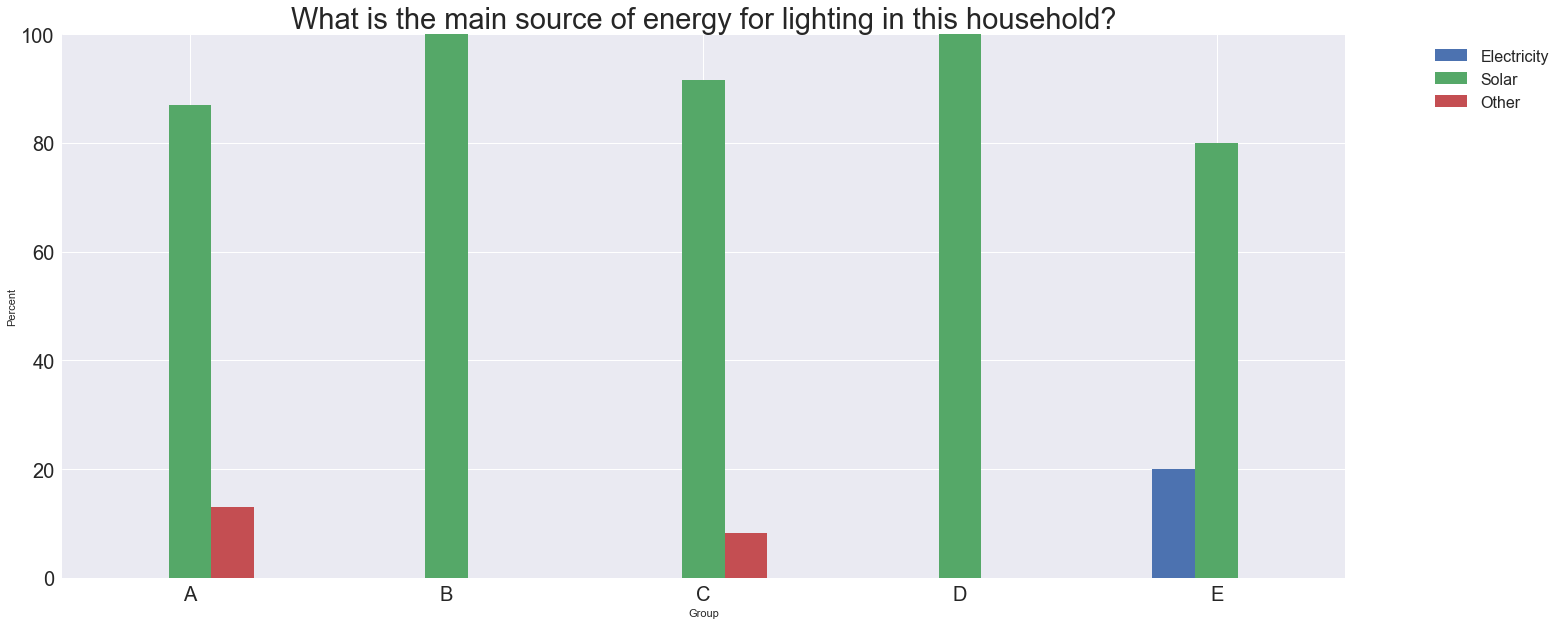

In [111]:
show_diff_for(df_cluster3, 'SourceOfLighting', 'What is the main source of energy for lighting in this household?', ['Electricity', 'Solar','Other'], (1.17, 1.0))

<a id='bl_rrl_measurements'></a>
## Measurements of groups

In [112]:
get_group_measurements(df_cluster1)

C:\Program Files\Anaconda3\lib\site-packages\pandas\core\groupby.py:3961: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


Count WaterExpenditure AmountOfWater        hh_mem           Age  \
      Responders    Average value Average value Average value Average value   
Group                                                                         
A            109          1281.72         31.26           5.4         36.08   
B             66          3918.94         74.44           6.5         34.50   
C             51          6460.78        121.33           9.0         35.45   
D             41          9329.27        215.24           8.5         32.54   
E              7         13428.57        140.57           5.0         39.29   

        Men Women   BankAccount         RudWI  
                  Average value Average value  
Group                                          
A      67.0  33.0          26.0          1.36  
B      80.0  20.0          23.0          1.41  
C      96.0   4.0          24.0          1.27  
D      80.0  20.0          22.0          1.32  
E      57.0  43.0           0.0          1.00

In [113]:
get_group_measurements(df_cluster2)

C:\Program Files\Anaconda3\lib\site-packages\pandas\core\groupby.py:3961: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


Count WaterExpenditure AmountOfWater        hh_mem           Age  \
      Responders    Average value Average value Average value Average value   
Group                                                                         
A            161          1968.54         53.14           NaN         33.73   
B             23          7067.39        102.04           NaN         36.43   
C             14         10892.86        145.36           NaN         32.64   
D              3         15500.00        100.00           NaN         24.00   
E              2         20000.00         32.00           NaN         38.50   

         Men Women   BankAccount         RudWI  
                   Average value Average value  
Group                                           
A       81.0  19.0          26.0          1.09  
B       87.0  13.0          13.0          0.91  
C       93.0   7.0          14.0          0.86  
D      100.0   0.0          33.0          1.67  
E       50.0  50.0          50.0          1.50

In [114]:
get_group_measurements(df_cluster3)

C:\Program Files\Anaconda3\lib\site-packages\pandas\core\groupby.py:3961: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


Count WaterExpenditure AmountOfWater        hh_mem           Age  \
      Responders    Average value Average value Average value Average value   
Group                                                                         
A             54            46.48         31.33           NaN         36.64   
B             32          1100.00         32.97           NaN         31.94   
C             24          1745.83         34.62           NaN         35.04   
D              4          2875.00         37.50           NaN         30.25   
E              5          3840.00         27.80           NaN         37.20   

        Men Women   BankAccount         RudWI  
                  Average value Average value  
Group                                          
A      85.0  15.0          39.0          1.59  
B      72.0  28.0          56.0          2.09  
C      92.0   8.0          50.0          2.21  
D      50.0  50.0          50.0          2.50  
E      80.0  20.0          40.0          1.80

<a id='diff_commns'></a>
# Comparison communities to each other

C:\Program Files\Anaconda3\lib\site-packages\pandas\core\groupby.py:3961: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


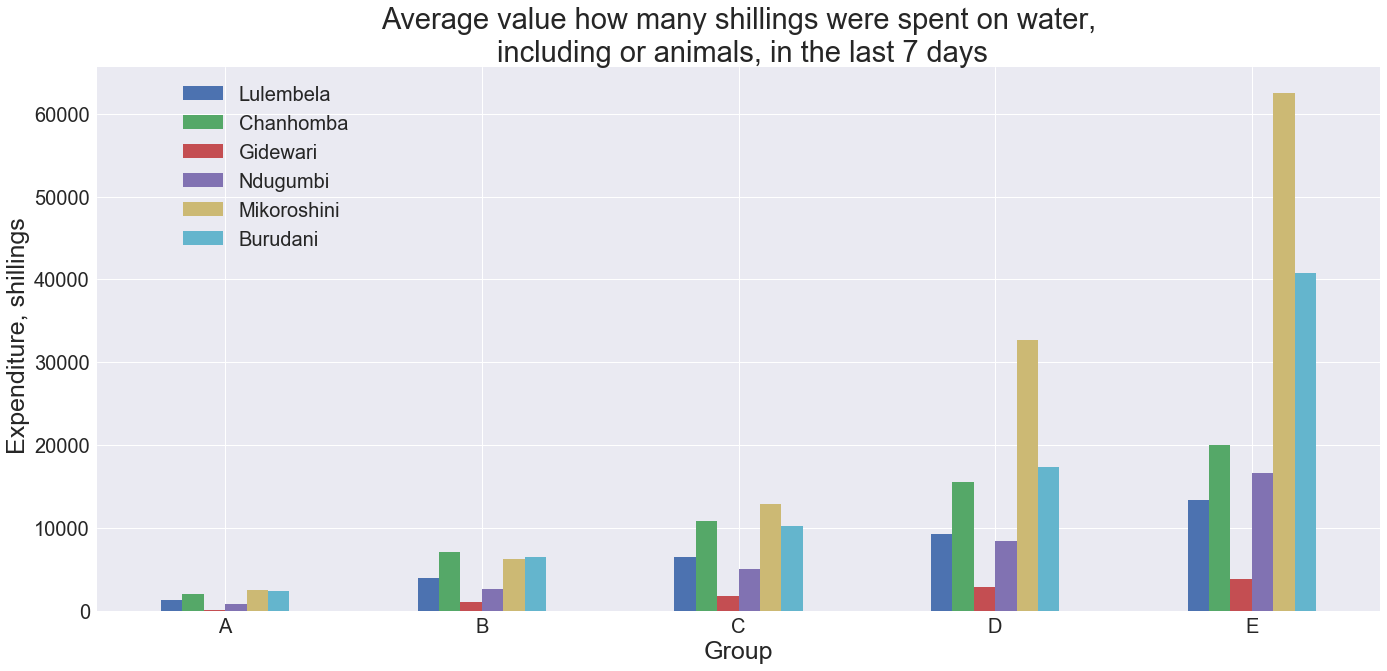

In [115]:
show_diff_between_6_communities(df_cluster1, df_cluster2,df_cluster3, df_cluster1_urban, df_cluster2_urban, df_cluster3_urban,
                                'WaterExpenditure', 'mean', ['Lulembela', 'Chanhomba', 'Gidewari', 'Ndugumbi', 'Mikoroshini', 'Burudani'],
                                'Average value how many shillings were spent on water,\n including or animals, in the last 7 days',
                                ' Expenditure, shillings', (0.21, 1))

C:\Program Files\Anaconda3\lib\site-packages\pandas\core\groupby.py:3961: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


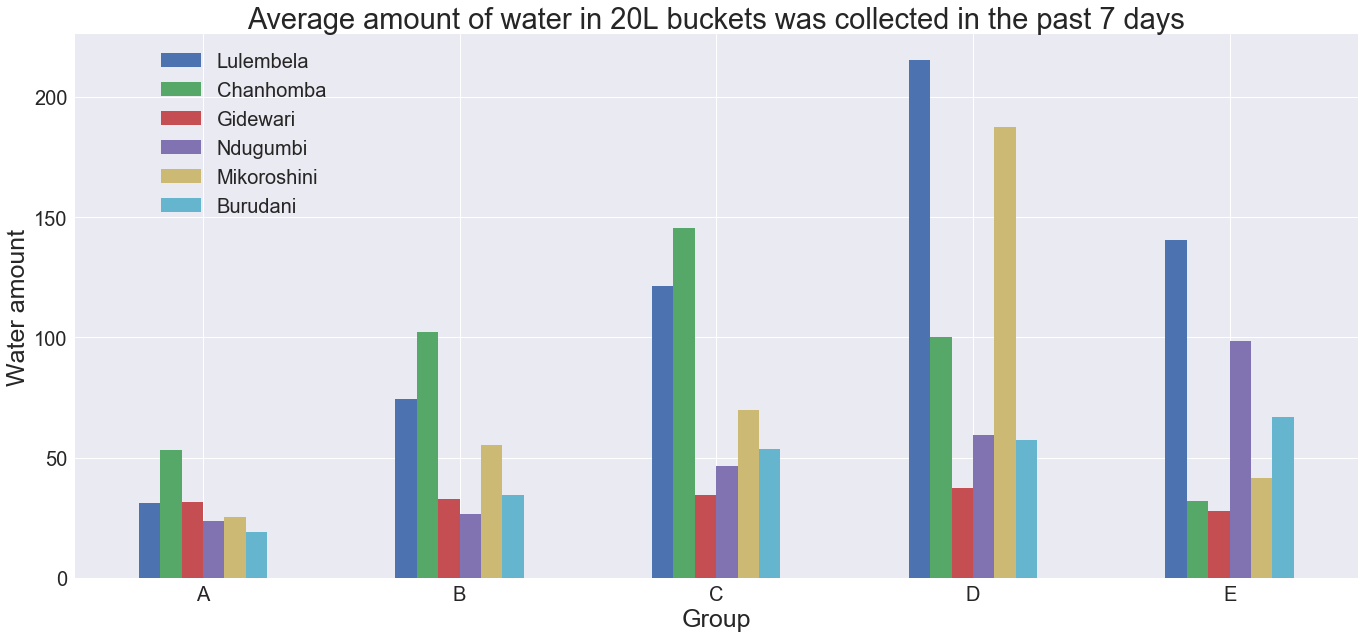

In [116]:
show_diff_between_6_communities(df_cluster1, df_cluster2,df_cluster3, df_cluster1_urban, df_cluster2_urban,df_cluster3_urban,
                                'AmountOfWater', 'mean', ['Lulembela', 'Chanhomba', 'Gidewari', 'Ndugumbi', 'Mikoroshini', 'Burudani'],
                                'Average amount of water in 20L buckets was collected in the past 7 days',
                                'Water amount', (0.21, 1))

C:\Program Files\Anaconda3\lib\site-packages\pandas\core\groupby.py:3961: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


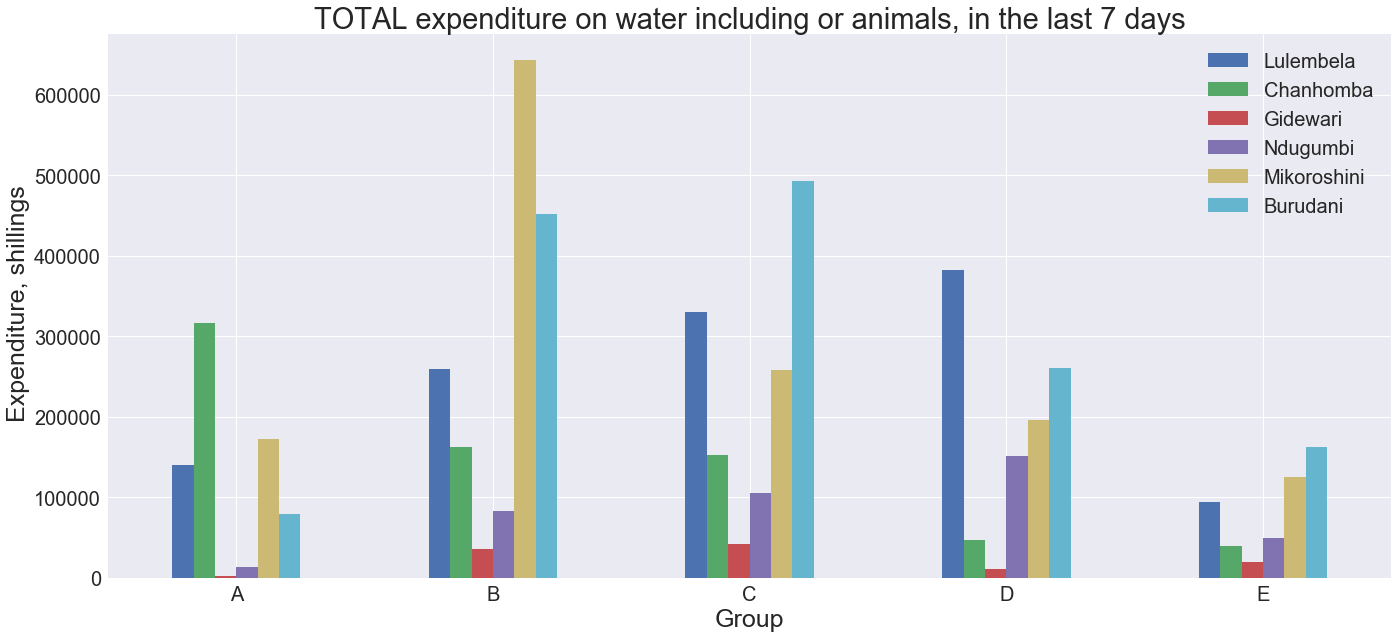

In [117]:
show_diff_between_6_communities(df_cluster1, df_cluster2,df_cluster3, df_cluster1_urban, df_cluster2_urban, df_cluster3_urban,
                                'WaterExpenditure', 'sum', ['Lulembela', 'Chanhomba', 'Gidewari', 'Ndugumbi', 'Mikoroshini', 'Burudani'],
                                'TOTAL expenditure on water including or animals, in the last 7 days',
                                ' Expenditure, shillings', (1, 1))

In [118]:
df_cluster1_1 = df_cluster1[df_cluster1.PrimarySource == 1]
df_cluster1_2 = df_cluster1[df_cluster1.PrimarySource == 2]
df_cluster1_3 = df_cluster1[df_cluster1.PrimarySource == 3]
df_cluster1_4 = df_cluster1[df_cluster1.PrimarySource == 4]
df_cluster1_5 = df_cluster1[df_cluster1.PrimarySource == 5]
df_cluster1_6 = df_cluster1[df_cluster1.PrimarySource == 6]
df_cluster1_7 = df_cluster1[df_cluster1.PrimarySource == 7]
df_cluster1_8 = df_cluster1[df_cluster1.PrimarySource == 8]
df_cluster2_1 = df_cluster2[df_cluster2.PrimarySource == 1]
df_cluster2_2 = df_cluster2[df_cluster2.PrimarySource == 2]
df_cluster2_3 = df_cluster2[df_cluster2.PrimarySource == 3]
df_cluster2_4 = df_cluster2[df_cluster2.PrimarySource == 4]
df_cluster2_5 = df_cluster2[df_cluster2.PrimarySource == 5]
df_cluster2_6 = df_cluster2[df_cluster2.PrimarySource == 6]
df_cluster2_7 = df_cluster2[df_cluster2.PrimarySource == 7]
df_cluster2_8 = df_cluster2[df_cluster2.PrimarySource == 8]
df_cluster3_1 = df_cluster3[df_cluster3.PrimarySource == 1]
df_cluster3_2 = df_cluster3[df_cluster3.PrimarySource == 2]
df_cluster3_3 = df_cluster3[df_cluster3.PrimarySource == 3]
df_cluster3_4 = df_cluster3[df_cluster3.PrimarySource == 4]
df_cluster3_5 = df_cluster3[df_cluster3.PrimarySource == 5]
df_cluster3_6 = df_cluster3[df_cluster3.PrimarySource == 6]
df_cluster3_7 = df_cluster3[df_cluster3.PrimarySource == 7]
df_cluster3_8 = df_cluster3[df_cluster3.PrimarySource == 8]


C:\Program Files\Anaconda3\lib\site-packages\pandas\core\groupby.py:3961: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


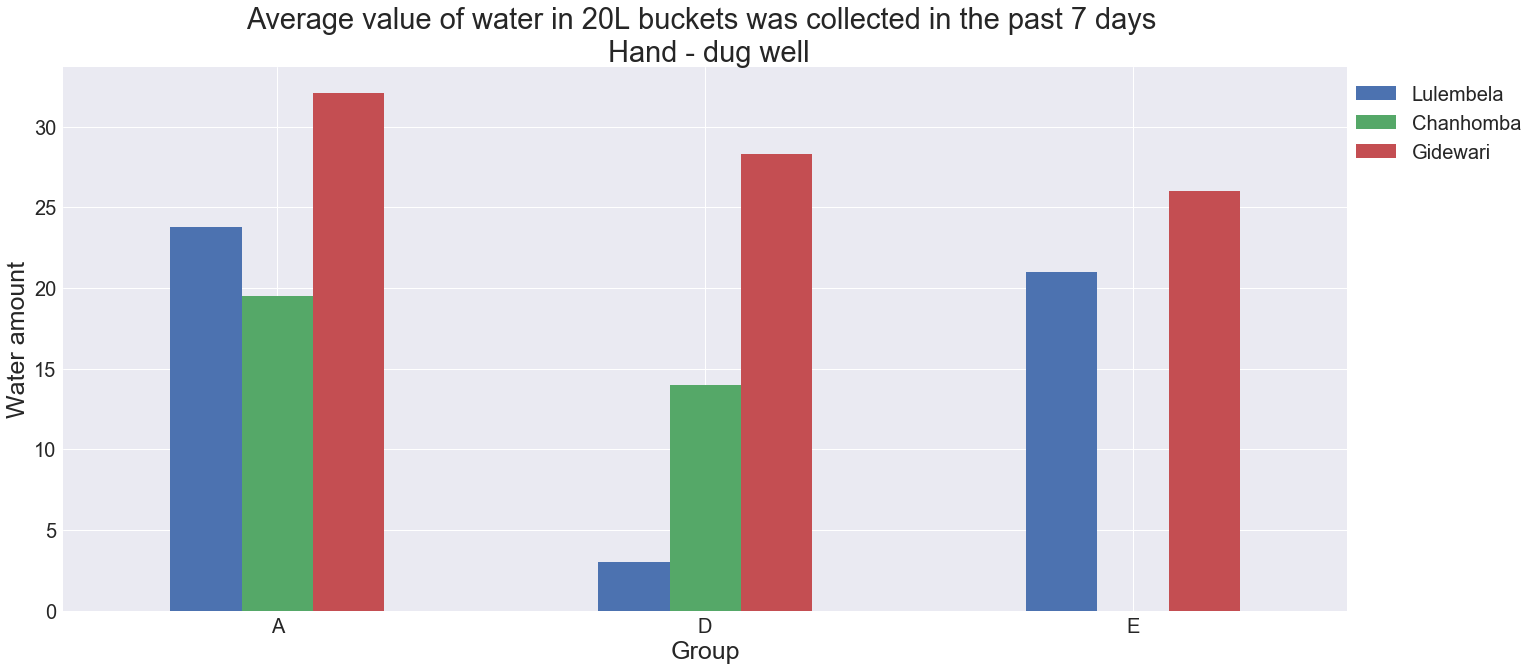

In [119]:
show_diff_between_3_communities(df_cluster1_1, df_cluster2_1,df_cluster3_1,
                                'AmountOfWater', 'mean', ['Lulembela', 'Chanhomba', 'Gidewari'],
                                'Average value of water in 20L buckets was collected in the past 7 days \n Hand - dug well',
                                'Water amount')

C:\Program Files\Anaconda3\lib\site-packages\pandas\core\groupby.py:3961: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


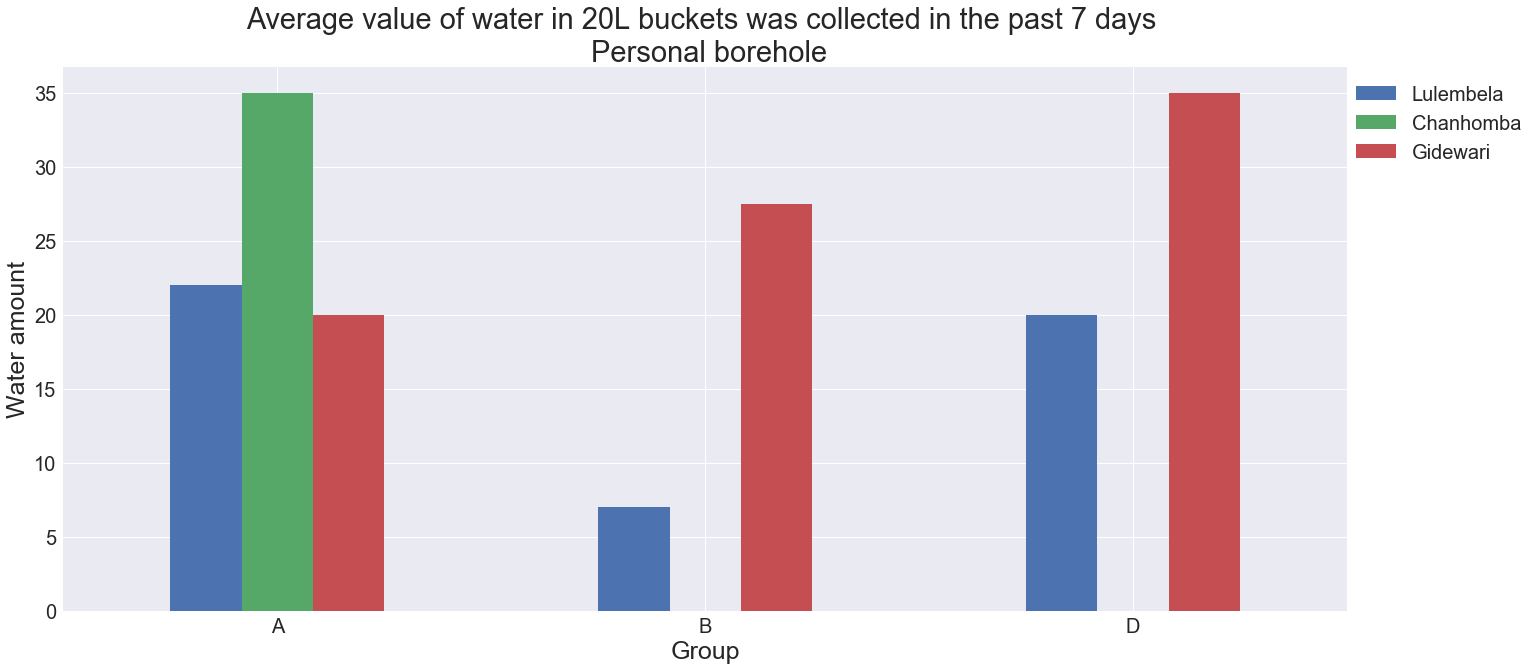

In [120]:
show_diff_between_3_communities(df_cluster1_2, df_cluster2_2,df_cluster3_2,
                                'AmountOfWater', 'mean', ['Lulembela', 'Chanhomba', 'Gidewari'],
                                'Average value of water in 20L buckets was collected in the past 7 days \n Personal borehole',
                                'Water amount')

C:\Program Files\Anaconda3\lib\site-packages\pandas\core\groupby.py:3961: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


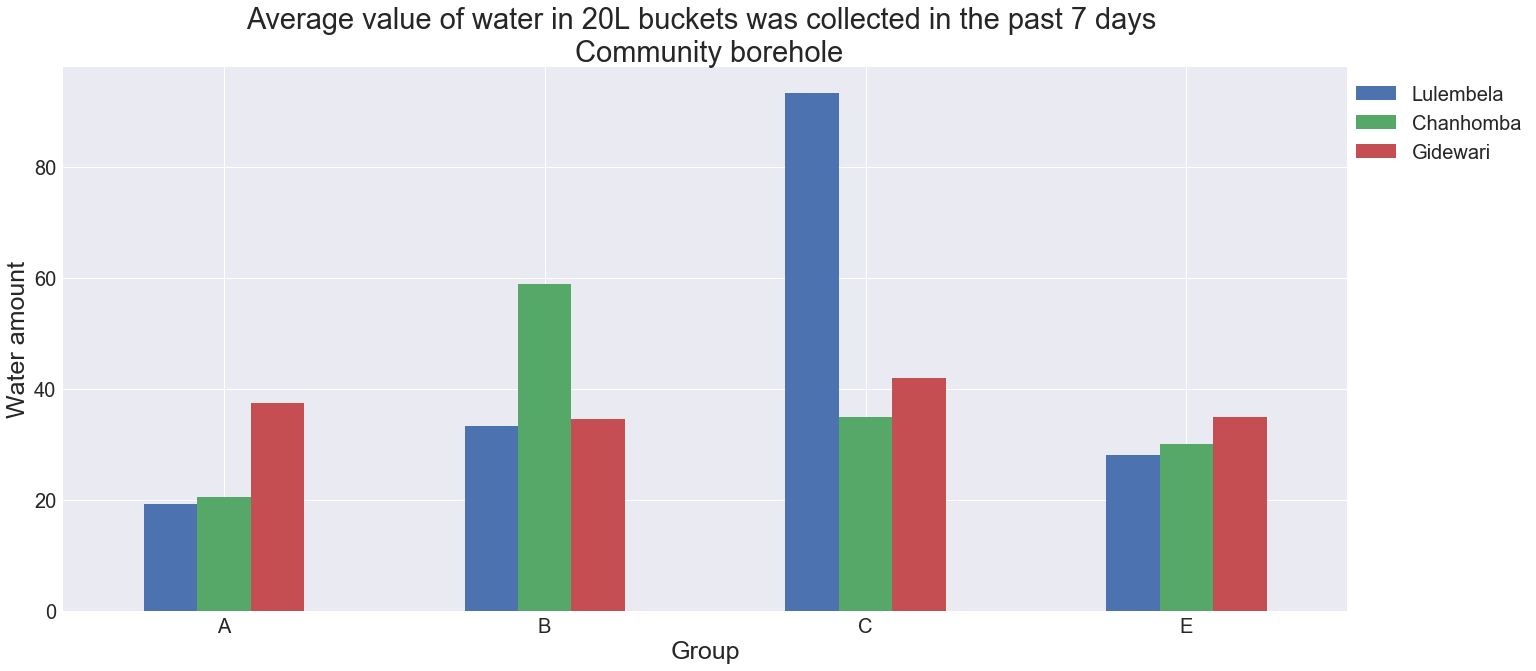

In [121]:
show_diff_between_3_communities(df_cluster1_3, df_cluster2_3,df_cluster3_3,
                                'AmountOfWater', 'mean', ['Lulembela', 'Chanhomba', 'Gidewari'],
                                'Average value of water in 20L buckets was collected in the past 7 days \n Community borehole',
                                'Water amount')

C:\Program Files\Anaconda3\lib\site-packages\pandas\core\groupby.py:3961: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


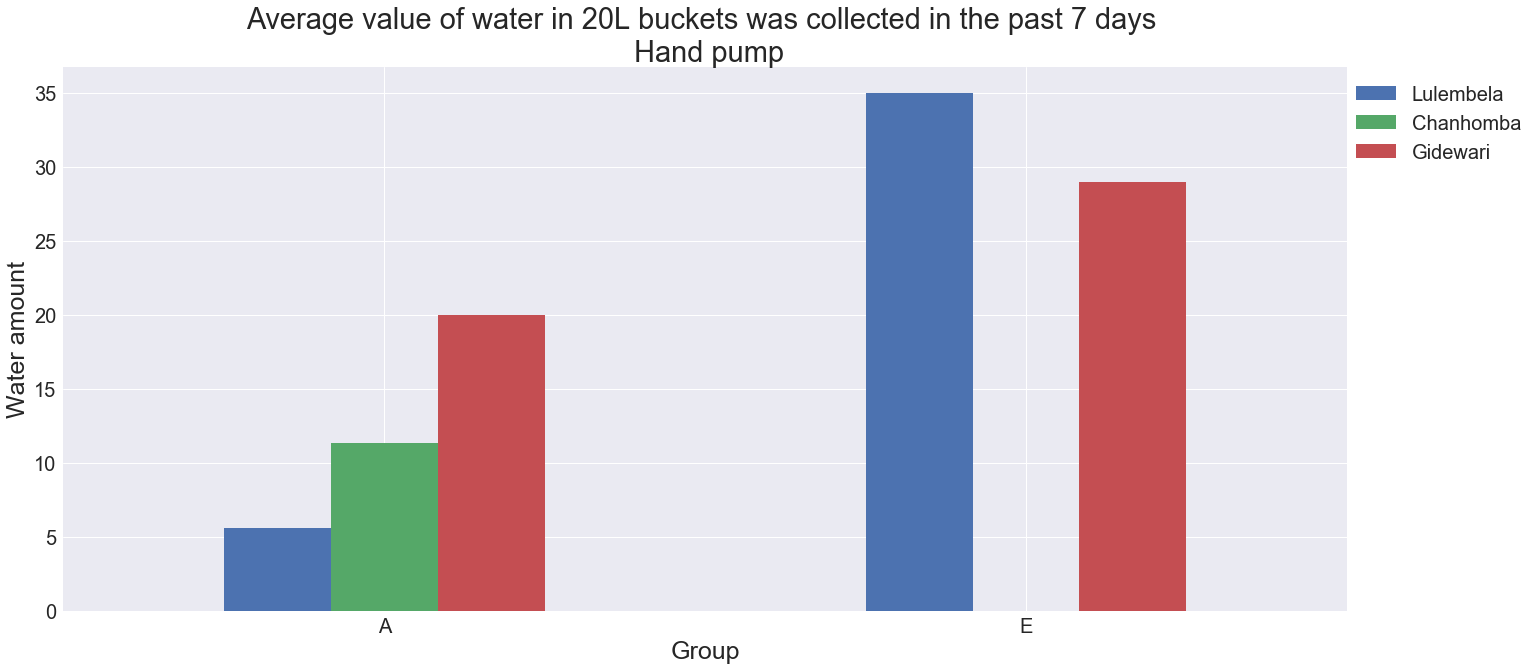

In [122]:
show_diff_between_3_communities(df_cluster1_4, df_cluster2_4,df_cluster3_4,
                                'AmountOfWater', 'mean', ['Lulembela', 'Chanhomba', 'Gidewari'],
                                'Average value of water in 20L buckets was collected in the past 7 days \n Hand pump',
                                'Water amount')

C:\Program Files\Anaconda3\lib\site-packages\pandas\core\groupby.py:3961: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


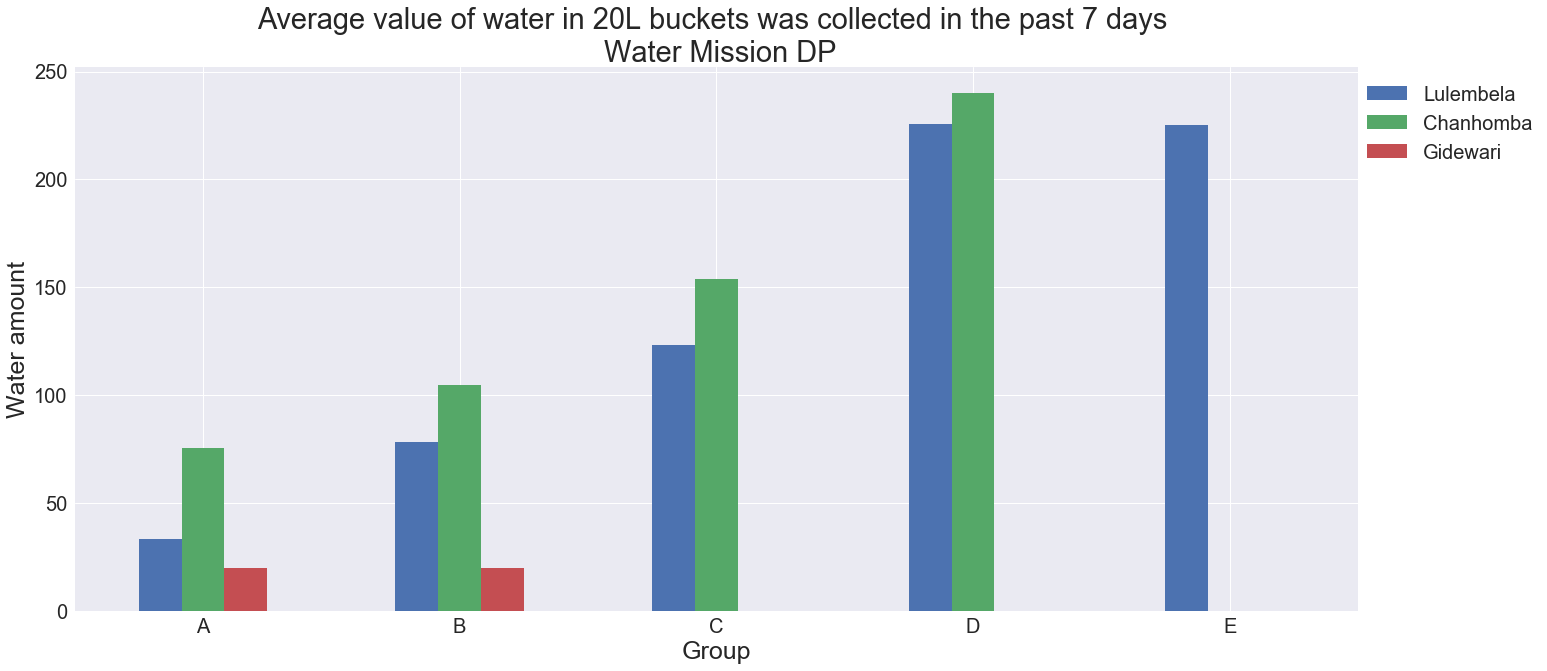

In [123]:
show_diff_between_3_communities(df_cluster1_5, df_cluster2_5,df_cluster3_5,
                                'AmountOfWater', 'mean', ['Lulembela', 'Chanhomba', 'Gidewari'],
                                'Average value of water in 20L buckets was collected in the past 7 days \n Water Mission DP',
                                'Water amount')

C:\Program Files\Anaconda3\lib\site-packages\pandas\core\groupby.py:3961: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


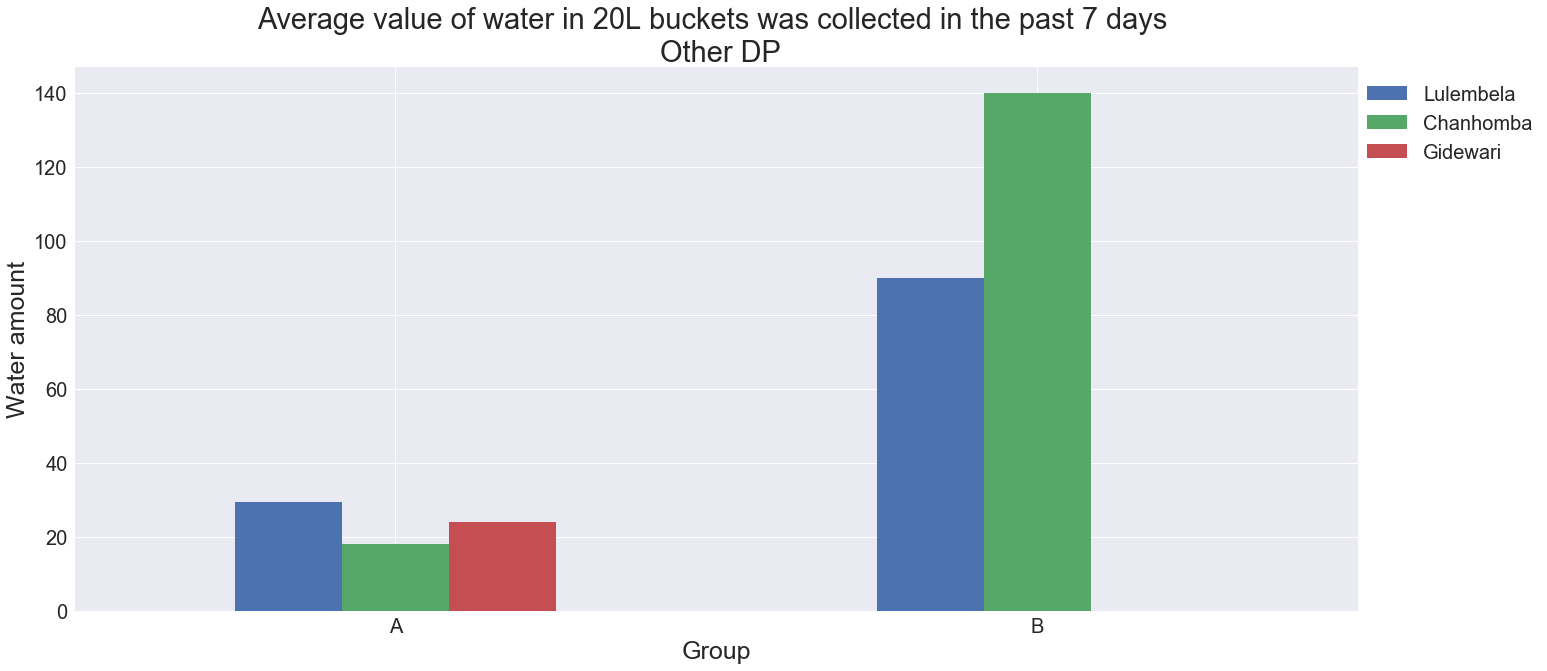

In [124]:
show_diff_between_3_communities(df_cluster1_6, df_cluster2_6,df_cluster3_6,
                                'AmountOfWater', 'mean', ['Lulembela', 'Chanhomba', 'Gidewari'],
                                'Average value of water in 20L buckets was collected in the past 7 days \n Other DP',
                                'Water amount')

C:\Program Files\Anaconda3\lib\site-packages\pandas\core\groupby.py:3961: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


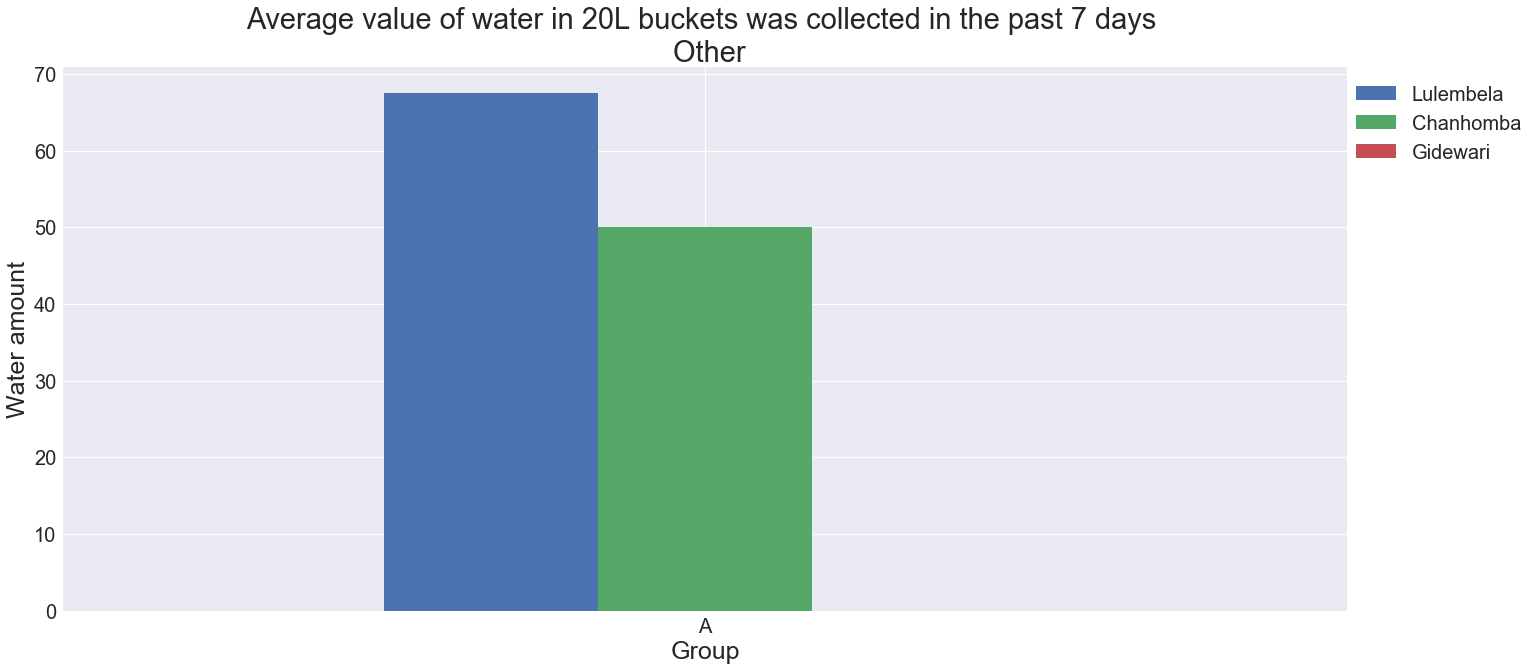

In [125]:
show_diff_between_3_communities(df_cluster1_8, df_cluster2_8,df_cluster3_8,
                                'AmountOfWater', 'mean', ['Lulembela', 'Chanhomba', 'Gidewari'],
                                'Average value of water in 20L buckets was collected in the past 7 days \n Other',
                                'Water amount')

C:\Program Files\Anaconda3\lib\site-packages\pandas\core\groupby.py:3961: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


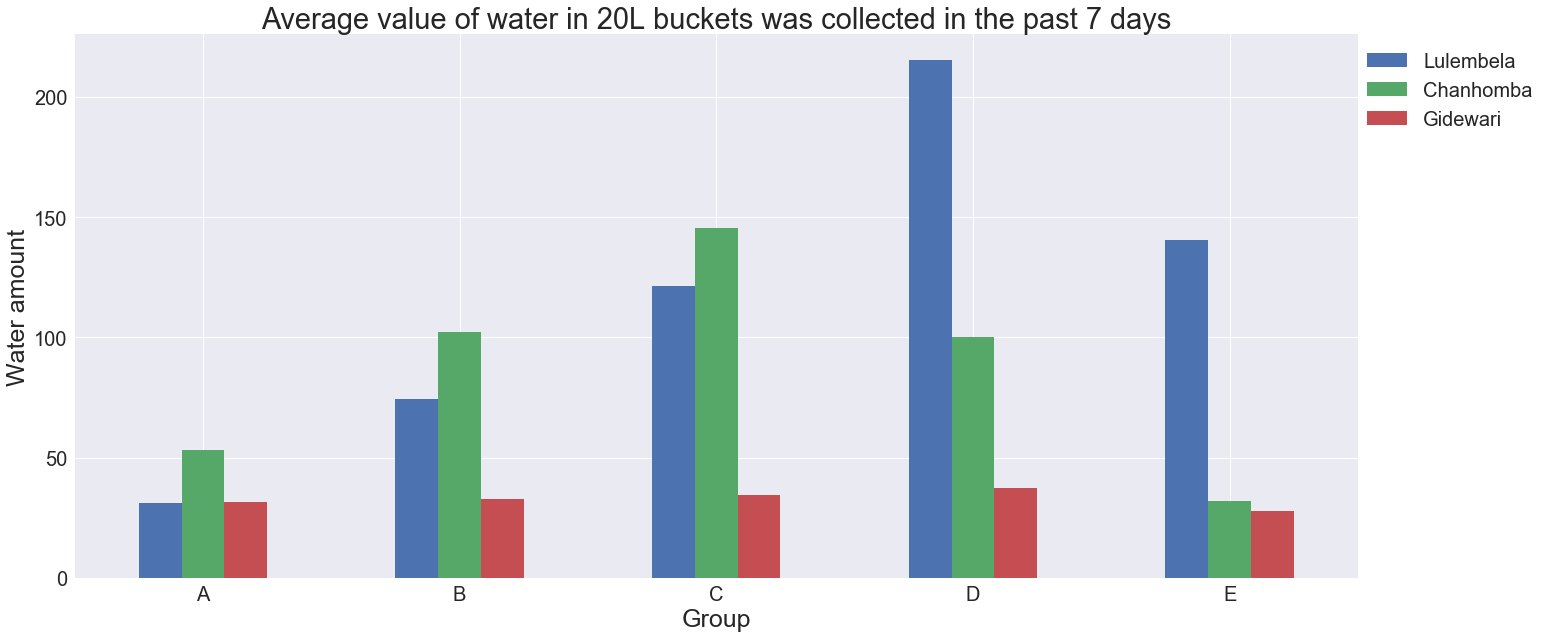

In [126]:
show_diff_between_3_communities(df_cluster1, df_cluster2,df_cluster3,
                                'AmountOfWater', 'mean', ['Lulembela', 'Chanhomba', 'Gidewari'],
                                'Average value of water in 20L buckets was collected in the past 7 days',
                                'Water amount')

C:\Program Files\Anaconda3\lib\site-packages\pandas\core\groupby.py:3961: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


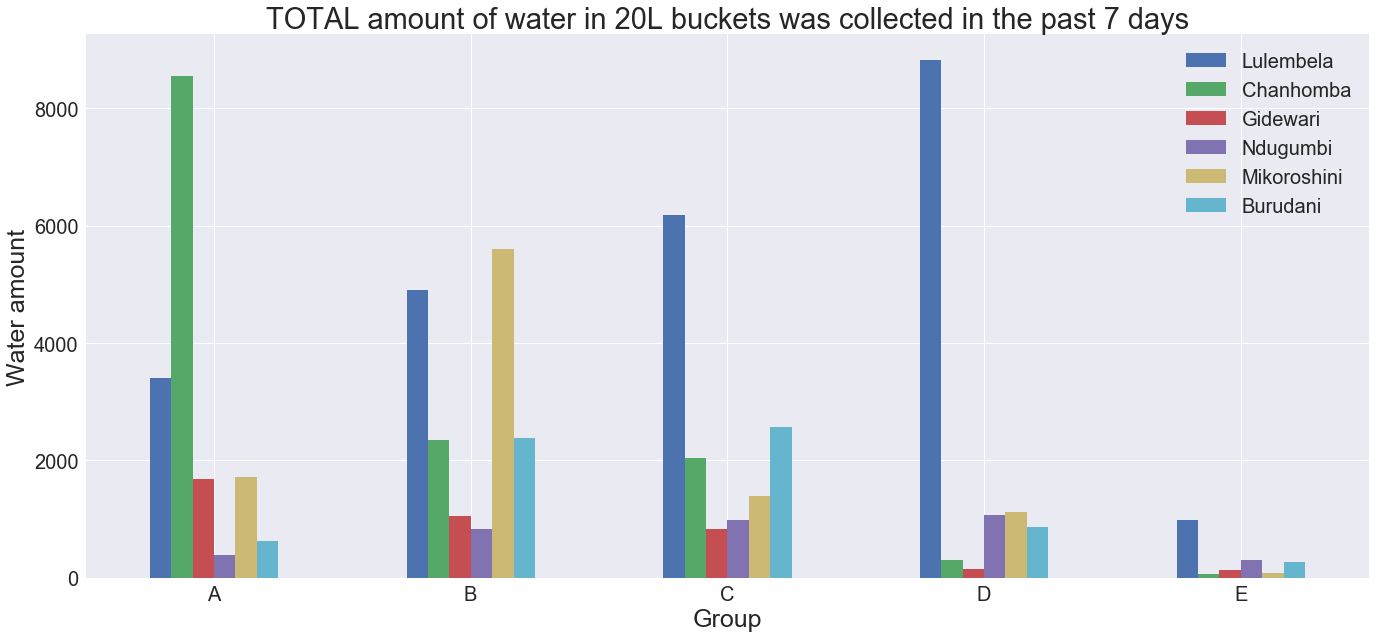

In [127]:
show_diff_between_6_communities(df_cluster1, df_cluster2,df_cluster3, df_cluster1_urban, df_cluster2_urban,df_cluster3_urban,
                                'AmountOfWater', 'sum', ['Lulembela', 'Chanhomba', 'Gidewari', 'Ndugumbi', 'Mikoroshini', 'Burudani'],
                                'TOTAL amount of water in 20L buckets was collected in the past 7 days',
                                'Water amount', (1, 1))

C:\Program Files\Anaconda3\lib\site-packages\pandas\core\groupby.py:3961: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


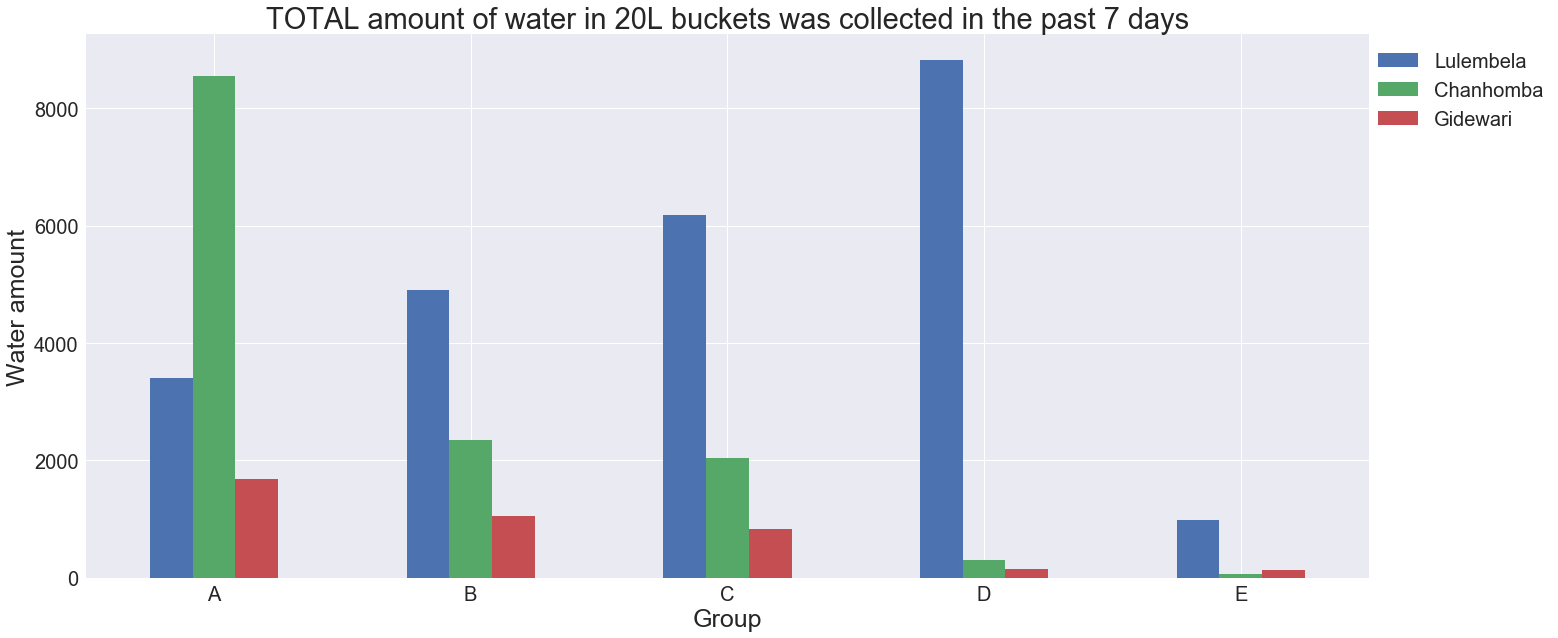

In [128]:
show_diff_between_3_communities(df_cluster1, df_cluster2,df_cluster3,
                                'AmountOfWater', 'sum', ['Lulembela', 'Chanhomba', 'Gidewari'],
                                'TOTAL amount of water in 20L buckets was collected in the past 7 days',
                                'Water amount')

C:\Program Files\Anaconda3\lib\site-packages\pandas\core\groupby.py:3961: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


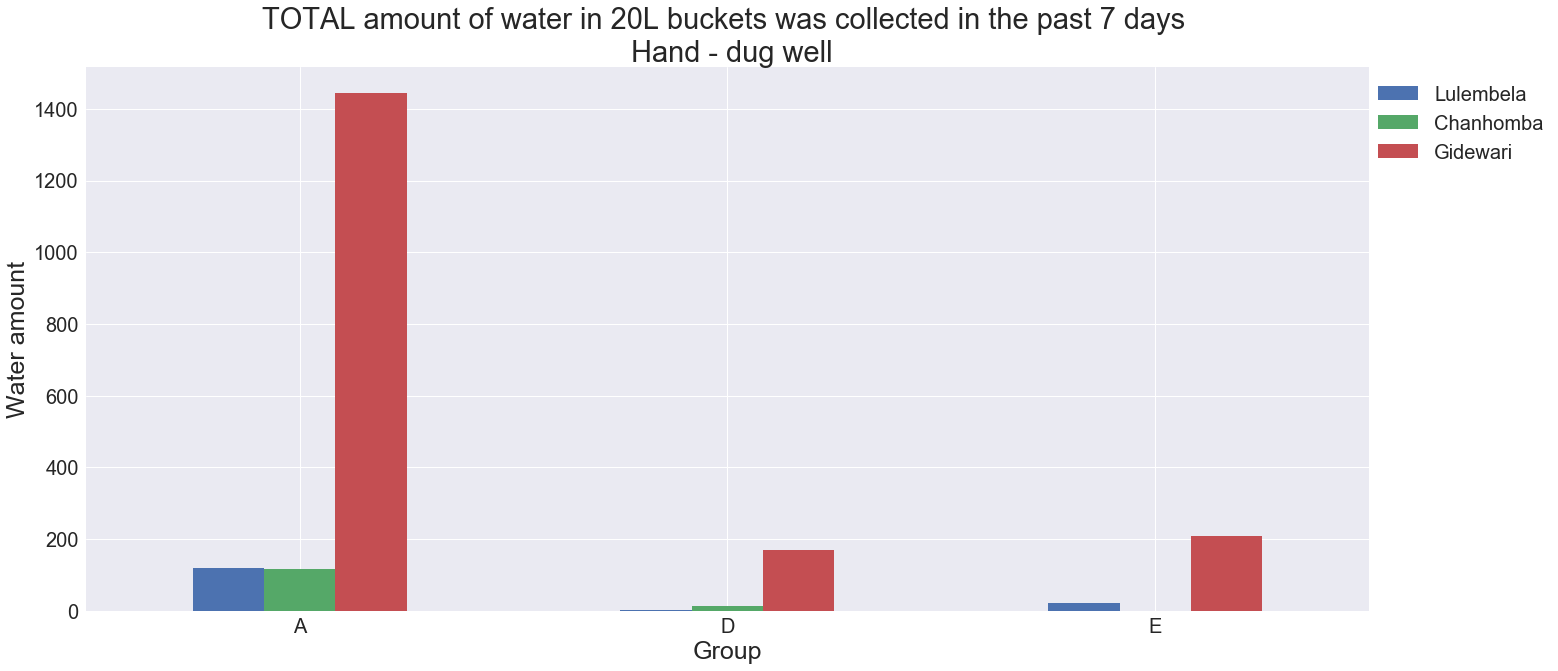

In [129]:
show_diff_between_3_communities(df_cluster1_1, df_cluster2_1,df_cluster3_1,
                                'AmountOfWater', 'sum', ['Lulembela', 'Chanhomba', 'Gidewari'],
                                'TOTAL amount of water in 20L buckets was collected in the past 7 days \n Hand - dug well',
                                'Water amount')

C:\Program Files\Anaconda3\lib\site-packages\pandas\core\groupby.py:3961: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


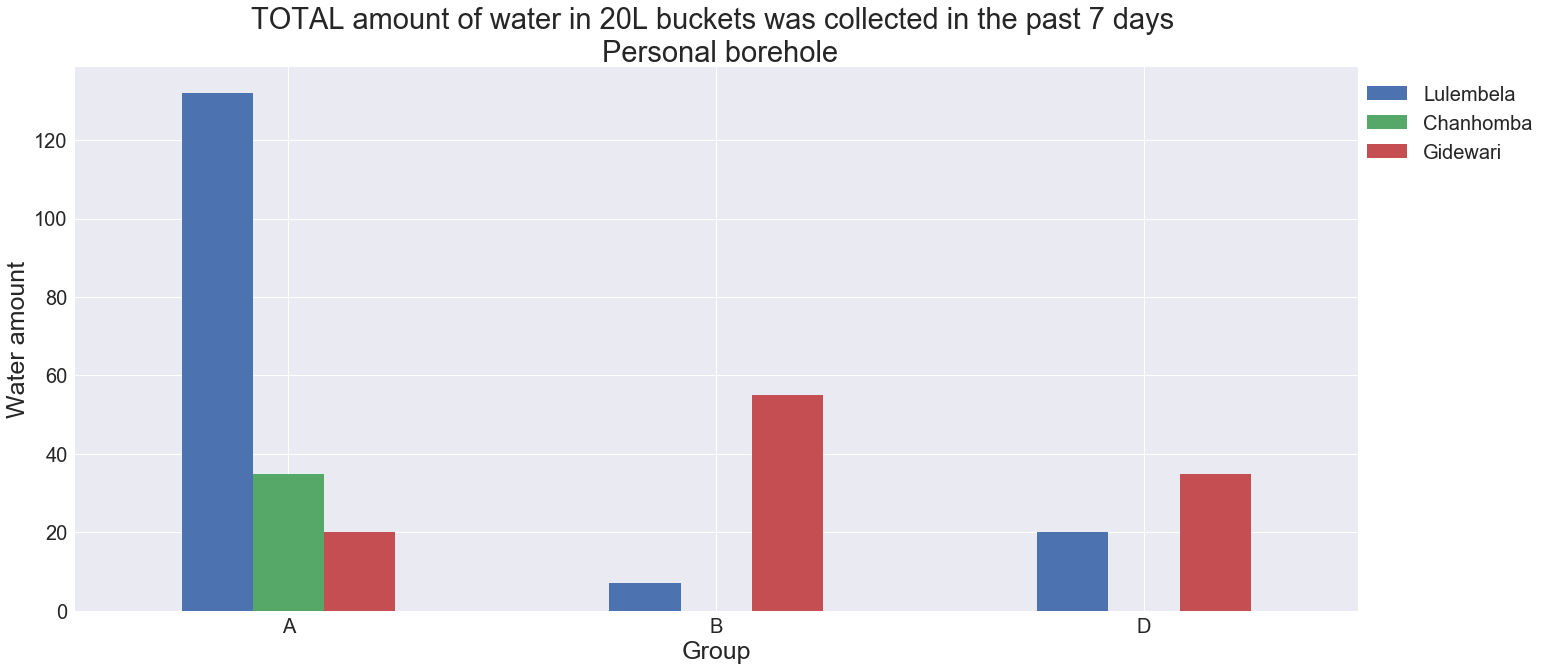

In [130]:
show_diff_between_3_communities(df_cluster1_2, df_cluster2_2,df_cluster3_2,
                                'AmountOfWater', 'sum', ['Lulembela', 'Chanhomba', 'Gidewari'],
                                'TOTAL amount of water in 20L buckets was collected in the past 7 days \n Personal borehole',
                                'Water amount')

C:\Program Files\Anaconda3\lib\site-packages\pandas\core\groupby.py:3961: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


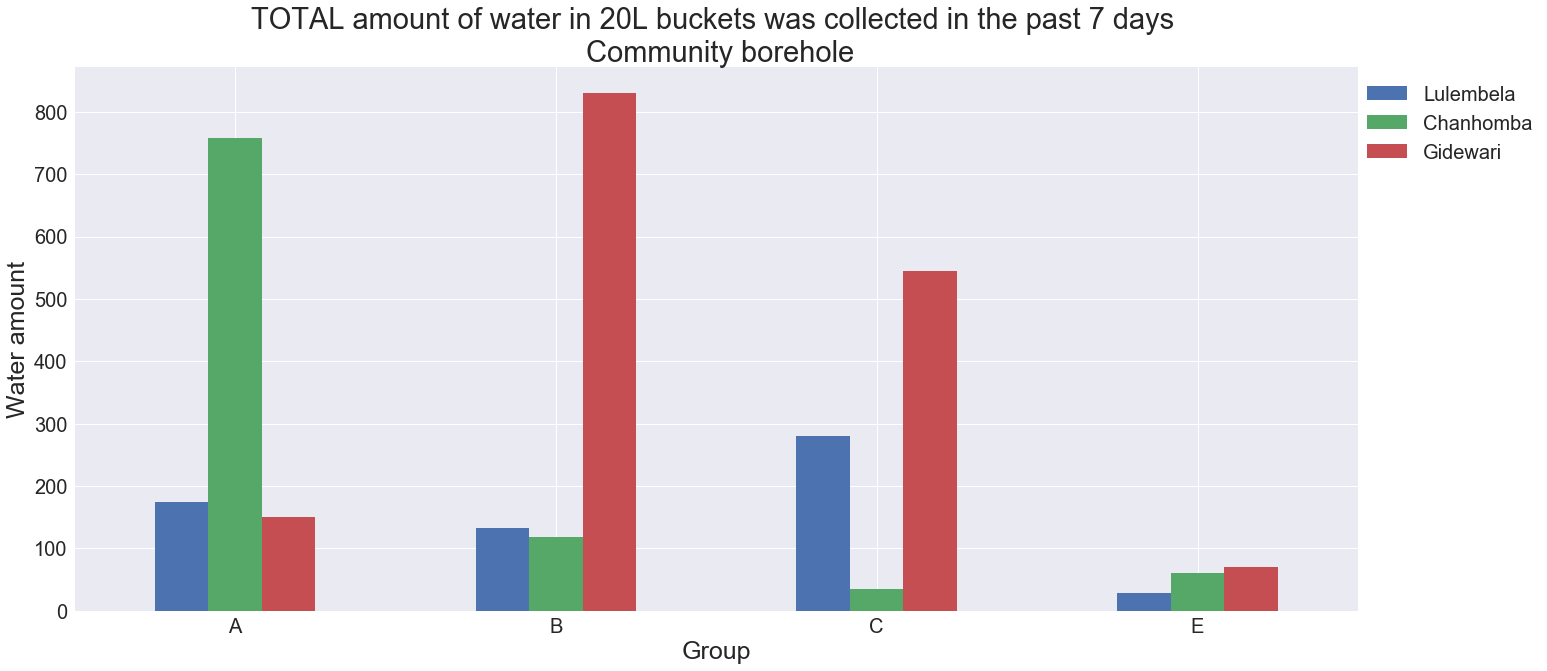

In [131]:
show_diff_between_3_communities(df_cluster1_3, df_cluster2_3,df_cluster3_3,
                                'AmountOfWater', 'sum', ['Lulembela', 'Chanhomba', 'Gidewari'],
                                'TOTAL amount of water in 20L buckets was collected in the past 7 days \n Community borehole',
                                'Water amount')

C:\Program Files\Anaconda3\lib\site-packages\pandas\core\groupby.py:3961: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


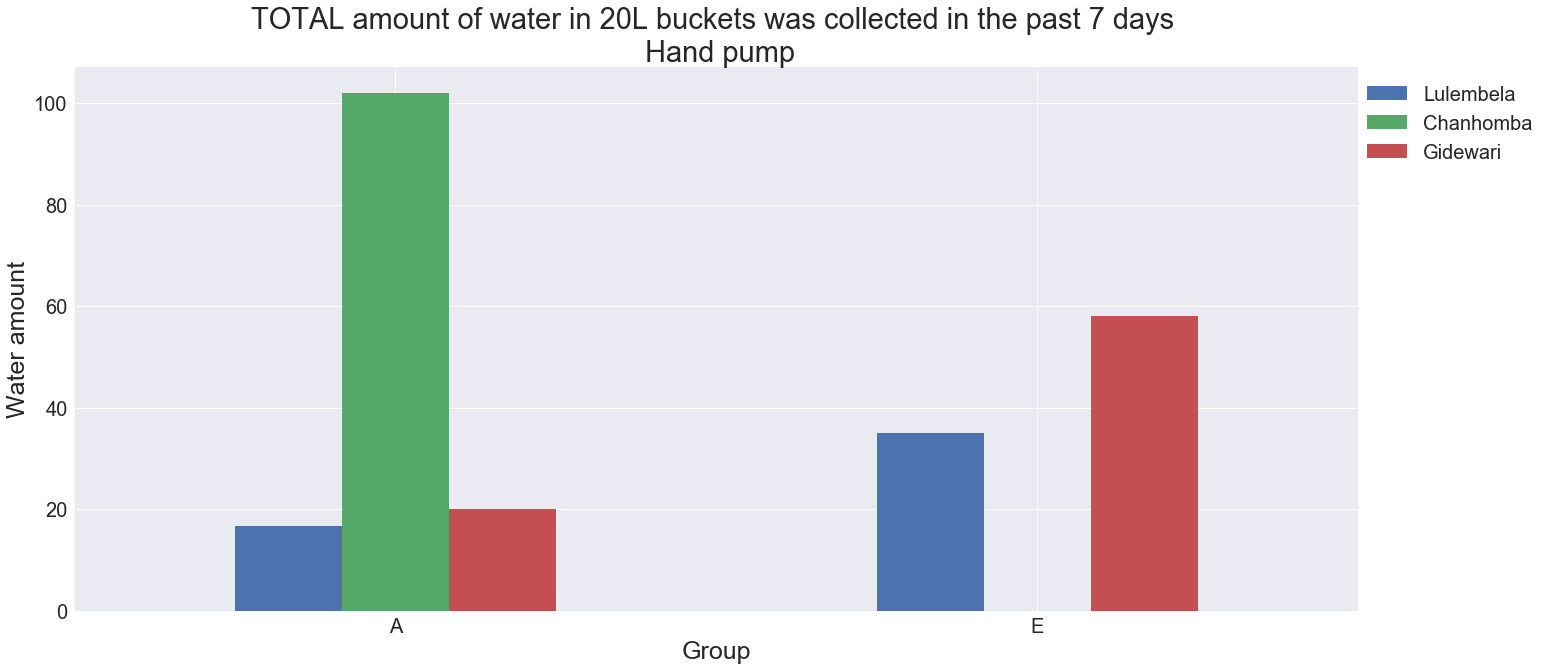

In [132]:
show_diff_between_3_communities(df_cluster1_4, df_cluster2_4,df_cluster3_4,
                                'AmountOfWater', 'sum', ['Lulembela', 'Chanhomba', 'Gidewari'],
                                'TOTAL amount of water in 20L buckets was collected in the past 7 days \n Hand pump',
                                'Water amount')

C:\Program Files\Anaconda3\lib\site-packages\pandas\core\groupby.py:3961: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


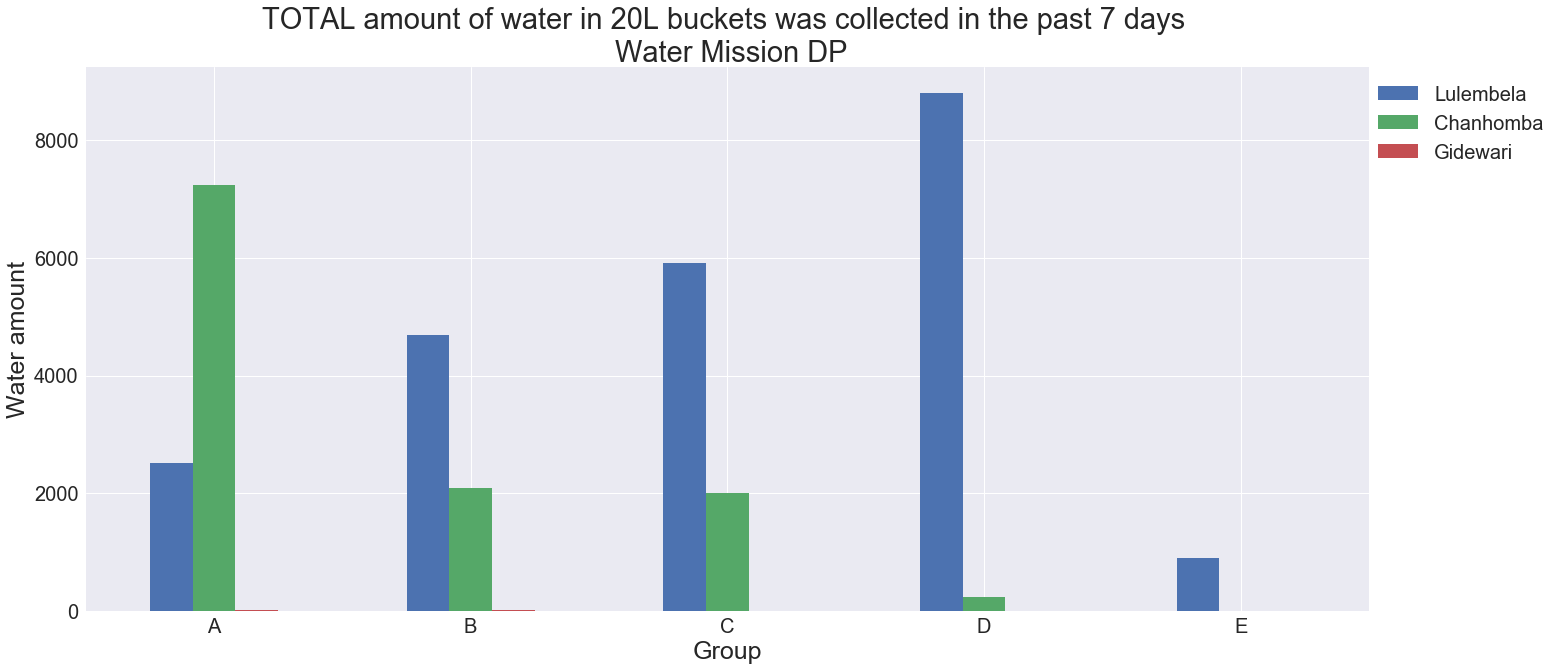

In [133]:
show_diff_between_3_communities(df_cluster1_5, df_cluster2_5,df_cluster3_5,
                                'AmountOfWater', 'sum', ['Lulembela', 'Chanhomba', 'Gidewari'],
                                'TOTAL amount of water in 20L buckets was collected in the past 7 days \n Water Mission DP',
                                'Water amount')

C:\Program Files\Anaconda3\lib\site-packages\pandas\core\groupby.py:3961: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


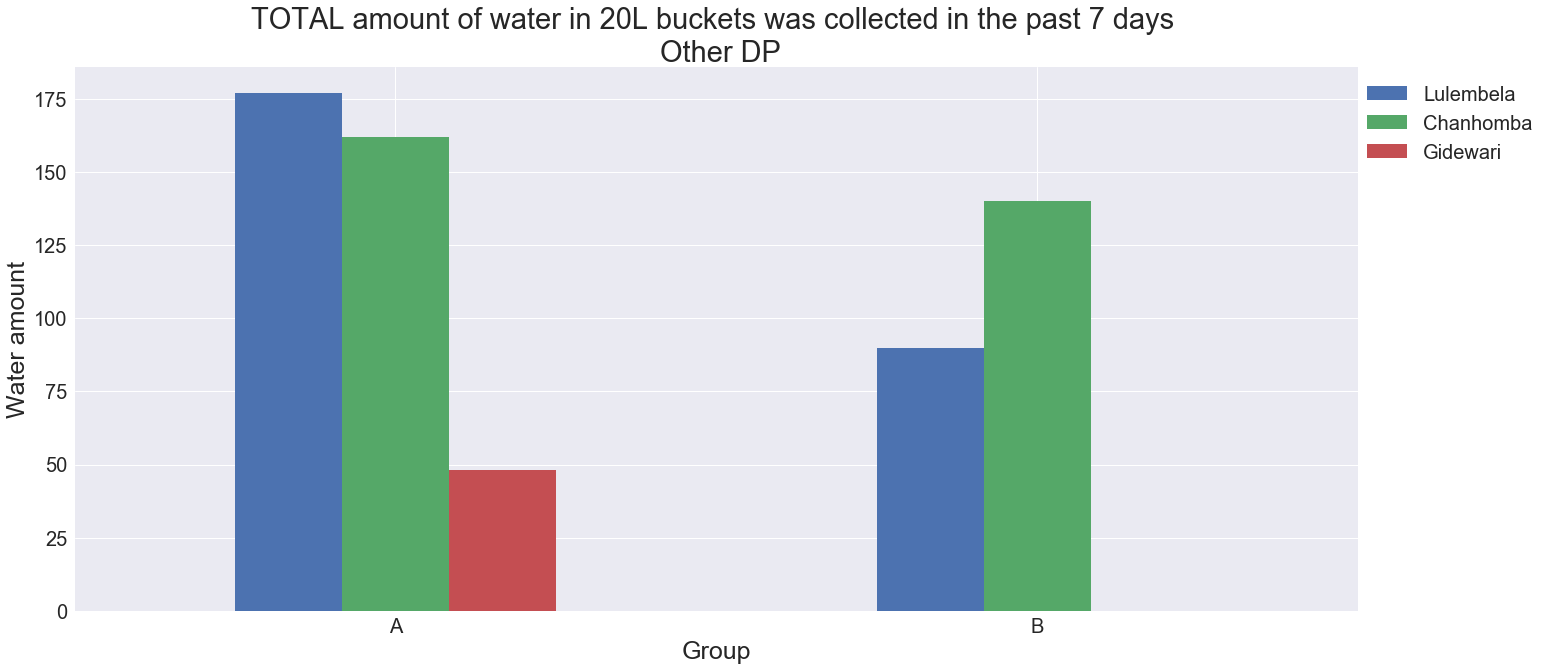

In [134]:
show_diff_between_3_communities(df_cluster1_6, df_cluster2_6,df_cluster3_6,
                                'AmountOfWater', 'sum', ['Lulembela', 'Chanhomba', 'Gidewari'],
                                'TOTAL amount of water in 20L buckets was collected in the past 7 days \n Other DP',
                                'Water amount')

C:\Program Files\Anaconda3\lib\site-packages\pandas\core\groupby.py:3961: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


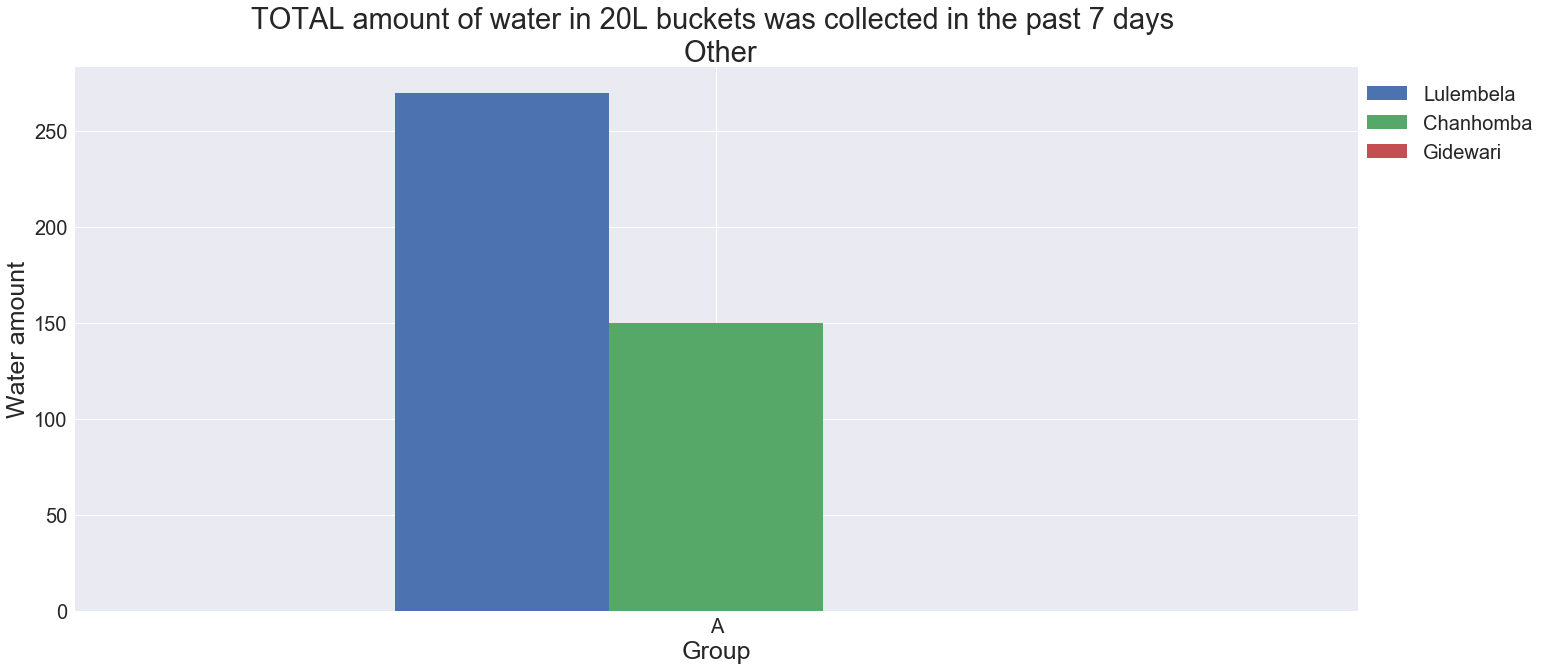

In [135]:
show_diff_between_3_communities(df_cluster1_8, df_cluster2_8,df_cluster3_8,
                                'AmountOfWater', 'sum', ['Lulembela', 'Chanhomba', 'Gidewari'],
                                'TOTAL amount of water in 20L buckets was collected in the past 7 days \n Other',
                                'Water amount')

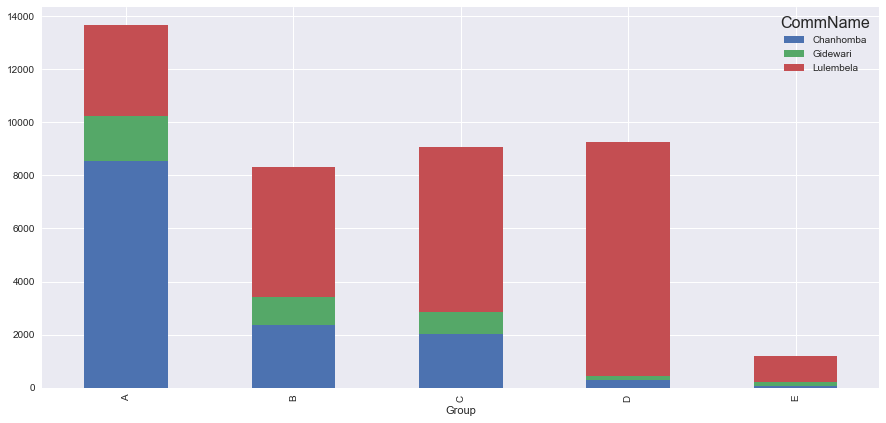

In [136]:
df = df_cluster1.append(df_cluster2).append(df_cluster3)
df2 = df.groupby(['CommName', 'Group'])['AmountOfWater'].sum().unstack('CommName').fillna(0)
df2.plot(kind='bar', stacked=True)

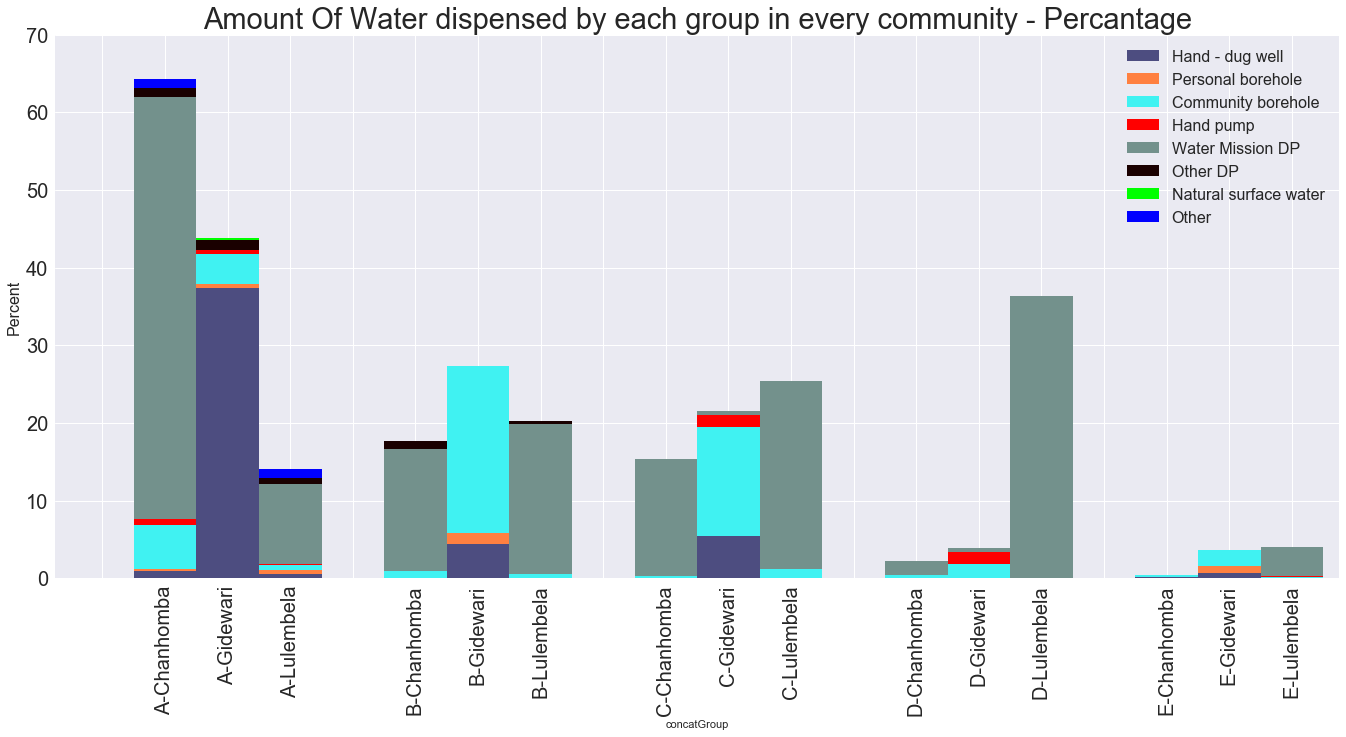

In [137]:
df = df_cluster1.append(df_cluster2).append(df_cluster3)
df_urban = df_cluster1_urban.append(df_cluster2_urban).append(df_cluster3_urban)
show_stacked_plot(df, 'Amount Of Water dispensed by each group in every community - Percantage', source_of_water, 'Percent', 'Percent', 'AmountOfWater', 70)

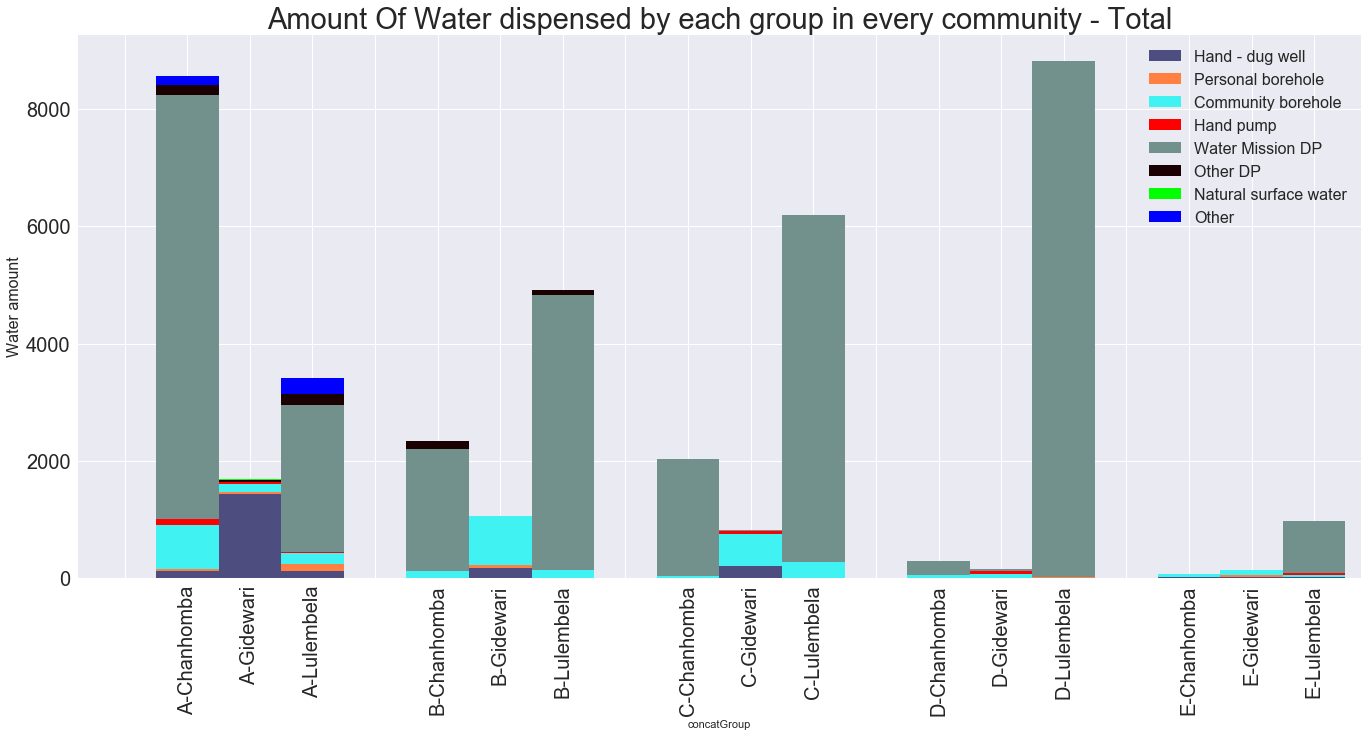

In [138]:
show_stacked_plot(df, 'Amount Of Water dispensed by each group in every community - Total', source_of_water, 'Total', 'Water amount', 'AmountOfWater', 0)

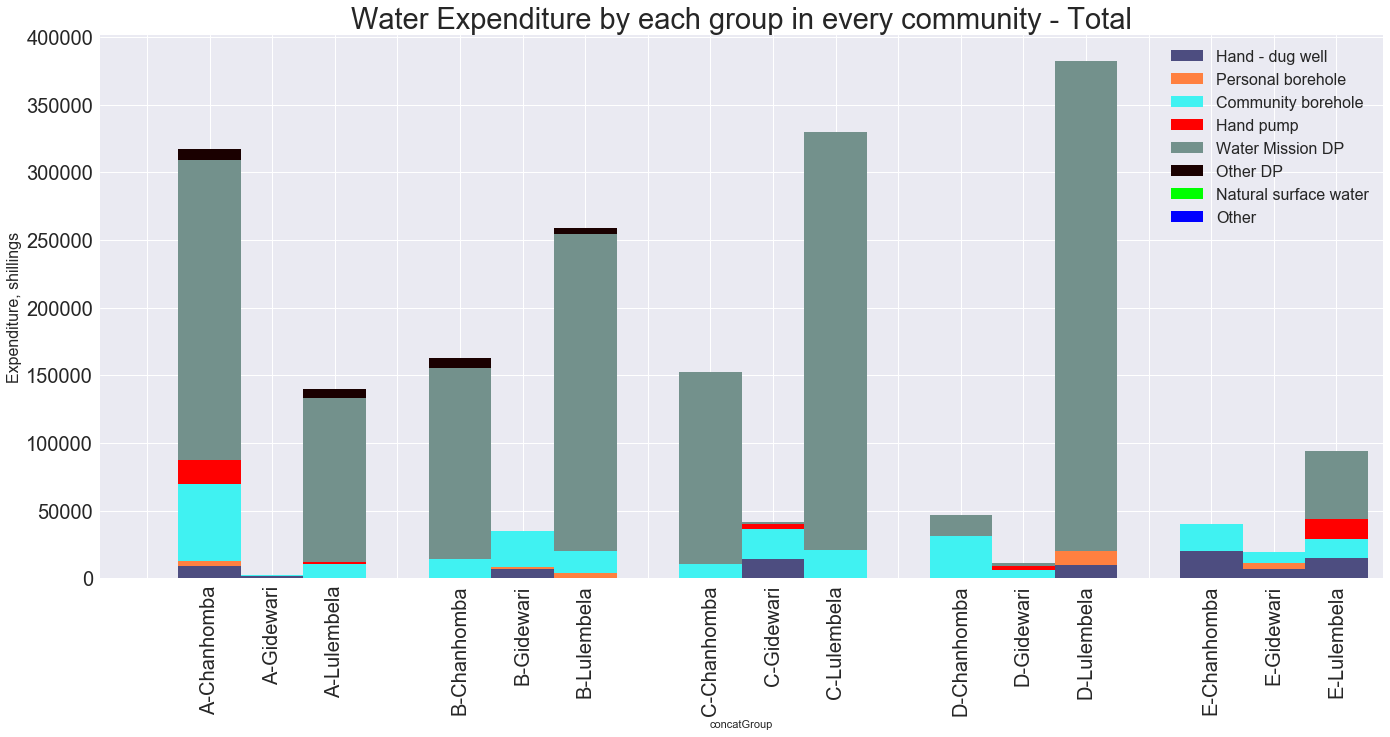

In [139]:
show_stacked_plot(df, 'Water Expenditure by each group in every community - Total', source_of_water, 'Total', 'Expenditure, shillings', 'WaterExpenditure', 0)

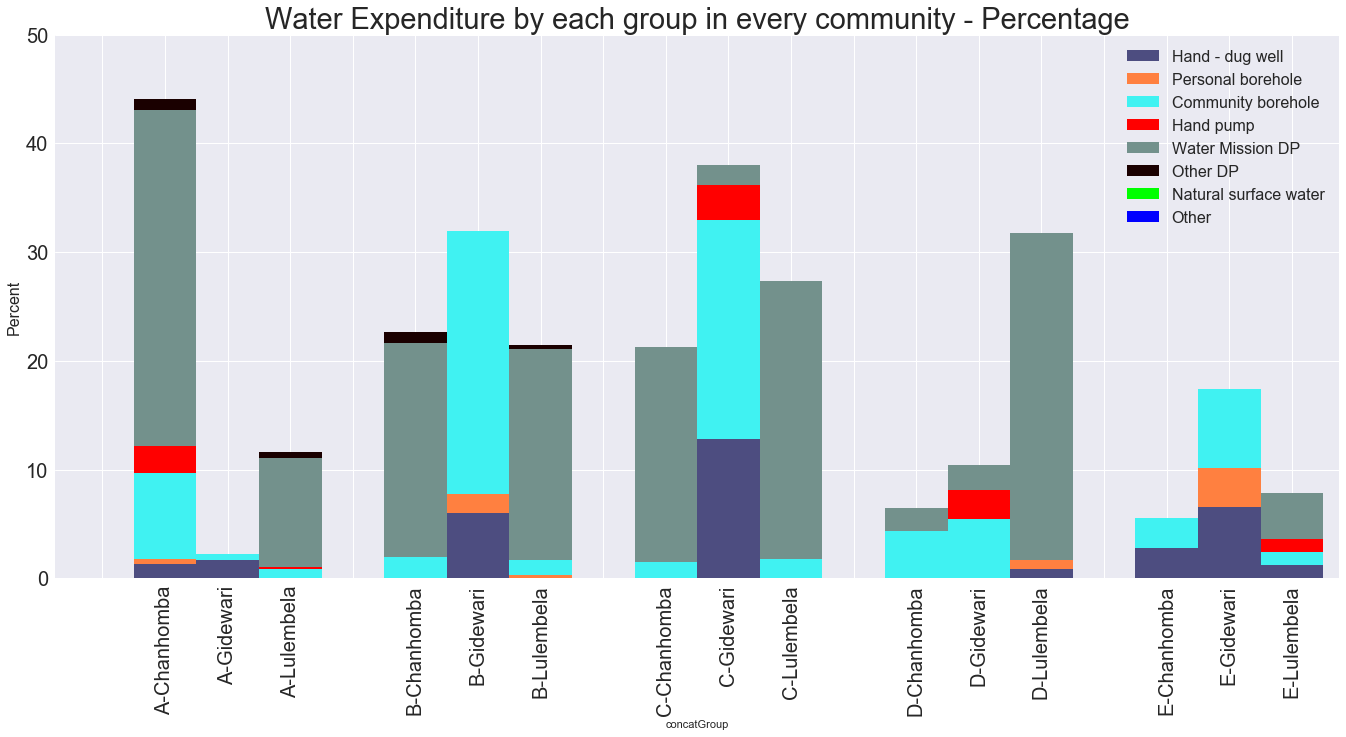

In [140]:
show_stacked_plot(df, 'Water Expenditure by each group in every community - Percentage', source_of_water, 'Percent', 'Percent', 'WaterExpenditure', 50)

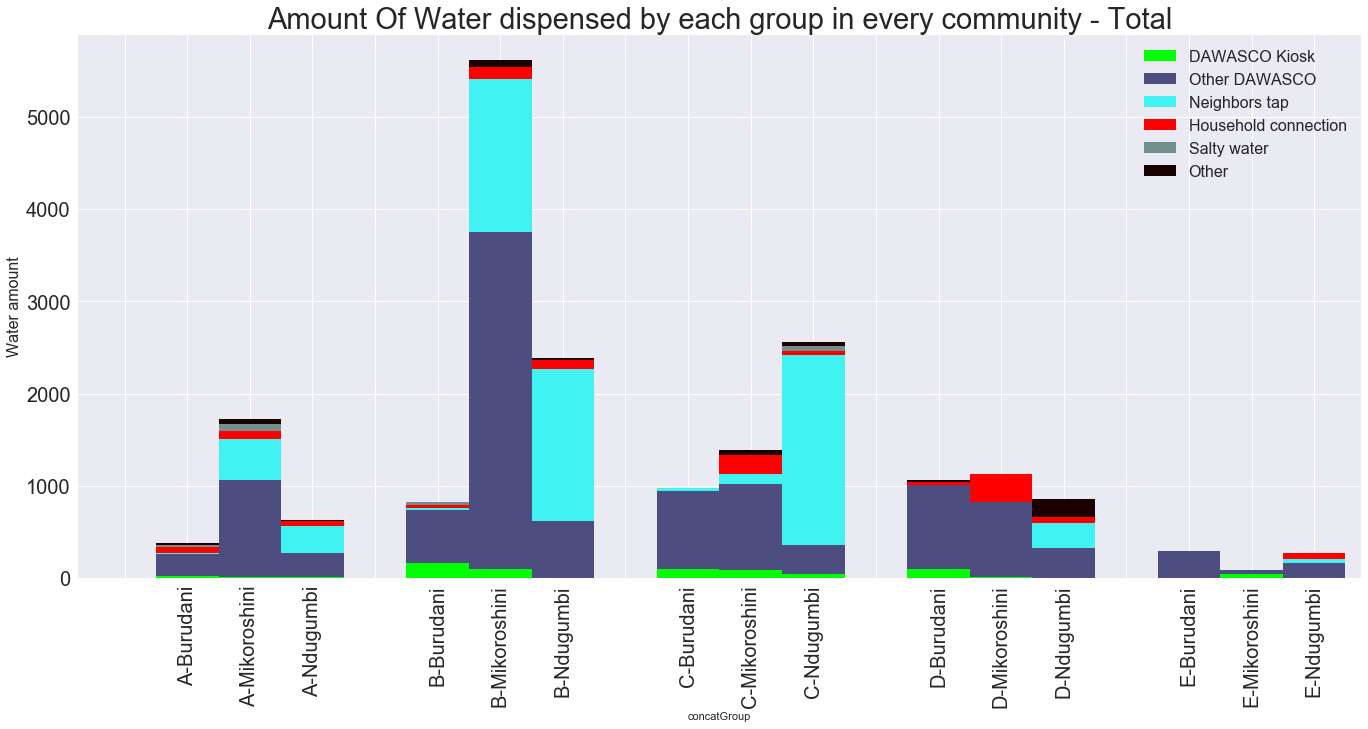

In [141]:
show_stacked_plot2(df_urban, 'Amount Of Water dispensed by each group in every community - Total', source_of_water2, 'Total', 'Water amount', 'AmountOfWater', 0)

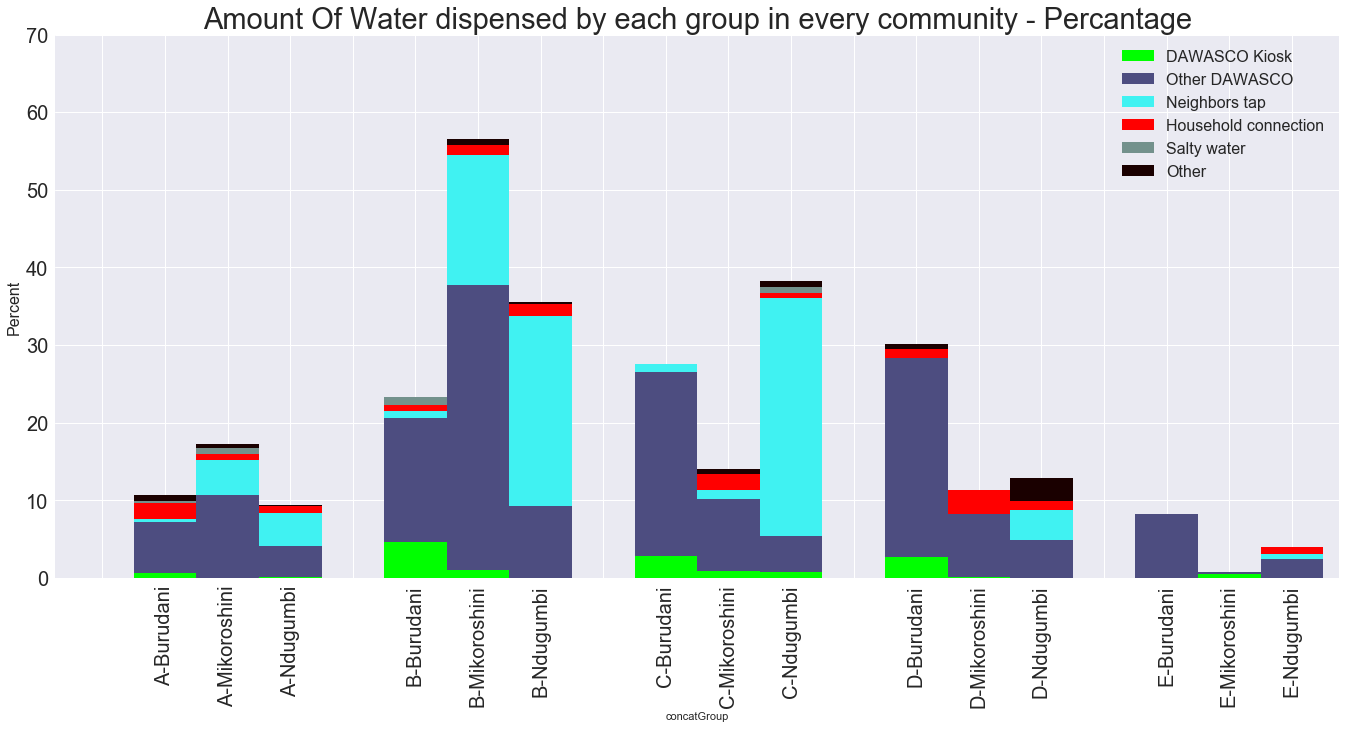

In [142]:
show_stacked_plot2(df_urban, 'Amount Of Water dispensed by each group in every community - Percantage', source_of_water2, 'Percent', 'Percent', 'AmountOfWater', 70)

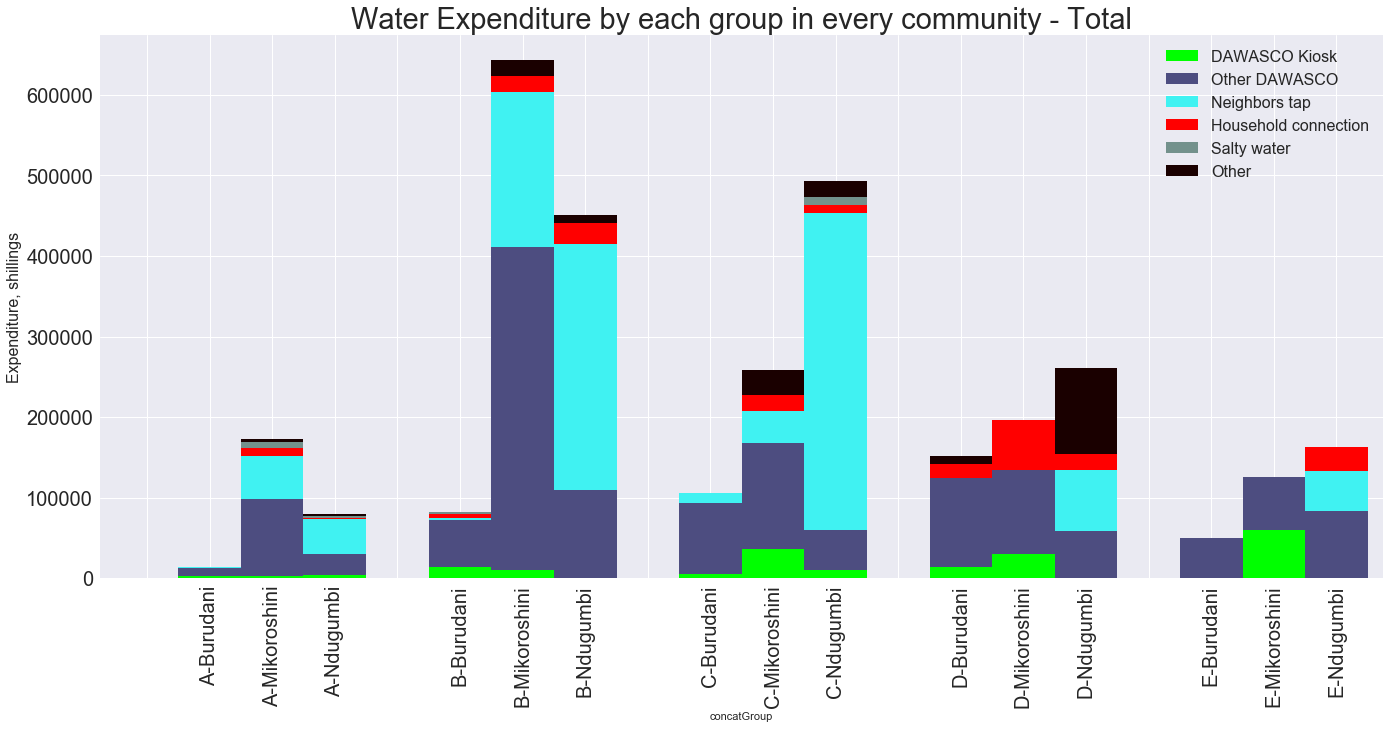

In [143]:
show_stacked_plot2(df_urban, 'Water Expenditure by each group in every community - Total', source_of_water2, 'Total', 'Expenditure, shillings', 'WaterExpenditure', 0)

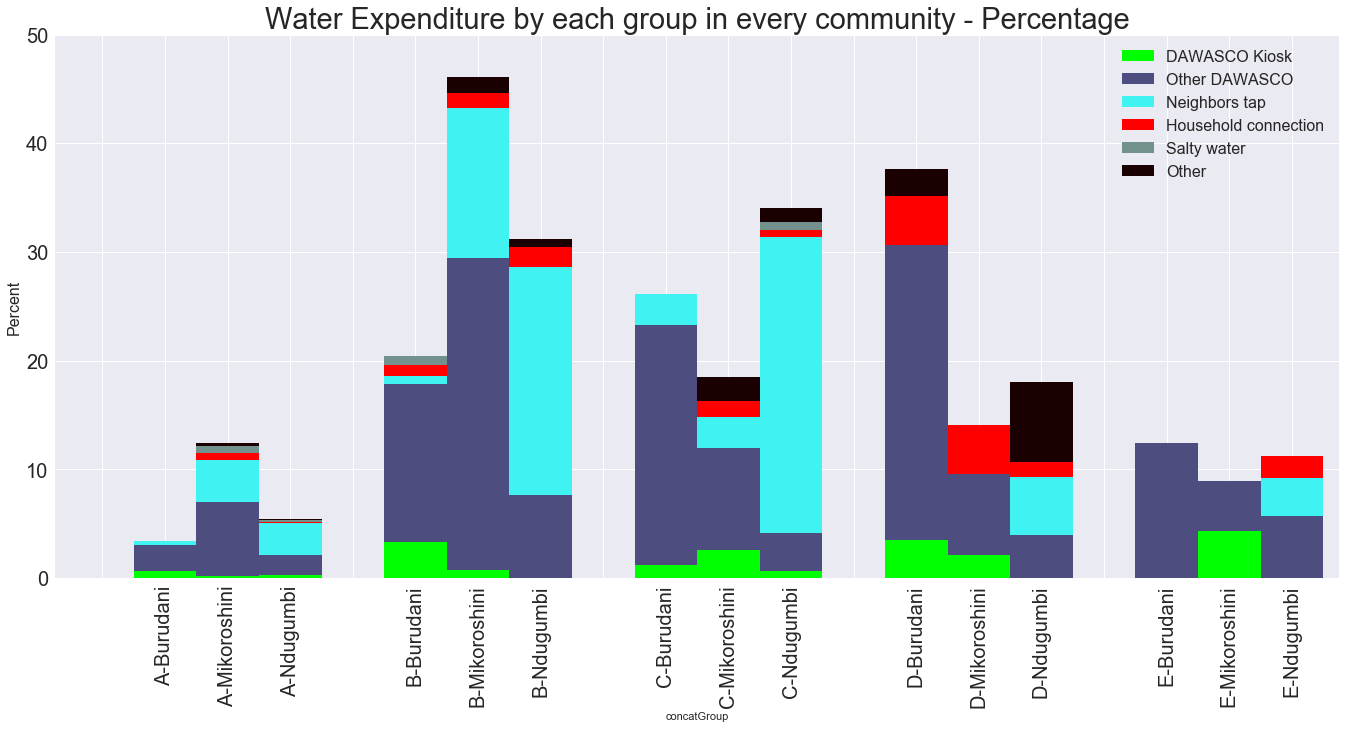

In [144]:
show_stacked_plot2(df_urban, 'Water Expenditure by each group in every community - Percentage', source_of_water2, 'Percent', 'Percent', 'WaterExpenditure', 50)

<a id='bl_describing'></a>
# Describing clusters

<a id='bl_urb_describing'></a>
## Describing urban clusters

In [145]:
dfc = df_urban[['Group', 'Age', 'Gender', 'hh_mem', 'BankAccount', 'RudWI', 'WaterExpenditure','AmountOfWater']]

In [146]:
dfc[dfc.Group == 'A'].describe()

Age      Gender      hh_mem  BankAccount       RudWI  \
count  116.000000  117.000000  117.000000   117.000000  117.000000   
mean    32.965517    0.401709    4.769231     0.641026    2.384615   
std      9.565273    0.492352    2.742968     0.481763    0.849403   
min     18.000000    0.000000    0.000000     0.000000    0.000000   
25%     27.000000    0.000000    3.000000     0.000000    2.000000   
50%     30.000000    0.000000    5.000000     1.000000    3.000000   
75%     39.250000    1.000000    7.000000     1.000000    3.000000   
max     73.000000    1.000000   12.000000     1.000000    3.000000   

       WaterExpenditure  AmountOfWater  
count        117.000000     117.000000  
mean        2270.638462      23.365812  
std         1371.489609      18.378253  
min            0.000000       0.000000  
25%         1200.000000      10.000000  
50%         2100.000000      20.000000  
75%         3500.000000      35.000000  
max         4200.000000     100.000000

In [147]:
dfc[dfc.Group == 'B'].describe()

Age      Gender      hh_mem  BankAccount       RudWI  \
count  201.000000  202.000000  202.000000   202.000000  202.000000   
mean    31.114428    0.490099    5.188119     0.712871    2.623762   
std      8.061131    0.501144    2.818605     0.453546    0.596031   
min     18.000000    0.000000    0.000000     0.000000    1.000000   
25%     26.000000    0.000000    3.000000     0.000000    2.000000   
50%     29.000000    0.000000    5.000000     1.000000    3.000000   
75%     35.000000    1.000000    7.000000     1.000000    3.000000   
max     60.000000    1.000000   17.000000     1.000000    3.000000   

       WaterExpenditure  AmountOfWater  
count        202.000000     202.000000  
mean        5825.247525      43.685446  
std         1730.364235      19.891715  
min         2000.000000       0.460000  
25%         5000.000000      30.000000  
50%         6000.000000      40.000000  
75%         7000.000000      60.000000  
max         9000.000000      90.000000

In [148]:
dfc[dfc.Group == 'C'].describe()

Age     Gender     hh_mem  BankAccount      RudWI  \
count  85.000000  89.000000  89.000000    89.000000  89.000000   
mean   32.176471   0.370787   5.662921     0.719101   2.617978   
std     8.022552   0.485752   2.957824     0.451985   0.682669   
min    21.000000   0.000000   1.000000     0.000000   0.000000   
25%    26.000000   0.000000   3.000000     0.000000   2.000000   
50%    29.000000   0.000000   5.000000     1.000000   3.000000   
75%    37.000000   1.000000   8.000000     1.000000   3.000000   
max    53.000000   1.000000  14.000000     1.000000   3.000000   

       WaterExpenditure  AmountOfWater  
count         89.000000      89.000000  
mean        9630.337079      55.483146  
std         3296.740970      29.317662  
min         4000.000000       8.000000  
25%         9000.000000      42.000000  
50%        10000.000000      50.000000  
75%        10500.000000      60.000000  
max        21000.000000     200.000000

In [149]:
dfc[dfc.Group == 'D'].describe()

Age     Gender     hh_mem  BankAccount      RudWI  \
count  39.000000  39.000000  39.000000    39.000000  39.000000   
mean   31.769231   0.333333   5.615385     0.564103   2.461538   
std     9.160733   0.477567   3.305620     0.502356   0.682339   
min    18.000000   0.000000   0.000000     0.000000   1.000000   
25%    24.000000   0.000000   3.000000     0.000000   2.000000   
50%    30.000000   0.000000   5.000000     1.000000   3.000000   
75%    37.000000   1.000000   8.000000     1.000000   3.000000   
max    52.000000   1.000000  14.000000     1.000000   3.000000   

       WaterExpenditure  AmountOfWater  
count         39.000000      39.000000  
mean       15597.435897      78.333333  
std         9267.273692      86.097048  
min         7000.000000       5.000000  
25%         8000.000000      29.000000  
50%        14000.000000      70.000000  
75%        20500.000000      80.000000  
max        45000.000000     450.000000

In [150]:
dfc[dfc.Group == 'E'].describe()

Age    Gender    hh_mem  BankAccount     RudWI  WaterExpenditure  \
count   9.000000  9.000000  9.000000     9.000000  9.000000          9.000000   
mean   34.333333  0.222222  3.333333     0.666667  2.333333      37555.555556   
std    11.789826  0.440959  2.598076     0.500000  0.707107      19072.959335   
min    20.000000  0.000000  1.000000     0.000000  1.000000      15000.000000   
25%    24.000000  0.000000  1.000000     0.000000  2.000000      20000.000000   
50%    36.000000  0.000000  2.000000     1.000000  2.000000      35000.000000   
75%    43.000000  0.000000  6.000000     1.000000  3.000000      50000.000000   
max    51.000000  1.000000  7.000000     1.000000  3.000000      65000.000000   

       AmountOfWater  
count       9.000000  
mean       71.666667  
std        48.690348  
min         5.000000  
25%        40.000000  
50%        60.000000  
75%        97.000000  
max       150.000000

In [151]:
def get_group_measurements(df):    
    df_pt = df[['Group','Count', 'WaterExpenditure','AmountOfWater', 'hh_mem', 'Age', 'Gender', 'BankAccount', 'RudWI']]
    aggregations = {
        'Count': {
                'Responders': 'sum'

            },
        'hh_mem': {
                'Average value': 'mean', 
                'Min value': 'min', 
                'Max value': 'max'

            },
        'Age': {
                'Average value': 'mean', 
                'Min value': 'min', 
                'Max value': 'max'

            },
        'Gender': {
                'Average value': 'mean'
            },
        'BankAccount': {
                'Average value': 'mean', 
                'Min value': 'min', 
                'Max value': 'max'

            },
        'RudWI': {
                'Average value': 'mean', 
                'Min value': 'min', 
                'Max value': 'max'

            },
         'WaterExpenditure': {
                'Average value': 'mean', 
                'Min value': 'min', 
                'Max value': 'max'

            },
        'AmountOfWater': {
                'Average value': 'mean', 
                'Min value': 'min', 
                'Max value': 'max'
            }
    }
    df_g = df_pt.groupby(['Group']).agg(aggregations)
    df_g = df_g.apply(lambda x: np.round(x,2))    
    df_g.Gender = df_g.Gender * 100
    df_g['Women'] = 100 - df_g.Gender 
    df_g['Men'] = df_g.Gender 
    df_g.BankAccount = df_g.BankAccount * 100
    return df_g[['Count', 'WaterExpenditure','AmountOfWater', 'hh_mem', 'Age', 'BankAccount', 'RudWI']]

In [152]:
get_group_measurements(df_cluster1_urban).reset_index()

C:\Program Files\Anaconda3\lib\site-packages\pandas\core\groupby.py:3961: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


Group      Count WaterExpenditure                         AmountOfWater  \
        Responders        Max value Min value Average value     Max value   
0     A         16           1500.0       0.0        856.29         100.0   
1     B         31           3500.0    2000.0       2664.52          70.0   
2     C         21           6500.0    4000.0       5019.05         100.0   
3     D         18          10500.0    7000.0       8427.78         105.0   
4     E          3          20000.0   15000.0      16666.67         150.0   

                             hh_mem                               Age  \
  Min value Average value Max value Min value Average value Max value   
0       0.0         23.81      11.0       2.0          4.94      73.0   
1       7.0         26.65      13.0       1.0          5.23      57.0   
2       8.0         46.67      11.0       1.0          5.24      49.0   
3      10.0         59.39      14.0       2.0          5.83      52.0   
4       5.0         98.33       7.0       2.0          5.33      51.0   

                          BankAccount                             RudWI  \
  Min value Average value   Max value Min value Average value Max value   
0      19.0         33.25       100.0       0.0          44.0         3   
1      18.0         31.67       100.0       0.0          35.0         3   
2      21.0         33.60       100.0       0.0          43.0         3   
3      18.0         32.50       100.0       0.0          33.0         3   
4      20.0         39.33       100.0       0.0          67.0         3   

                           
  Min value Average value  
0         0          1.94  
1         1          2.13  
2         0          2.10  
3         1          2.17  
4         2          2.33

In [153]:
get_group_measurements(df_cluster2_urban).reset_index()

C:\Program Files\Anaconda3\lib\site-packages\pandas\core\groupby.py:3961: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


Group      Count WaterExpenditure                         AmountOfWater  \
        Responders        Max value Min value Average value     Max value   
0     A         68           4200.0       0.0       2540.65         100.0   
1     B        102           9000.0    4500.0       6301.96          90.0   
2     C         20          21000.0   10000.0      12925.00         200.0   
3     D          6          45000.0   24000.0      32683.33         450.0   
4     E          2          65000.0   60000.0      62500.00          49.0   

                             hh_mem                               Age  \
  Min value Average value Max value Min value Average value Max value   
0      1.00         25.29      12.0       1.0          4.57      58.0   
1      0.46         55.02      17.0       1.0          4.92      60.0   
2      8.00         69.70      14.0       1.0          5.55      50.0   
3      5.00        187.50      11.0       2.0          4.67      38.0   
4     34.00         41.50       2.0       1.0          1.50      25.0   

                          BankAccount                             RudWI  \
  Min value Average value   Max value Min value Average value Max value   
0      18.0         33.06       100.0       0.0          57.0         3   
1      18.0         32.25       100.0       0.0          70.0         3   
2      25.0         35.40       100.0       0.0          75.0         3   
3      22.0         26.83       100.0       0.0          50.0         3   
4      22.0         23.50       100.0       0.0          50.0         2   

                           
  Min value Average value  
0         0          2.31  
1         1          2.62  
2         1          2.65  
3         1          2.33  
4         1          1.50

In [154]:
get_group_measurements(df_cluster3_urban).reset_index()

C:\Program Files\Anaconda3\lib\site-packages\pandas\core\groupby.py:3961: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


Group      Count WaterExpenditure                         AmountOfWater  \
        Responders        Max value Min value Average value     Max value   
0     A         33           4000.0       0.0       2400.00          60.0   
1     B         69           8000.0    4600.0       6540.58          80.0   
2     C         48          12000.0    9000.0      10275.00         120.0   
3     D         15          25000.0   14000.0      17366.67         140.0   
4     E          4          50000.0   30000.0      40750.00          97.0   

                             hh_mem                               Age  \
  Min value Average value Max value Min value Average value Max value   
0       0.8         19.18      12.0       0.0          5.09      49.0   
1       3.0         34.58      11.0       0.0          5.57      49.0   
2      20.0         53.42      12.0       1.0          5.90      53.0   
3      28.0         57.40      11.0       0.0          5.73      44.0   
4      40.0         66.75       6.0       1.0          2.75      43.0   

                          BankAccount                             RudWI  \
  Min value Average value   Max value Min value Average value Max value   
0      22.0         32.62       100.0       0.0          88.0         3   
1      19.0         29.19       100.0       0.0          90.0         3   
2      23.0         30.11       100.0       0.0          83.0         3   
3      24.0         32.87       100.0       0.0          87.0         3   
4      24.0         36.00       100.0       0.0          75.0         3   

                           
  Min value Average value  
0         0          2.76  
1         1          2.86  
2         2          2.83  
3         2          2.87  
4         2          2.75

In [155]:
urb_clusters = df_cluster1_urban.append(df_cluster2_urban).append(df_cluster3_urban)
urb_clusters_Count = urb_clusters.groupby(['CommName', 'Group']).Count.sum().reset_index()

In [156]:
from IPython.html.widgets import interact
@interact(ind = list(['Reason/Cost', 'Reason/Availability', 'Reason/Time_Distance',
       'Reason/Quality', 'Reason/Other', 'PowerSource','Concrete', 'SourceOfLighting', 'PrimarySource',
       'WaterAvailability']), 
         miko=True,
         ndug=True,)
def printClusterTable(ind, miko, ndug):
    urb_clusters1 = urb_clusters.groupby(['CommName', 'Group', ind]).Count.sum().reset_index()
    res = pd.merge(urb_clusters_Count, urb_clusters1, on = ['CommName', 'Group'])
    res.columns = ['CommName','Group','Count_all','Reason/Time_Distance','Count']
    res.Count = np.round((res.Count/ res.Count_all * 100), 0)
    res = res[((res.CommName == 'Mikoroshini') & miko) | ((res.CommName == 'Ndugumbi') & ndug)]
    return res[['CommName','Group','Reason/Time_Distance','Count']]

C:\Users\Mishchuk_AA\AppData\Roaming\Python\Python35\site-packages\IPython\html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


<a id='bl_rrl_describing'></a>
## Describing rural clusters

In [157]:
get_group_measurements(df_cluster1).reset_index()

C:\Program Files\Anaconda3\lib\site-packages\pandas\core\groupby.py:3961: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


Group      Count WaterExpenditure                         AmountOfWater  \
        Responders        Max value Min value Average value     Max value   
0     A        109           2800.0       0.0       1281.72         200.0   
1     B         66           5000.0    3000.0       3918.94         100.0   
2     C         51           7000.0    5500.0       6460.78         140.0   
3     D         41          10000.0    7500.0       9329.27        2000.0   
4     E          7          15000.0   12000.0      13428.57         280.0   

                             hh_mem                               Age  \
  Min value Average value Max value Min value Average value Max value   
0       0.8         31.26      14.0       2.0           5.4      61.0   
1       7.0         74.44      13.0       2.0           6.5      56.0   
2       6.0        121.33       9.0       9.0           9.0      54.0   
3       3.0        215.24      11.0       6.0           8.5      52.0   
4      21.0        140.57       7.0       3.0           5.0      52.0   

                          BankAccount                             RudWI  \
  Min value Average value   Max value Min value Average value Max value   
0      19.0         36.08       100.0       0.0          26.0         3   
1      24.0         34.50       100.0       0.0          23.0         3   
2      22.0         35.45       100.0       0.0          24.0         3   
3      20.0         32.54       100.0       0.0          22.0         3   
4      29.0         39.29         0.0       0.0           0.0         2   

                           
  Min value Average value  
0         0          1.36  
1         0          1.41  
2         0          1.27  
3         0          1.32  
4         0          1.00

In [158]:
c = get_group_measurements(df_cluster2).reset_index()[['Group','Count','WaterExpenditure','AmountOfWater','Age','BankAccount','RudWI']]
c

C:\Program Files\Anaconda3\lib\site-packages\pandas\core\groupby.py:3961: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


Group      Count WaterExpenditure                         AmountOfWater  \
        Responders        Max value Min value Average value     Max value   
0     A        161           5000.0       0.0       1968.54        3000.0   
1     B         23           9000.0    5250.0       7067.39         180.0   
2     C         14          12000.0   10000.0      10892.86         240.0   
3     D          3          16500.0   15000.0      15500.00         240.0   
4     E          2          20000.0   20000.0      20000.00          50.0   

                                Age                         BankAccount  \
  Min value Average value Max value Min value Average value   Max value   
0       0.0         53.14      71.0      17.0         33.73       100.0   
1      12.0        102.04      78.0      18.0         36.43       100.0   
2      20.0        145.36      60.0      22.0         32.64       100.0   
3      30.0        100.00      29.0      21.0         24.00       100.0   
4      14.0         32.00      47.0      30.0         38.50       100.0   

                              RudWI                          
  Min value Average value Max value Min value Average value  
0       0.0          26.0         3         0          1.09  
1       0.0          13.0         3         0          0.91  
2       0.0          14.0         2         0          0.86  
3       0.0          33.0         2         1          1.67  
4       0.0          50.0         2         1          1.50

In [159]:
c = get_group_measurements(df_cluster3).reset_index()[['Group','Count','WaterExpenditure','AmountOfWater','Age','BankAccount','RudWI']]
c

C:\Program Files\Anaconda3\lib\site-packages\pandas\core\groupby.py:3961: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


Group      Count WaterExpenditure                         AmountOfWater  \
        Responders        Max value Min value Average value     Max value   
0     A         54            600.0       0.0         46.48          60.0   
1     B         32           1200.0     750.0       1100.00          40.0   
2     C         24           2100.0    1500.0       1745.83          60.0   
3     D          4           3000.0    2500.0       2875.00          60.0   
4     E          5           4000.0    3600.0       3840.00          40.0   

                                Age                         BankAccount  \
  Min value Average value Max value Min value Average value   Max value   
0       0.0         31.33      64.0      22.0         36.64       100.0   
1      15.0         32.97      53.0      23.0         31.94       100.0   
2       7.0         34.62      55.0      24.0         35.04       100.0   
3      20.0         37.50      44.0      21.0         30.25       100.0   
4      12.0         27.80      52.0      25.0         37.20       100.0   

                              RudWI                          
  Min value Average value Max value Min value Average value  
0       0.0          39.0         3         0          1.59  
1       0.0          56.0         3         1          2.09  
2       0.0          50.0         3         0          2.21  
3       0.0          50.0         3         2          2.50  
4       0.0          40.0         3         1          1.80

In [160]:
rural = df_cluster1.append(df_cluster2).append(df_cluster3)


In [161]:
rural.groupby(['CommName', 'Group']).Gender.mean().reset_index()

CommName Group    Gender
0   Chanhomba     A  0.813665
1   Chanhomba     B  0.869565
2   Chanhomba     C  0.928571
3   Chanhomba     D  1.000000
4   Chanhomba     E  0.500000
5    Gidewari     A  0.851852
6    Gidewari     B  0.718750
7    Gidewari     C  0.916667
8    Gidewari     D  0.500000
9    Gidewari     E  0.800000
10  Lulembela     A  0.669725
11  Lulembela     B  0.803030
12  Lulembela     C  0.960784
13  Lulembela     D  0.804878
14  Lulembela     E  0.571429

In [162]:
rural.groupby(['CommName', 'Group']).Farming.mean().reset_index()

CommName Group   Farming
0   Chanhomba     A  0.925466
1   Chanhomba     B  0.869565
2   Chanhomba     C  1.000000
3   Chanhomba     D  1.000000
4   Chanhomba     E  1.000000
5    Gidewari     A  1.000000
6    Gidewari     B  0.968750
7    Gidewari     C  1.000000
8    Gidewari     D  1.000000
9    Gidewari     E  1.000000
10  Lulembela     A  0.880734
11  Lulembela     B  0.924242
12  Lulembela     C  0.941176
13  Lulembela     D  0.853659
14  Lulembela     E  1.000000

In [163]:
rural.groupby(['CommName', 'Group']).AnimalRaising.mean().reset_index()


CommName Group  AnimalRaising
0   Chanhomba     A       0.695652
1   Chanhomba     B       0.565217
2   Chanhomba     C       0.714286
3   Chanhomba     D       0.333333
4   Chanhomba     E       0.500000
5    Gidewari     A       1.000000
6    Gidewari     B       0.968750
7    Gidewari     C       0.916667
8    Gidewari     D       1.000000
9    Gidewari     E       1.000000
10  Lulembela     A       0.293578
11  Lulembela     B       0.469697
12  Lulembela     C       0.470588
13  Lulembela     D       0.341463
14  Lulembela     E       0.571429

In [164]:
rur_clusters_Count = rural.groupby(['CommName', 'Group']).Count.sum().reset_index()

In [165]:
from IPython.html.widgets import interact
@interact(ind = list(['Reason/Cost', 'Reason/Availability', 'Reason/Time_Distance',
       'Reason/Quality', 'Reason/Other', 'PowerSource','FloorMaterial', 'SourceOfLighting', 'PrimarySource',
       'WaterAvailability']), 
         lul=True,
         chan=True,gid=True, sort_asc=True)
def printClusterTable(ind, lul, chan, gid, sort_asc):
    urb_clusters1 = rural.groupby(['CommName', 'Group', ind]).Count.sum().reset_index()
    res = pd.merge(rur_clusters_Count, urb_clusters1, on = ['CommName', 'Group'])
    res.columns = ['CommName','Group','Count_all','Reason/Time_Distance','Count']
    res.Count = np.round((res.Count/ res.Count_all * 100), 0)
    res = res[((res.CommName == 'Lulembela') & lul) | ((res.CommName == 'Chanhomba') & chan) | ((res.CommName == 'Gidewari') & gid)]
    return res[['CommName','Group','Reason/Time_Distance','Count']].sort_values(['Group','Reason/Time_Distance'], ascending=[True, sort_asc])